In [916]:
import os
import imageio
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import visvis as vv

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



In [917]:
letterDict={
  "a": 0,"b": 1,"c": 2,"d": 3,"e": 4,"f": 5,"g": 6,"h": 7,"i": 8,
    "j": 9,"k": 10,"l": 11,"m": 12,"n": 13,"o": 14,"p": 15,"q": 16,"r": 17,
    "s": 18,"t": 19,"u": 20,"v": 21,"w": 22,"x": 23,"y": 24,"z": 25}

numberDict={
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R",
    18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y", 25:"Z"}


def readPicture(df_complete, directory,letter_value):
    im = imageio.imread(directory)
    im.shape
    print("Letter value: ", directory, end="\r")

    im=np.reshape(im,400)
    df = pd.DataFrame(data=im).T
    y = np.repeat(0,400)
    df['Letter'] = letter_value
    
    return df_complete.append(df, ignore_index=True)

#Method ment for adding augmented pictures to a dataset
def addPictureToDataset(dataset, picture, letter_value):
    picture = np.reshape(picture,400)
    df = pd.DataFrame(data=picture).T
    df['Letter'] = letter_value
    return dataset.append(df, ignore_index=True)



### Loading all images and augmenting. Loading into dataframes

In [1098]:
def read_all_images(upper_directory):
    number_of_images = 0
    original_imgs = pd.DataFrame()
    aug20 = pd.DataFrame()
    aug90 = pd.DataFrame()
    aug270 = pd.DataFrame()
    aug320 = pd.DataFrame()
    for subdir, dirs, files in os.walk(upper_directory):
        for file in files:
            number_of_images+=1
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            if filepath.endswith(".jpg"):
                # print(filepath)
                # Rotate every image that is being loaded:
            
                x = filepath.split("/")
                rotate20 = rotate_image(filepath,x[-1],20)
                rotate90 = rotate_image(filepath,x[-1],90)
                rotate270 = rotate_image(filepath,x[-1],270)
                rotate320 = rotate_image(filepath,x[-1],320)
                
                # zoomed:
                zoomed = zoom_images_and_save(filepath,x[-1])
            
                # The label for the data:
                letter = (x[-1][0])
                letter_val = letterDict.get(letter)
                original_imgs = readPicture(original_imgs,filepath,letter_val)
                aug20 = addPictureToDataset(aug20, rotate20, letter_val)
                aug90 = addPictureToDataset(aug90, rotate90, letter_val)
                aug270 = addPictureToDataset(aug270, rotate270, letter_val)
                aug320 = addPictureToDataset(aug320, rotate320, letter_val)

                # zoomed:
                aug320 = addPictureToDataset(aug320, zoomed, letter_val)
                
    print("image")
    # vv.imshow("./dataset3/chars74k-lite/augmented/rotated_neg_a102.jpg")
    print("number_of_images", number_of_images)
    return original_imgs, aug20, aug90, aug270, aug320


#Rotates an image, stores it in a folder and returns the rotated image
def rotate_image(image_path,ending,deg):
    out_path = "./dataset3/augmented/"
    image_to_rotate = plt.imread(image_path)

    # Rotating the image:
    rotated_positive = ndimage.rotate(image_to_rotate, deg, reshape=False)
   
    fullpath = os.path.join(out_path, 'rotated_'+ str(deg) + '_' + ending)

    imageio.imwrite(fullpath, rotated_positive)
    return rotated_positive
                   
# Unaugmented data, no feature selection:            
original_raw, aug20, aug90, aug270, aug320 = read_all_images("./dataset3/chars74k-lite")

imager value:  ./dataset3/chars74k-lite/z/z_9.jpggg4445.jpgt3/chars74k-lite/a/a_284.jpg./dataset3/chars74k-lite/a/a_360.jpg ./dataset3/chars74k-lite/a/a_445.jpg ./dataset3/chars74k-lite/a/a_507.jpg ./dataset3/chars74k-lite/b/b_87.jpg ./dataset3/chars74k-lite/c/c_144.jpg ./dataset3/chars74k-lite/d/d_96.jpg ./dataset3/chars74k-lite/e/e_349.jpg ./dataset3/chars74k-lite/e/e_469.jpg ./dataset3/chars74k-lite/e/e_492.jpg ./dataset3/chars74k-lite/f/f_62.jpg ./dataset3/chars74k-lite/g/g_106.jpg ./dataset3/chars74k-lite/g/g_172.jpg ./dataset3/chars74k-lite/i/i_142.jpg./dataset3/chars74k-lite/j/j_107.jpg ./dataset3/chars74k-lite/j/j_15.jpg ./dataset3/chars74k-lite/j/j_9.jpg ./dataset3/chars74k-lite/k/k_62.jpg ./dataset3/chars74k-lite/l/l_214.jpg ./dataset3/chars74k-lite/m/m_103.jpg ./dataset3/chars74k-lite/m/m_55.jpg ./dataset3/chars74k-lite/n/n_331.jpg ./dataset3/chars74k-lite/n/n_461.jpg./dataset3/chars74k-lite/n/n_466.jpg ./dataset3/chars74k-lite/n/n_8.jpg./dataset3/chars74k-lite/o/o_302.jpg .

### Data augmentation Zoom (Added to the dataset in read_all_images()):

In [919]:

def cv2_clipped_zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
# print(original_raw[0].tolist())

#"./dataset3/chars74k-lite/a/a_4.jpg"
def zoom_images_and_save(path,ending):
    #img = imageio.imread(path)
    #plt.imshow(img)
    #plt.show()
    
    img = imageio.imread(path)
    zoomed = cv2_clipped_zoom(img, 0.5)
    # plt.imshow(zoomed)

    out_path = "./dataset3/augmented/"
    # zoomed = plt.imread(image_path)

   
    fullpath = os.path.join(out_path, 'zoomed'+'_' + ending)

    imageio.imwrite(fullpath, zoomed)
    return zoomed

In [1135]:
#Methood merges dataset1 with dataset2
def mergeData(dataset1, dataset2):
    return dataset1.append(dataset2, ignore_index=True)

mergedData = mergeData(original_raw, aug20)
mergedData = mergeData(mergedData, aug90)
mergedData = mergeData(mergedData, aug270)
mergedData = mergeData(mergedData, aug320)

In [921]:
# splitting function:
def get_train_test_set(data):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    
    for i in range(26):
        train, test = train_test_split(data.loc[data['Letter']==i], 
                                       test_size=0.2, shuffle=True)
        
        train_set = train_set.append([train], ignore_index=True)
        test_set = test_set.append([test], ignore_index=True)
    return train_set, test_set

## Running models on the data:
### kNN (On Raw, merged, feature-treated data)


In [922]:
#### Running models on the raw data:

def calc_predictions(classifier, train):
    y_pred = []
    n = train.shape[0]
    counter = 0
    clf = classifier.fit(train.drop(labels='Letter', axis = 1), train.iloc[:,-1])
    for row in train.drop(labels='Letter', axis = 1).iterrows():
        y_pred.append(clf.predict([row[1].tolist()]))
        counter +=1
        print((counter/n)*100,"%",end="\r")
    return y_pred,clf

def test_classifier(clf, data):
    y = []
    for row in data.drop(labels='Letter', axis = 1).iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y



#### Splitting the raw set and running knn:

In [1101]:

# Raw training and test set:
train_set_raw, test_set_raw = get_train_test_set(original_raw)

#### KNN #####
neigh = KNeighborsClassifier(n_neighbors=3)
y_raw_train_pred, clf = calc_predictions(neigh,train_set_raw)

y_test_pred = test_classifier(clf, test_set_raw)


#### Splitting the merged set and running knn:

In [1100]:
### Running model on the augmented + raw data:

train_set_merged, test_set_merged = get_train_test_set(mergedData)

neigh = KNeighborsClassifier(n_neighbors=3)
y_merged_train_pred, clf_n = calc_predictions(neigh, train_set_merged)

y_merged_test_pred = test_classifier(clf_n, test_set_merged)


### Accuracy scores for knn

In [976]:
## Raw data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred))
# Test:
print("accuracy_score_knn_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred))


print(train_set_merged.iloc[:,-1].shape)

## Merged data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred))
# Test
print("accuracy_score_knn_test_data:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred))



accuracy_score_knn_training_data: 0.8383802816901409
accuracy_score_knn_test_data: 0.6801675977653632
(34128,)
accuracy_score_knn_training_data: 0.8413326300984529
accuracy_score_knn_test_data: 0.6987359550561798


## Random Forest (On Raw, merged, feature-treated data)


In [1256]:
clf_rf = RandomForestClassifier(n_estimators=200,random_state=0)

y_raw_train_pred_rf, clf_rf = calc_predictions(clf_rf,train_set_raw)

y_test_pred_rf = test_classifier(clf_rf, test_set_raw)

In [1257]:
y_merged_train_pred_rf, clf_rf = calc_predictions(clf_rf, train_set_merged)

y_merged_test_pred_rf = test_classifier(clf_rf, test_set_merged)


### Accuracy scores for random forest

In [1255]:
### Random forest accuracy:
## Raw data:
# Train:
print("accuracy_score_randomforest_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred_rf))
# Test: 
print("accuracy_score_randomforest_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred_rf))


#print(train_set_merged.iloc[:,-1].shape)
## Merged data:

# Train:
print("accuracy_score_randomforest_training_data_merged:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred_rf))
# Test
print("accuracy_score_randomforest_test_data_merged:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred_rf))



ValueError: Found input variables with inconsistent numbers of samples: [5683, 5680]

In [1254]:
def printLetter(letter):
    numpy_letter = letter[0:-1].values
    plt.imshow(numpy_letter.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.axis("off")
    plt.title('Supposed to be {}'.format(numberDict.get(letter['Letter'])), fontsize=20)
    plt.show()
    return

# a_letter = train_set.iloc[2001]
# printLetter(a_letter)


# Tensorflow
### Implementation

In [927]:
import tensorflow as tf
import gzip
import pickle

def DNN(train_X,train_Y,test_X,test_y):
    # Scale data (normalization), easier for network to learn:
    # plt.imshow(train_X[0])
    # plt.show
    train_X = tf.keras.utils.normalize(train_X,axis=1)
    test_X = tf.keras.utils.normalize(test_X,axis=1)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(651, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(651, activation = tf.nn.relu ))





    model.add(tf.keras.layers.Dense(26, activation = tf.nn.softmax ))

    model.compile(optimizer ='adam',
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    # train:
    model.fit(train_X, train_Y, epochs = 18)
    loss, accuracy = evaluate_model(model,test_X,test_y)

    return loss, accuracy, model


# Helper function trained model:
def evaluate_model(model,test_X,test_y):
    val_loss, val_acc = model.evaluate(test_X, test_y)
    return val_loss, val_acc




### Running TensorFlow DNN on the data:
### Raw data and merged:

In [1102]:
# train and test are dataframes (with the labels in the last column for both)
def transform_data_for_tensorflow_and_run(train,test):
    trainx = (train.drop(labels='Letter', axis = 1)).values
    trainy = np.array(train['Letter'].tolist())
    
    testx = (test.drop(labels='Letter', axis = 1)).values
    testy = np.array(test['Letter'].tolist())
    loss, accuracy, model_tensor = DNN(trainx,
           trainy,
           testx,
           testy)
    
    return loss, accuracy, model_tensor

# Raw set:
l1,a1,model_tensor = transform_data_for_tensorflow_and_run(train_set_raw,
                                              test_set_raw)
print(" ")
print("loss on raw data:",11)
print("Accuracy on raw data: ",a1)

# Merged set
l2, a2,model_tensor_merged = transform_data_for_tensorflow_and_run(train_set_merged,
                                               test_set_merged)
print(" ")
print("loss on merged data:",12)
print("Accuracy on merged data: ",a2)


Epoch 1/18
5683/5683 [==============================] - 5s 824us/sample - loss: 2.7228 - acc: 0.2414
Epoch 2/18
5683/5683 [==============================] - 4s 621us/sample - loss: 1.7616 - acc: 0.4876
Epoch 3/18
5683/5683 [==============================] - 4s 677us/sample - loss: 1.3419 - acc: 0.6067
Epoch 4/18
5683/5683 [==============================] - 4s 625us/sample - loss: 1.1173 - acc: 0.6817
Epoch 5/18
5683/5683 [==============================] - 4s 644us/sample - loss: 0.9435 - acc: 0.7278
Epoch 6/18
5683/5683 [==============================] - 4s 650us/sample - loss: 0.8175 - acc: 0.7686
Epoch 7/18
5683/5683 [==============================] - 4s 624us/sample - loss: 0.7162 - acc: 0.7920
Epoch 8/18
5683/5683 [==============================] - 3s 609us/sample - loss: 0.6187 - acc: 0.8254
Epoch 9/18
5683/5683 [==============================] - 4s 642us/sample - loss: 0.5530 - acc: 0.8422
Epoch 10/18
5683/5683 [==============================] - 5s 882us/sample - loss: 0.4983 - a

# Printing some classified images:

ll 
0
Was classified as an: H


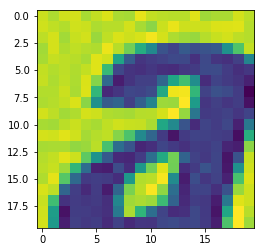

 
1
Was classified as an: A


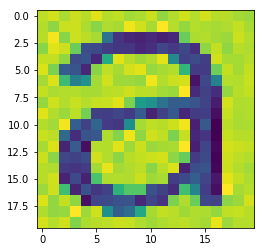

 
2
Was classified as an: A


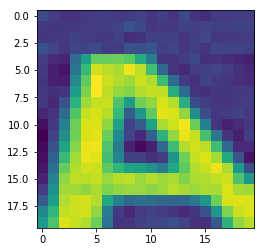

 
3
Was classified as an: A


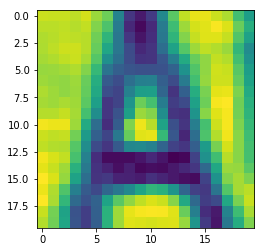

 
4
Was classified as an: A


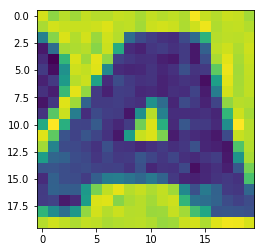

 
5
Was classified as an: A


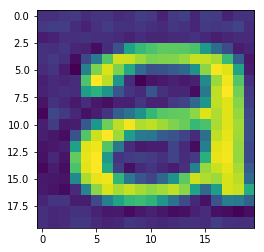

 
6
Was classified as an: A


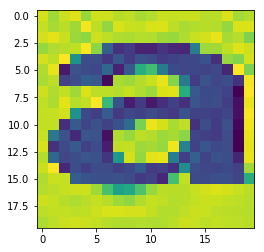

 
7
Was classified as an: A


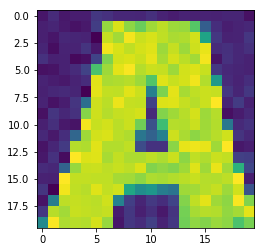

 
8
Was classified as an: A


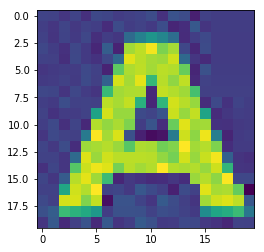

 
9
Was classified as an: A


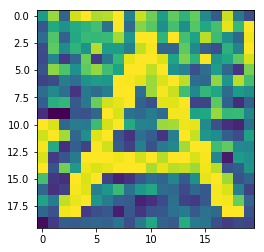

 
10
Was classified as an: A


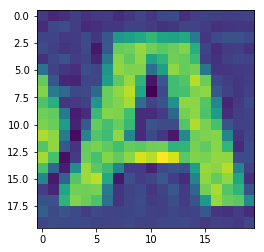

 
11
Was classified as an: A


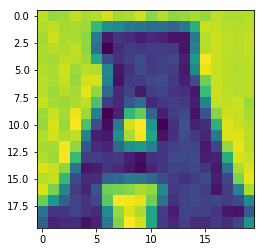

 
12
Was classified as an: A


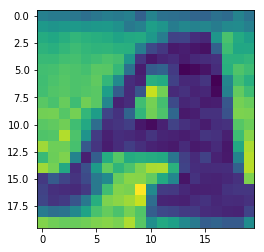

 
13
Was classified as an: N


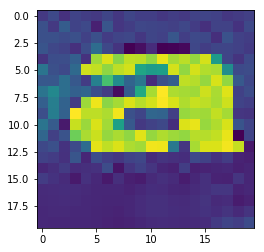

 
14
Was classified as an: A


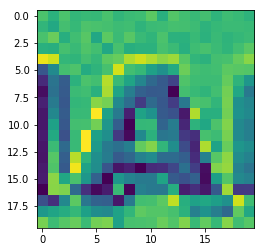

 
15
Was classified as an: S


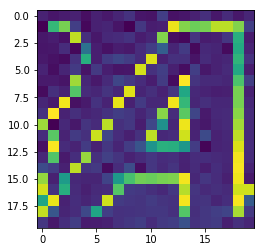

 
16
Was classified as an: A


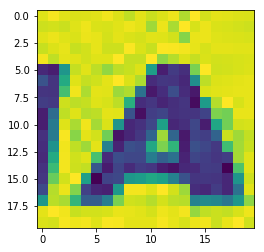

 
17
Was classified as an: A


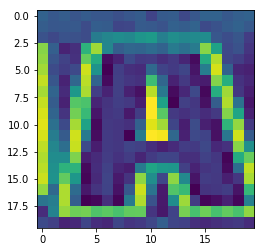

 
18
Was classified as an: A


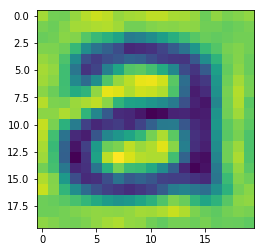

 
19
Was classified as an: A


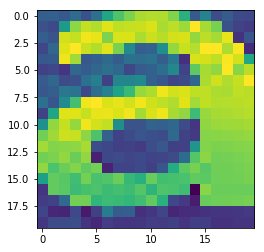

 
20
Was classified as an: A


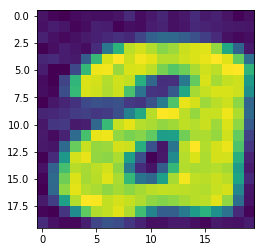

 
21
Was classified as an: H


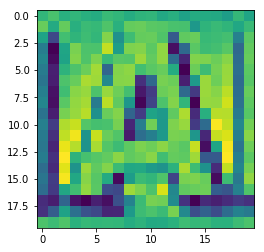

 
22
Was classified as an: A


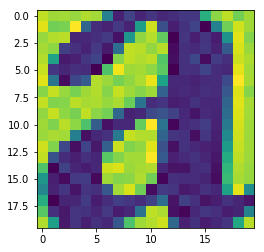

 
23
Was classified as an: A


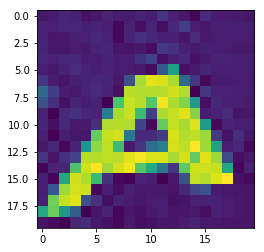

 
24
Was classified as an: A


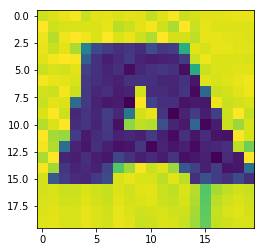

 
25
Was classified as an: A


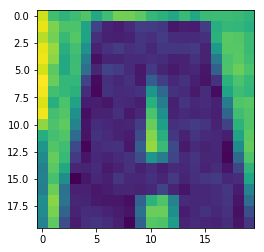

 
26
Was classified as an: A


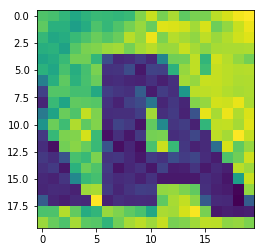

 
27
Was classified as an: A


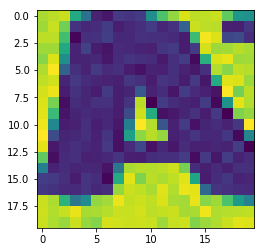

 
28
Was classified as an: A


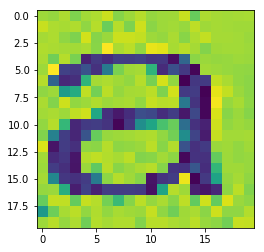

 
29
Was classified as an: A


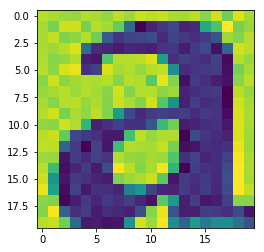

 
30
Was classified as an: A


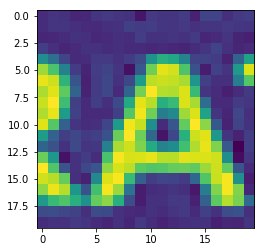

 
31
Was classified as an: A


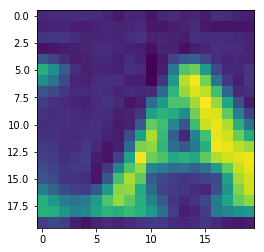

 
32
Was classified as an: A


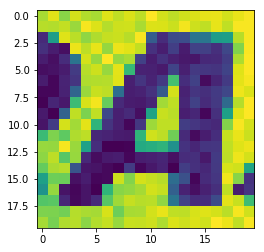

 
33
Was classified as an: O


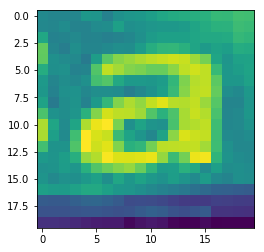

 
34
Was classified as an: A


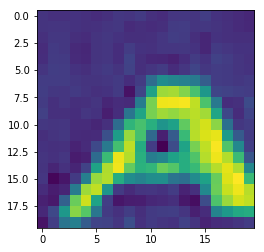

 
35
Was classified as an: A


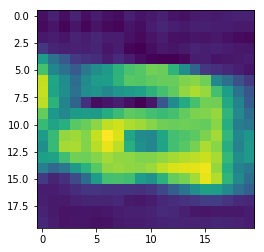

 
36
Was classified as an: A


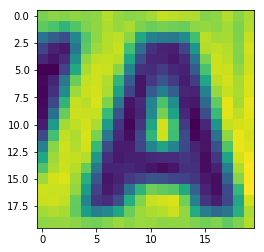

 
37
Was classified as an: A


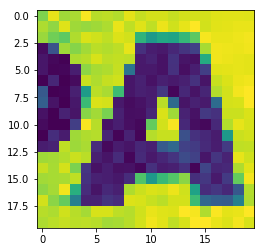

 
38
Was classified as an: A


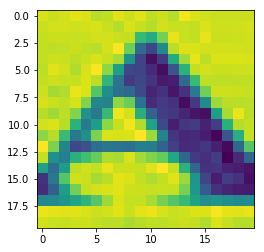

 
39
Was classified as an: A


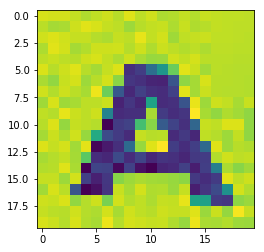

 
40
Was classified as an: A


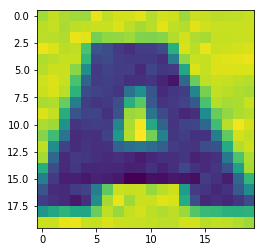

 
41
Was classified as an: A


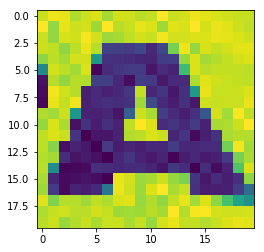

 
42
Was classified as an: A


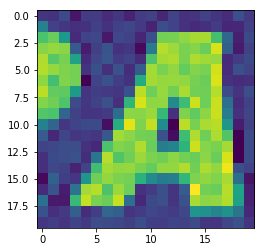

 
43
Was classified as an: A


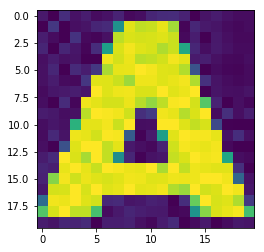

 
44
Was classified as an: I


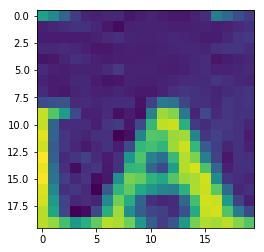

 
45
Was classified as an: A


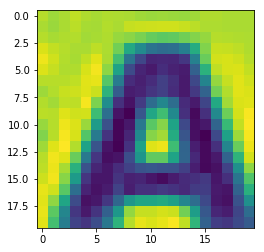

 
46
Was classified as an: A


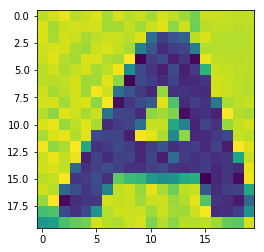

 
47
Was classified as an: A


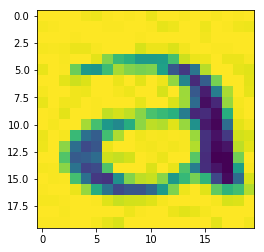

 
48
Was classified as an: A


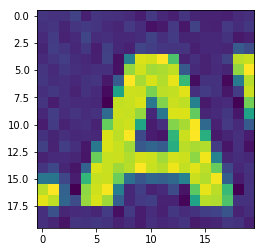

 
49
Was classified as an: A


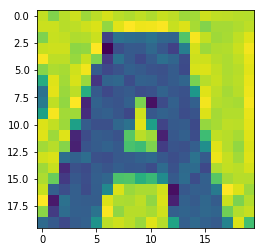

 
50
Was classified as an: C


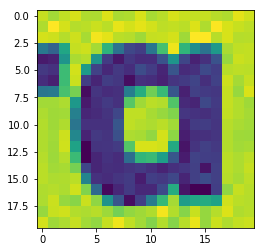

 
51
Was classified as an: A


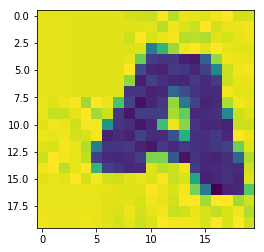

 
52
Was classified as an: A


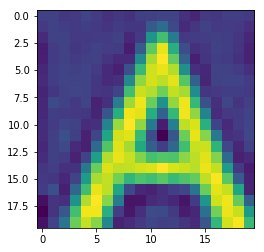

 
53
Was classified as an: A


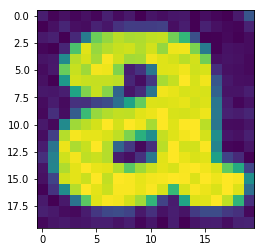

 
54
Was classified as an: A


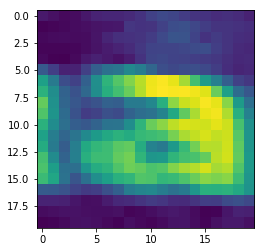

 
55
Was classified as an: A


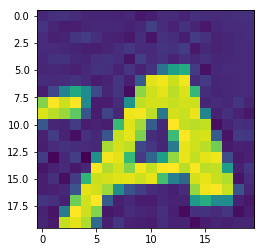

 
56
Was classified as an: A


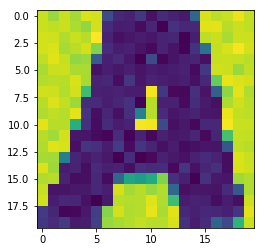

 
57
Was classified as an: A


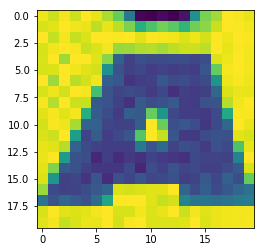

 
58
Was classified as an: A


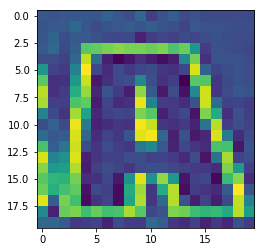

 
59
Was classified as an: A


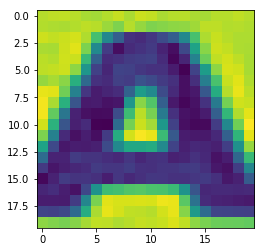

 
60
Was classified as an: A


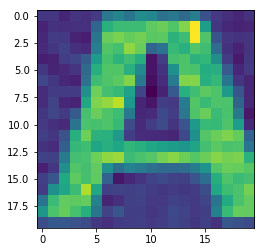

 
61
Was classified as an: A


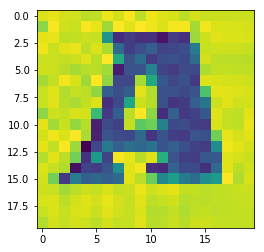

 
62
Was classified as an: A


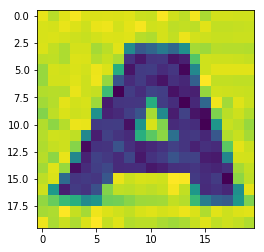

 
63
Was classified as an: I


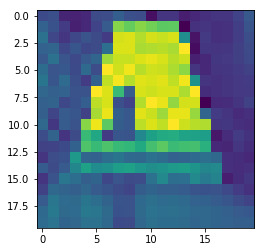

 
64
Was classified as an: A


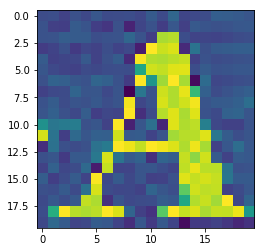

 
65
Was classified as an: A


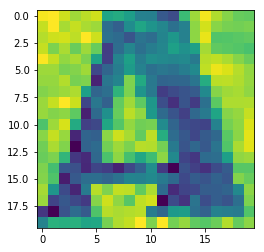

 
66
Was classified as an: A


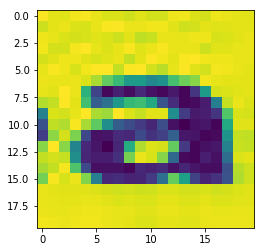

 
67
Was classified as an: A


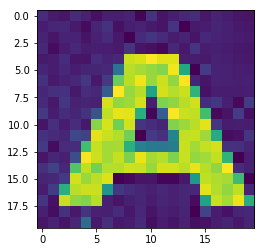

 
68
Was classified as an: R


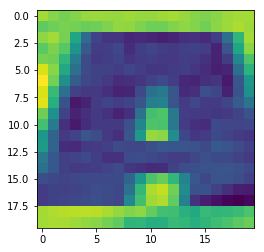

 
69
Was classified as an: A


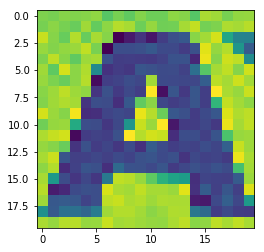

 
70
Was classified as an: A


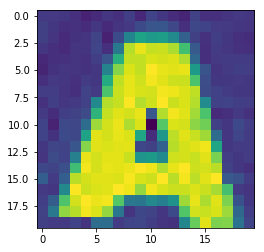

 
71
Was classified as an: A


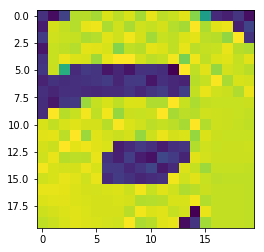

 
72
Was classified as an: A


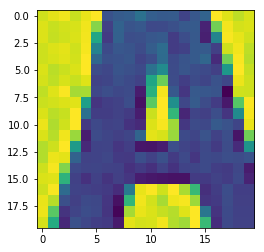

 
73
Was classified as an: A


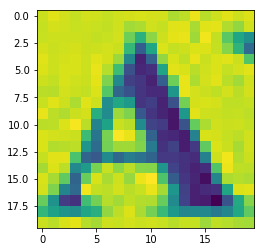

 
74
Was classified as an: A


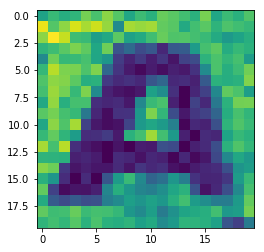

 
75
Was classified as an: A


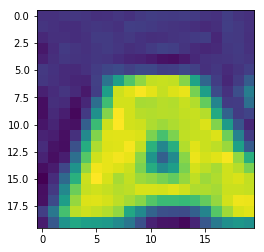

 
76
Was classified as an: A


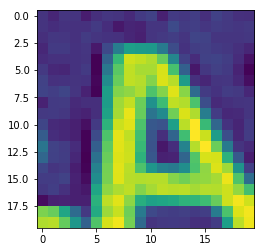

 
77
Was classified as an: A


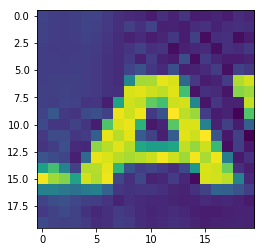

 
78
Was classified as an: A


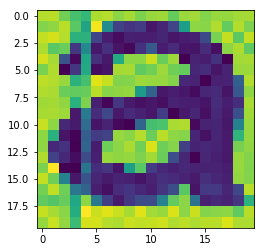

 
79
Was classified as an: A


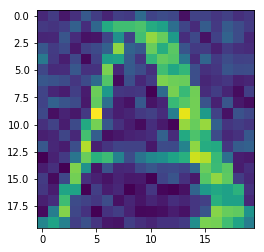

 
80
Was classified as an: A


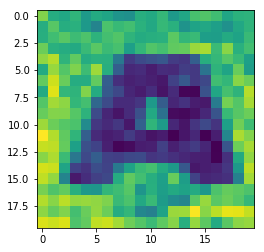

 
81
Was classified as an: A


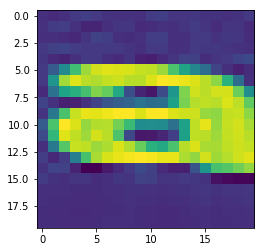

 
82
Was classified as an: O


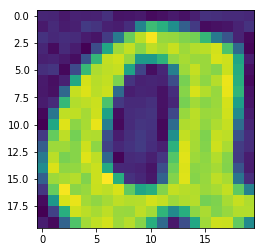

 
83
Was classified as an: A


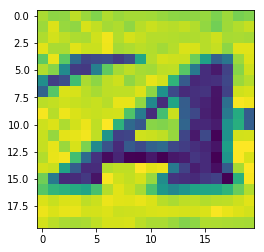

 
84
Was classified as an: A


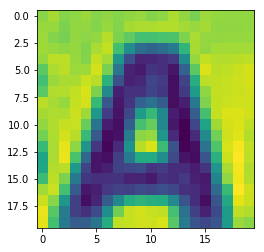

 
85
Was classified as an: A


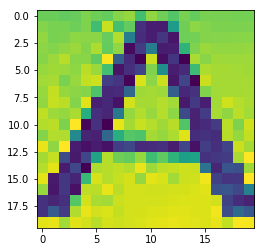

 
86
Was classified as an: A


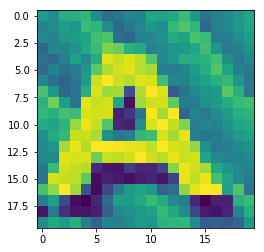

 
87
Was classified as an: A


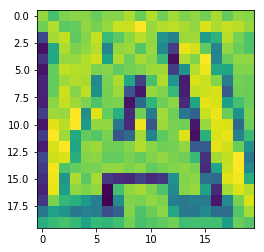

 
88
Was classified as an: A


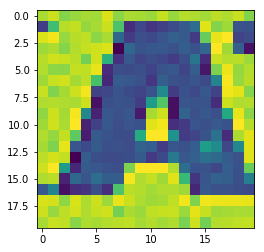

 
89
Was classified as an: A


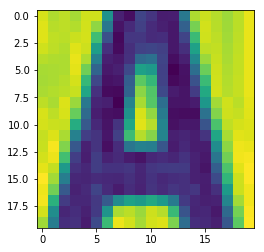

 
90
Was classified as an: A


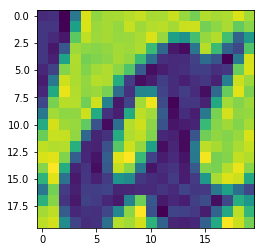

 
91
Was classified as an: A


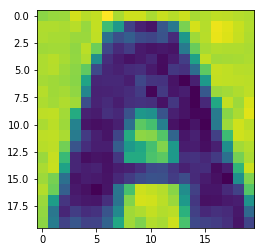

 
92
Was classified as an: A


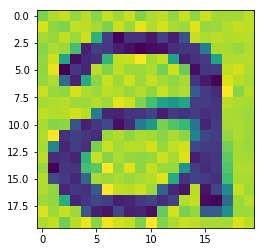

 
93
Was classified as an: A


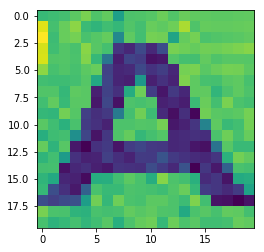

 
94
Was classified as an: A


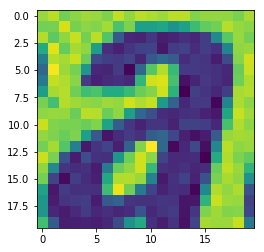

 
95
Was classified as an: A


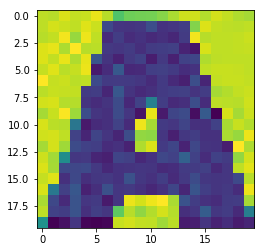

 
96
Was classified as an: A


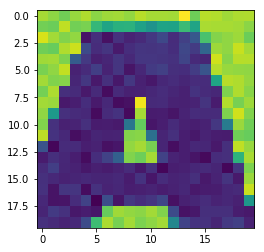

 
97
Was classified as an: A


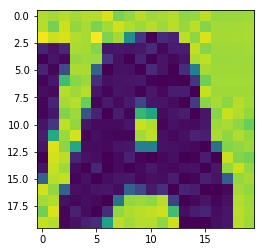

 
98
Was classified as an: A


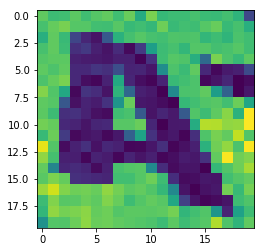

 
99
Was classified as an: K


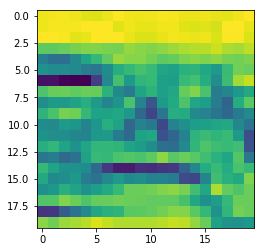

 
100
Was classified as an: A


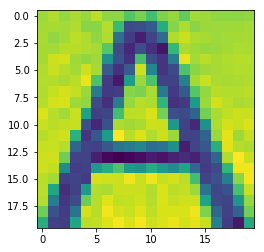

 
101
Was classified as an: A


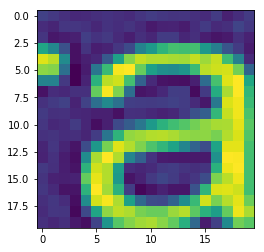

 
102
Was classified as an: R


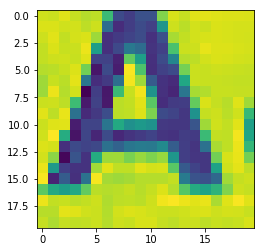

 
103
Was classified as an: A


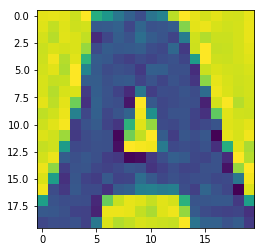

 
104
Was classified as an: A


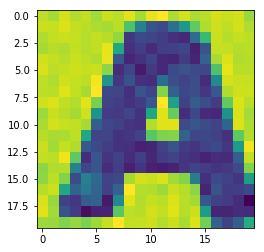

 
105
Was classified as an: A


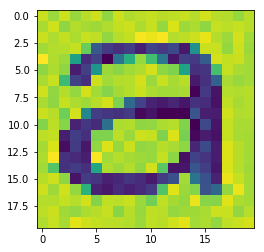

 
106
Was classified as an: A


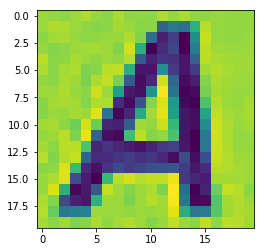

 
107
Was classified as an: O


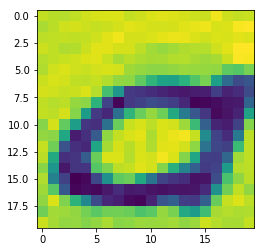

 
108
Was classified as an: A


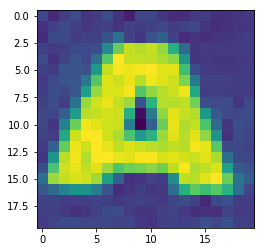

 
109
Was classified as an: A


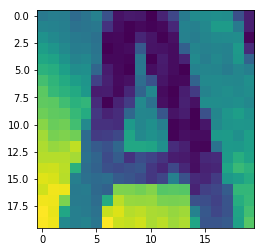

 
110
Was classified as an: A


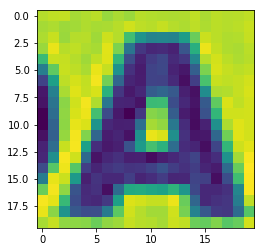

 
111
Was classified as an: A


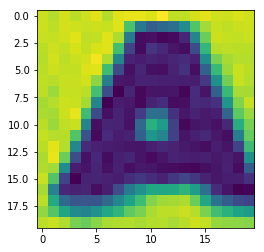

 
112
Was classified as an: S


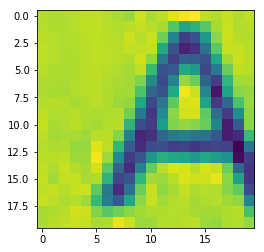

 
113
Was classified as an: R


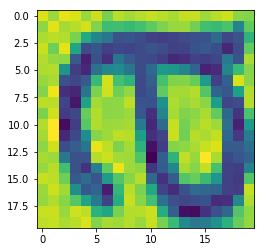

 
114
Was classified as an: A


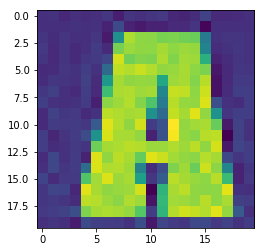

 
115
Was classified as an: A


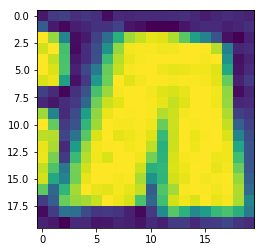

 
116
Was classified as an: Z


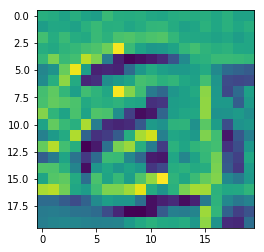

 
117
Was classified as an: A


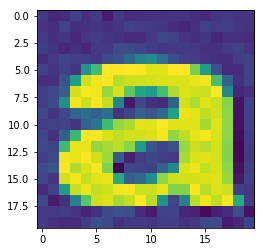

 
118
Was classified as an: A


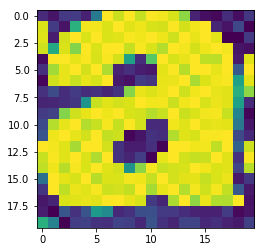

 
119
Was classified as an: A


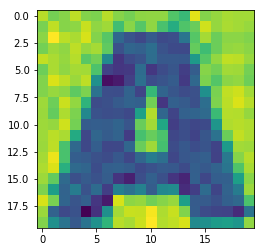

 
120
Was classified as an: R


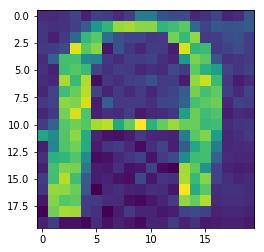

 
121
Was classified as an: O


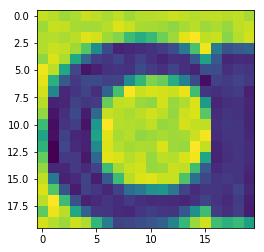

 
122
Was classified as an: A


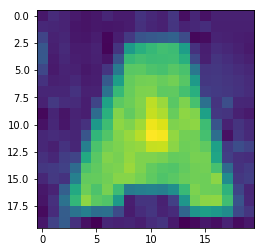

 
123
Was classified as an: A


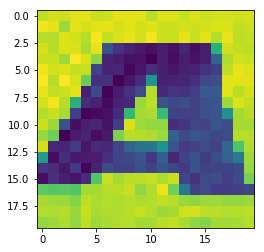

 
124
Was classified as an: A


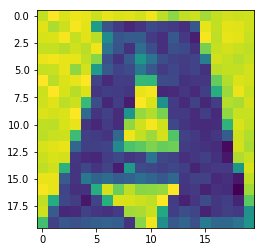

 
125
Was classified as an: N


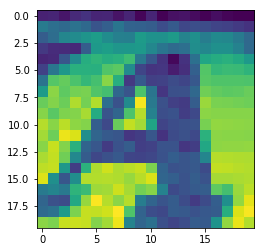

 
126
Was classified as an: A


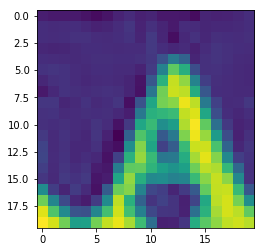

 
127
Was classified as an: A


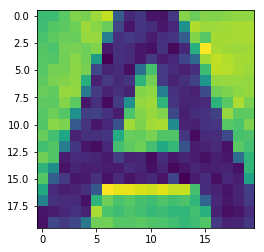

 
128
Was classified as an: A


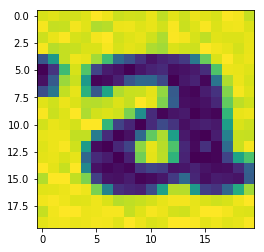

 
129
Was classified as an: A


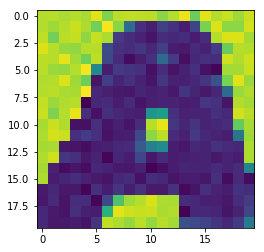

 
130
Was classified as an: A


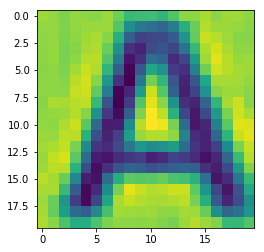

 
131
Was classified as an: A


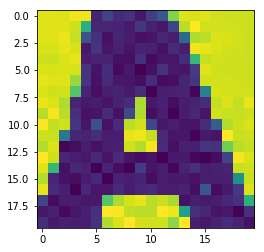

 
132
Was classified as an: A


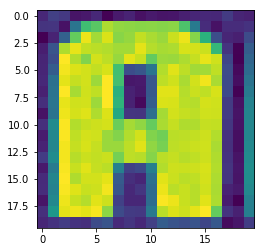

 
133
Was classified as an: A


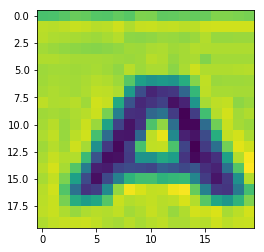

 
134
Was classified as an: A


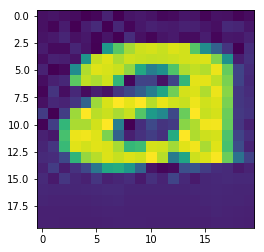

 
135
Was classified as an: A


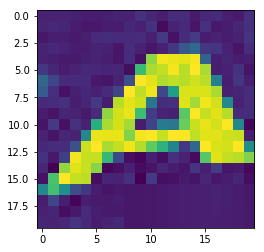

 
136
Was classified as an: A


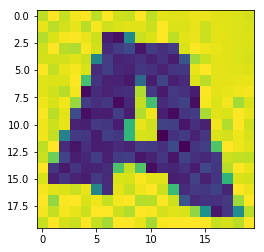

 
137
Was classified as an: A


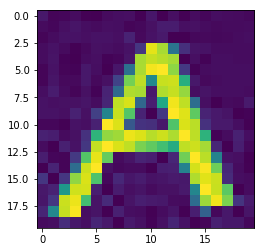

 
138
Was classified as an: A


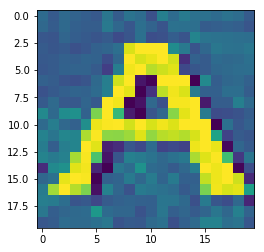

 
139
Was classified as an: A


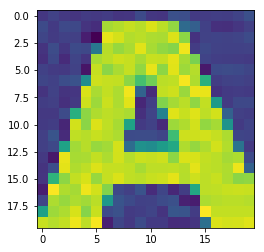

 
140
Was classified as an: A


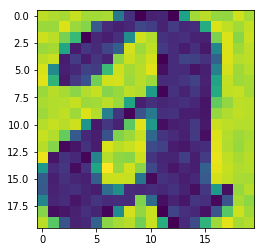

 
141
Was classified as an: A


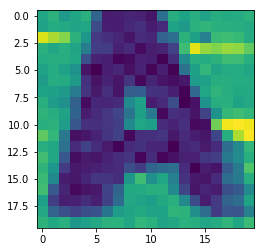

 
142
Was classified as an: B


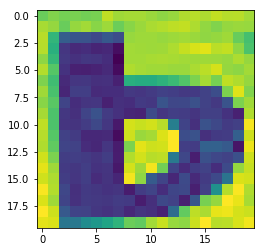

 
143
Was classified as an: B


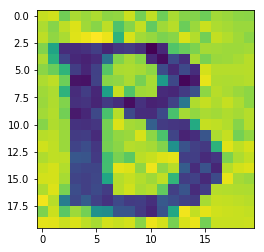

 
144
Was classified as an: R


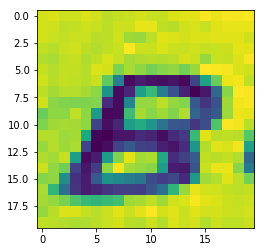

 
145
Was classified as an: T


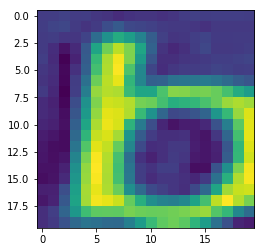

 
146
Was classified as an: B


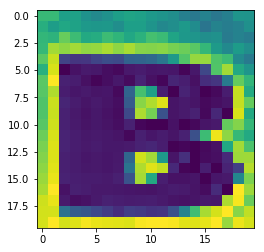

 
147
Was classified as an: A


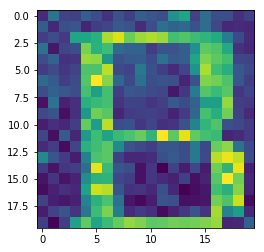

 
148
Was classified as an: B


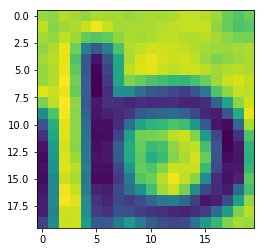

 
149
Was classified as an: F


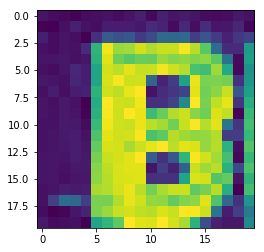

 
150
Was classified as an: R


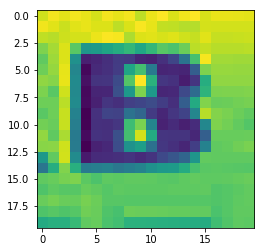

 
151
Was classified as an: E


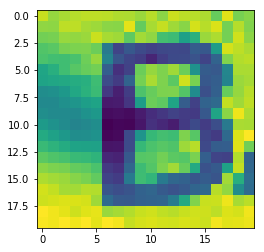

 
152
Was classified as an: B


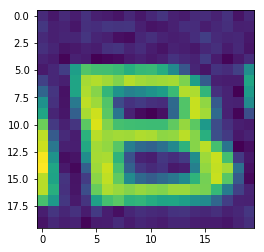

 
153
Was classified as an: O


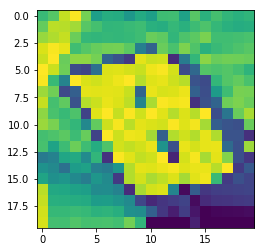

 
154
Was classified as an: H


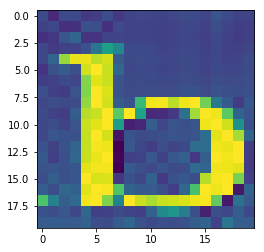

 
155
Was classified as an: E


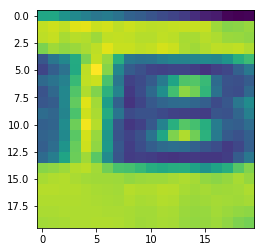

 
156
Was classified as an: B


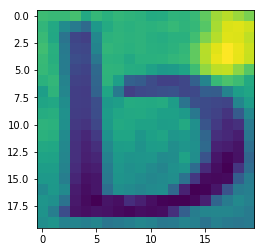

 
157
Was classified as an: E


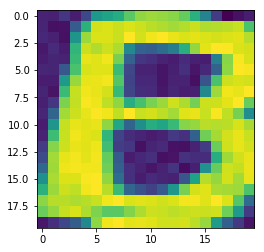

 
158
Was classified as an: B


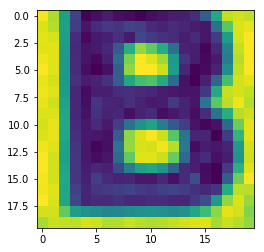

 
159
Was classified as an: R


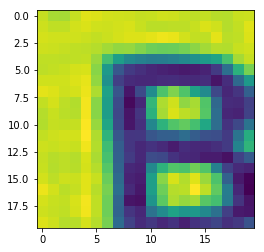

 
160
Was classified as an: D


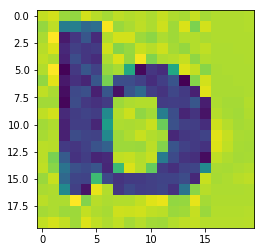

 
161
Was classified as an: H


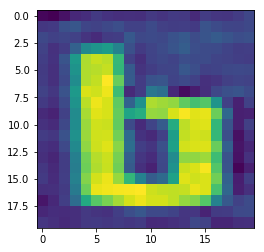

 
162
Was classified as an: B


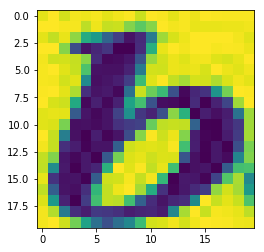

 
163
Was classified as an: B


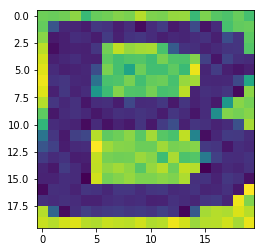

 
164
Was classified as an: B


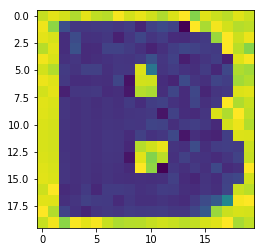

 
165
Was classified as an: D


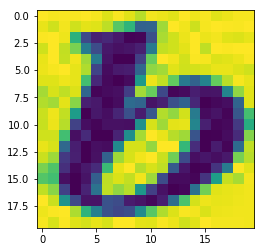

 
166
Was classified as an: B


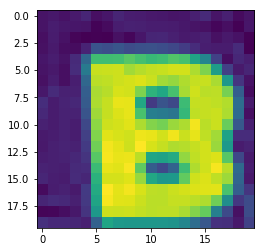

 
167
Was classified as an: H


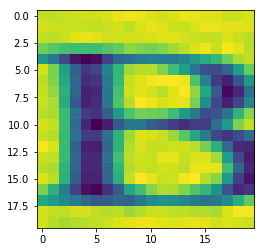

 
168
Was classified as an: R


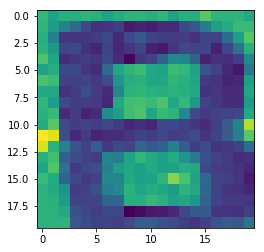

 
169
Was classified as an: R


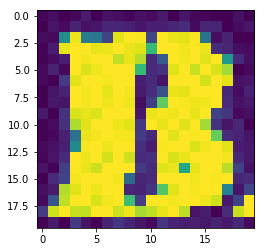

 
170
Was classified as an: B


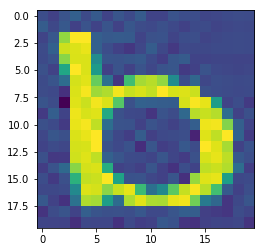

 
171
Was classified as an: B


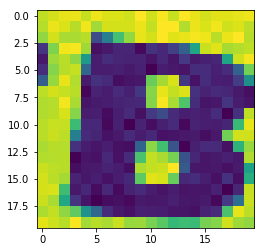

 
172
Was classified as an: R


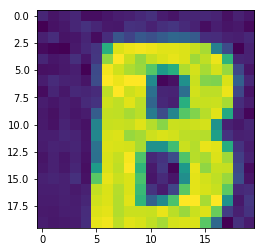

 
173
Was classified as an: C


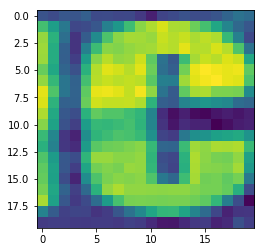

 
174
Was classified as an: C


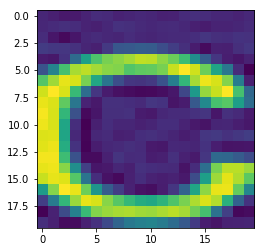

 
175
Was classified as an: C


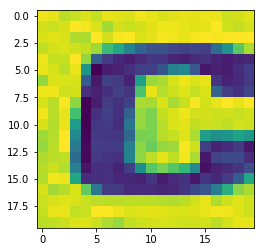

 
176
Was classified as an: C


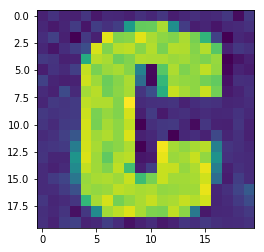

 
177
Was classified as an: C


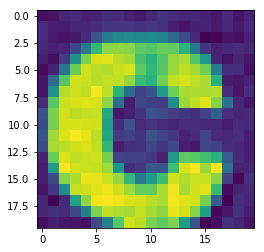

 
178
Was classified as an: C


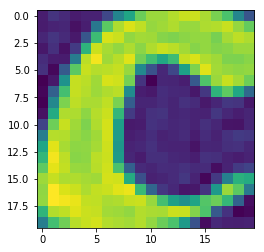

 
179
Was classified as an: C


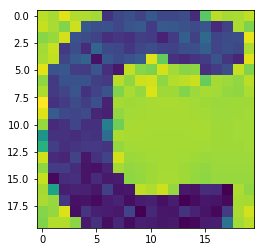

 
180
Was classified as an: C


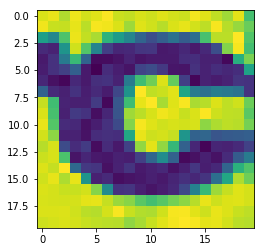

 
181
Was classified as an: C


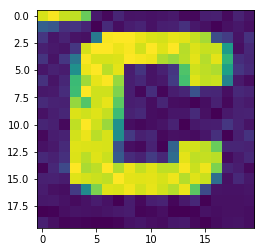

 
182
Was classified as an: C


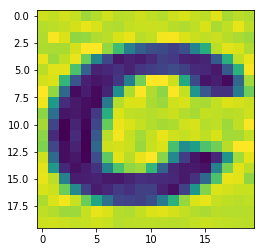

 
183
Was classified as an: C


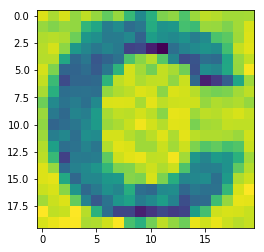

 
184
Was classified as an: C


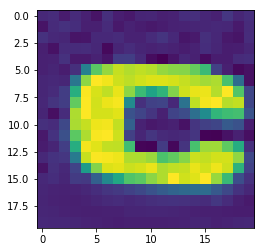

 
185
Was classified as an: C


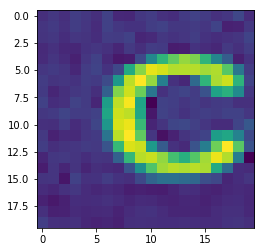

 
186
Was classified as an: C


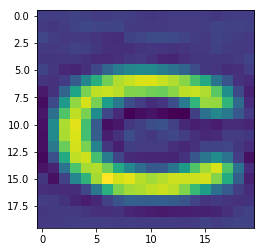

 
187
Was classified as an: C


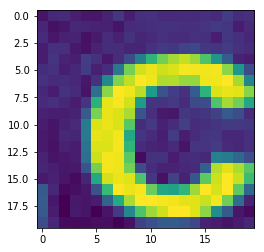

 
188
Was classified as an: C


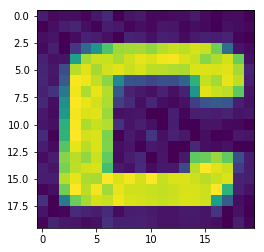

 
189
Was classified as an: C


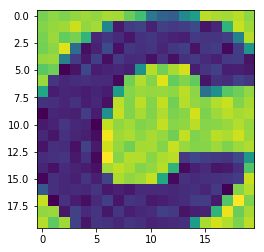

 
190
Was classified as an: G


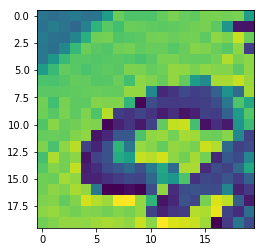

 
191
Was classified as an: C


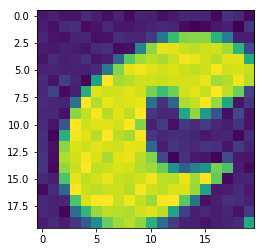

 
192
Was classified as an: C


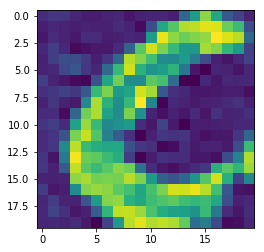

 
193
Was classified as an: C


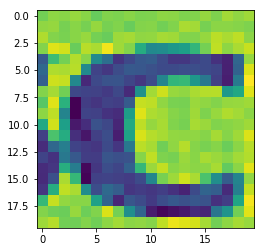

 
194
Was classified as an: C


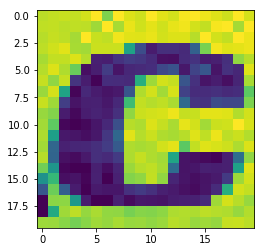

 
195
Was classified as an: C


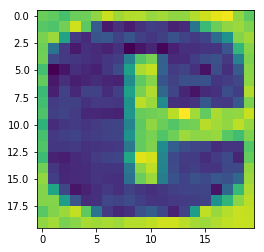

 
196
Was classified as an: C


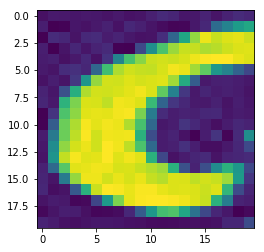

 
197
Was classified as an: C


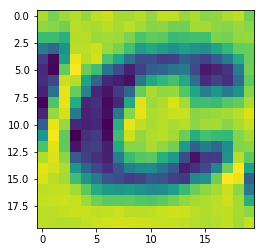

 
198
Was classified as an: C


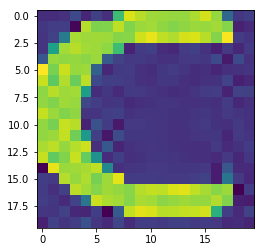

 
199
Was classified as an: C


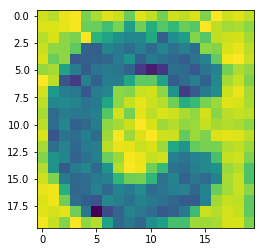

 
200
Was classified as an: C


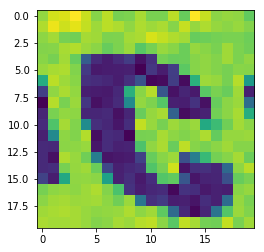

 
201
Was classified as an: C


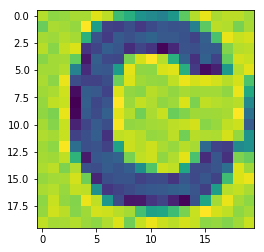

 
202
Was classified as an: C


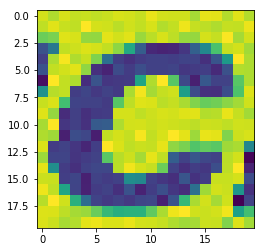

 
203
Was classified as an: C


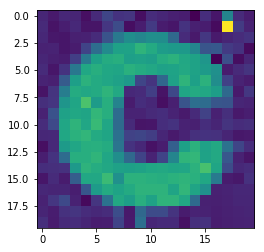

 
204
Was classified as an: C


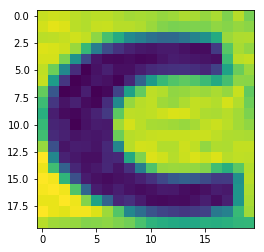

 
205
Was classified as an: C


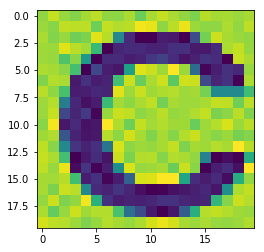

 
206
Was classified as an: C


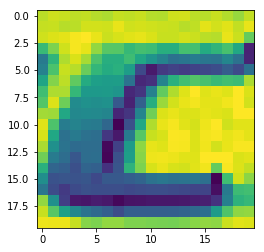

 
207
Was classified as an: C


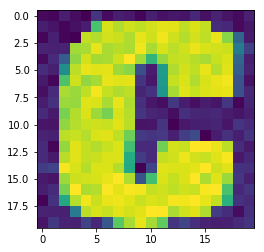

 
208
Was classified as an: C


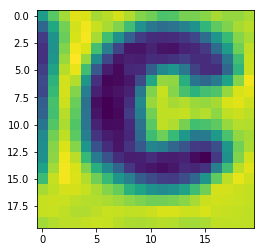

 
209
Was classified as an: C


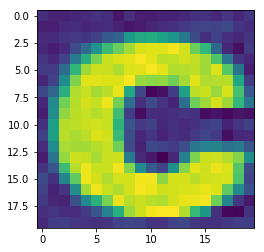

 
210
Was classified as an: C


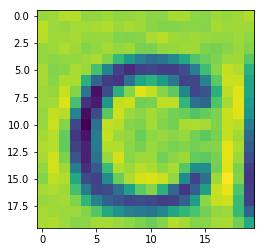

 
211
Was classified as an: R


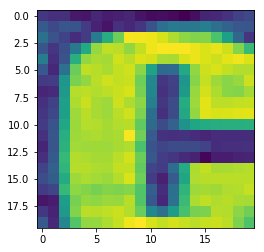

 
212
Was classified as an: C


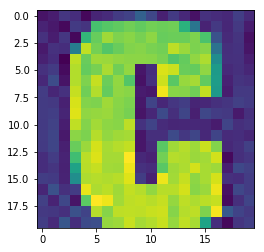

 
213
Was classified as an: C


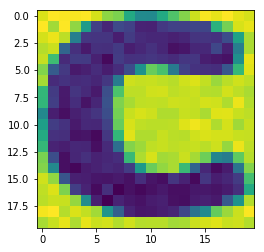

 
214
Was classified as an: C


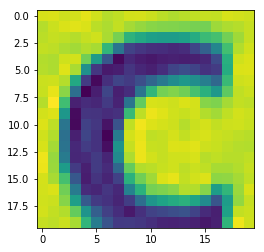

 
215
Was classified as an: C


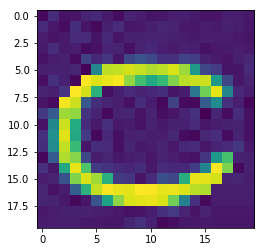

 
216
Was classified as an: C


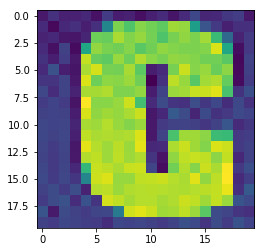

 
217
Was classified as an: O


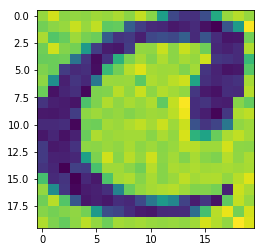

 
218
Was classified as an: C


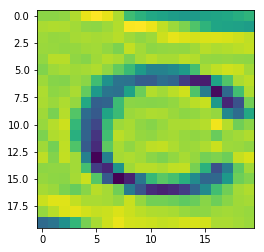

 
219
Was classified as an: C


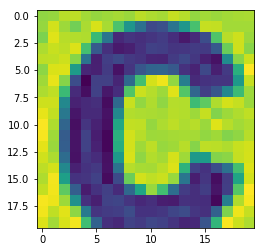

 
220
Was classified as an: C


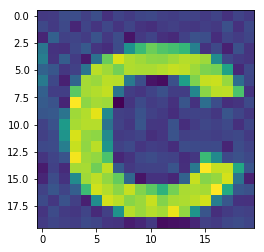

 
221
Was classified as an: C


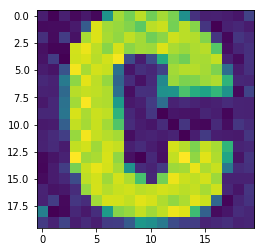

 
222
Was classified as an: C


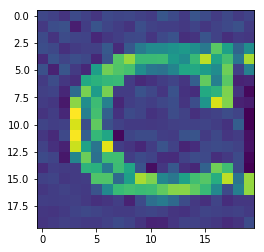

 
223
Was classified as an: C


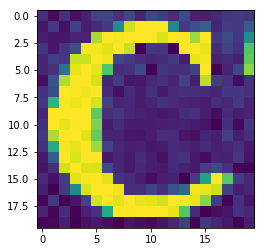

 
224
Was classified as an: O


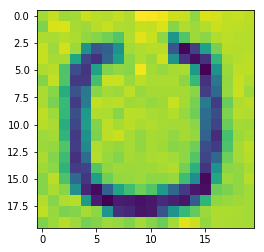

 
225
Was classified as an: C


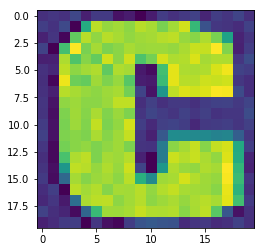

 
226
Was classified as an: C


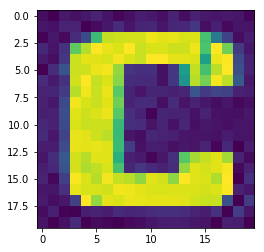

 
227
Was classified as an: E


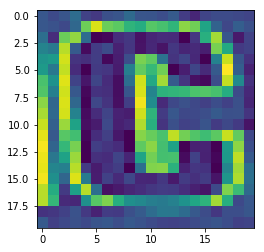

 
228
Was classified as an: C


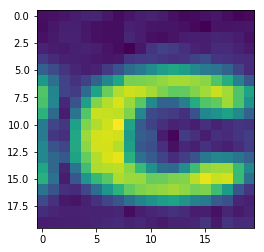

 
229
Was classified as an: D


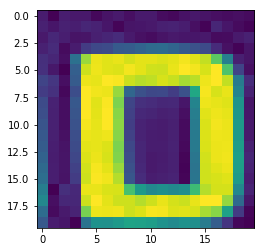

 
230
Was classified as an: D


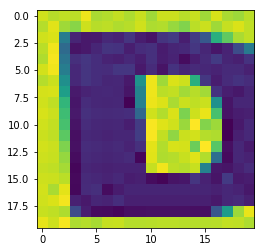

 
231
Was classified as an: D


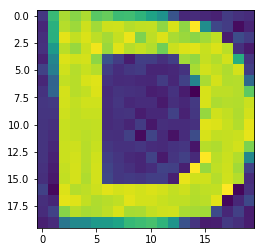

 
232
Was classified as an: D


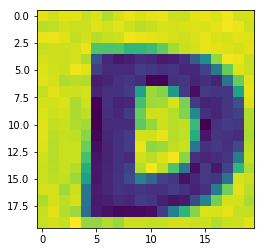

 
233
Was classified as an: D


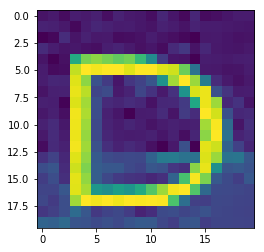

 
234
Was classified as an: D


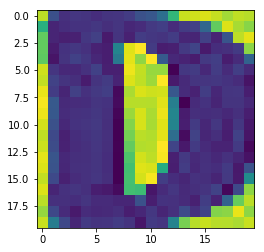

 
235
Was classified as an: D


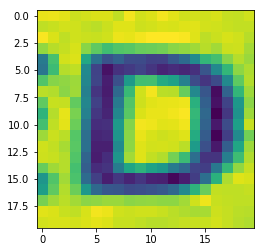

 
236
Was classified as an: D


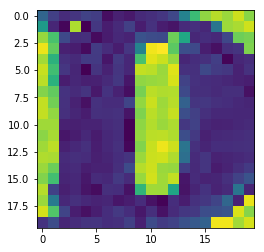

 
237
Was classified as an: D


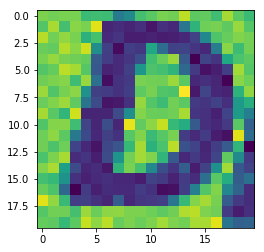

 
238
Was classified as an: D


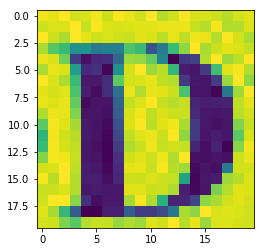

 
239
Was classified as an: D


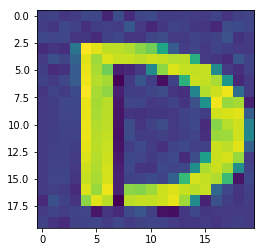

 
240
Was classified as an: O


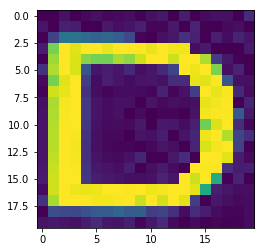

 
241
Was classified as an: O


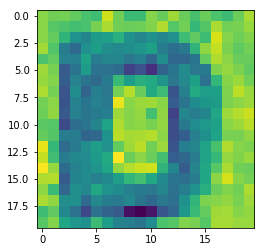

 
242
Was classified as an: D


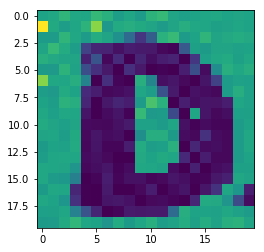

 
243
Was classified as an: D


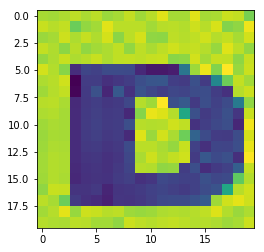

 
244
Was classified as an: O


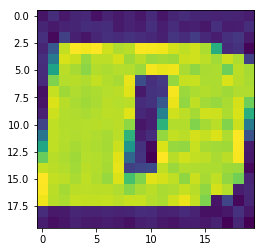

 
245
Was classified as an: D


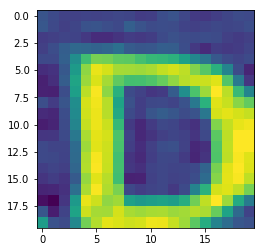

 
246
Was classified as an: D


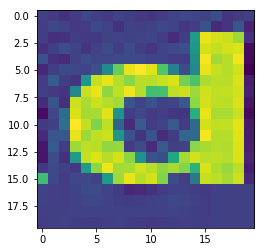

 
247
Was classified as an: D


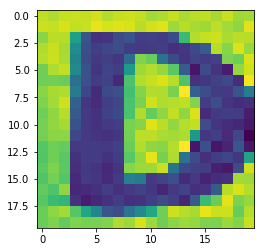

 
248
Was classified as an: D


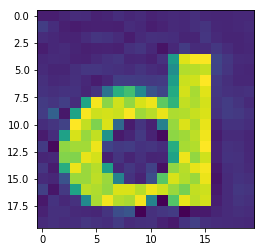

 
249
Was classified as an: D


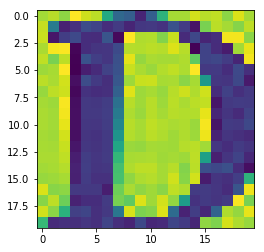

 
250
Was classified as an: D


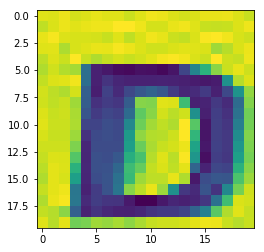

 
251
Was classified as an: D


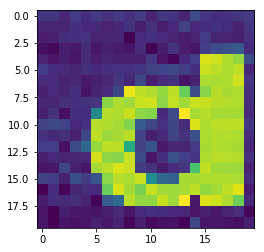

 
252
Was classified as an: D


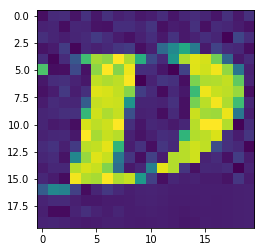

 
253
Was classified as an: D


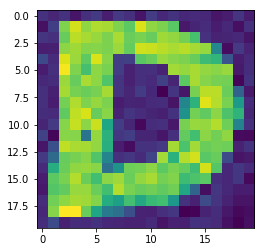

 
254
Was classified as an: D


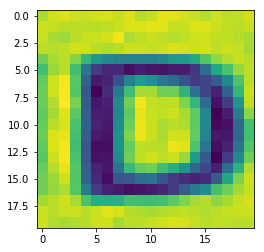

 
255
Was classified as an: D


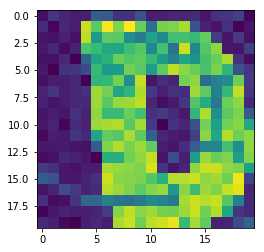

 
256
Was classified as an: D


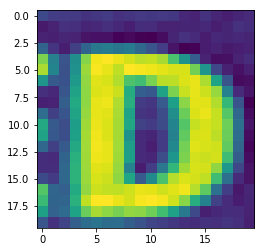

 
257
Was classified as an: D


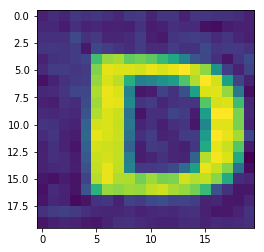

 
258
Was classified as an: N


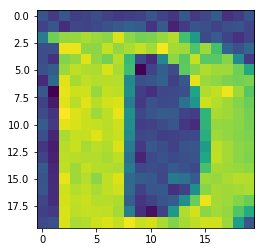

 
259
Was classified as an: D


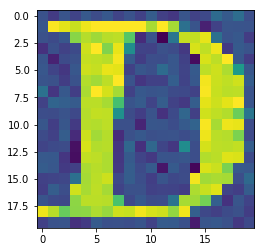

 
260
Was classified as an: O


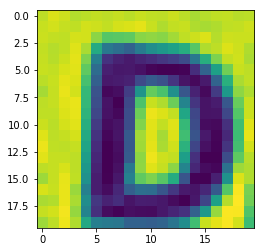

 
261
Was classified as an: D


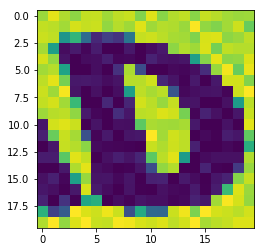

 
262
Was classified as an: H


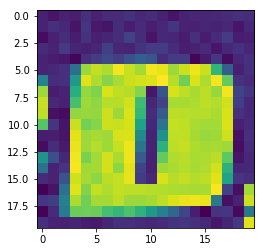

 
263
Was classified as an: O


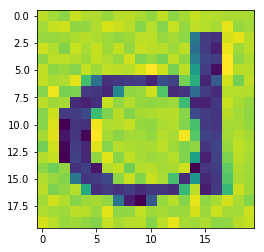

 
264
Was classified as an: D


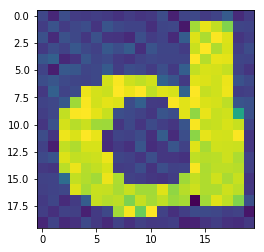

 
265
Was classified as an: T


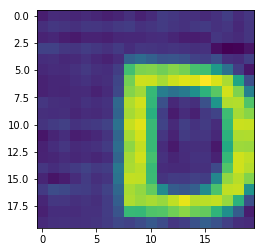

 
266
Was classified as an: D


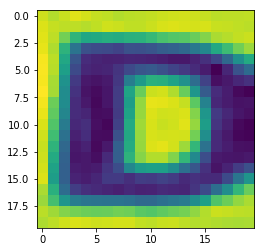

 
267
Was classified as an: O


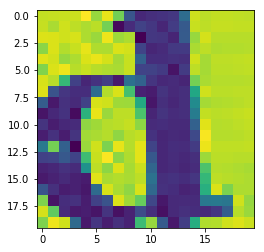

 
268
Was classified as an: R


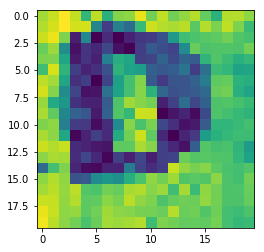

 
269
Was classified as an: N


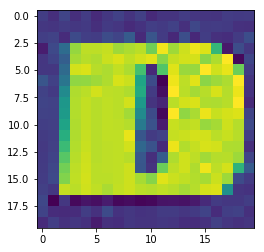

 
270
Was classified as an: D


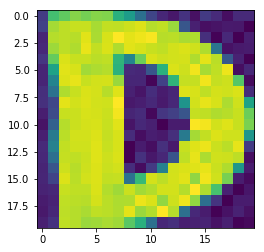

 
271
Was classified as an: D


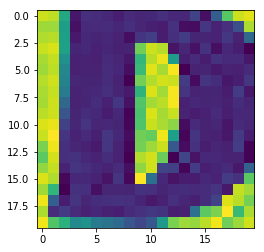

 
272
Was classified as an: D


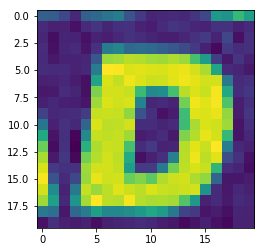

 
273
Was classified as an: D


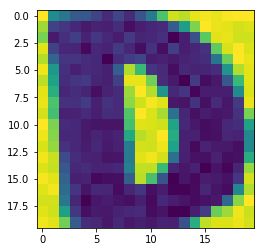

 
274
Was classified as an: D


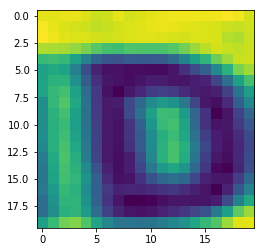

 
275
Was classified as an: C


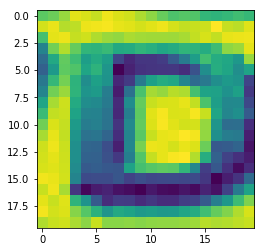

 
276
Was classified as an: D


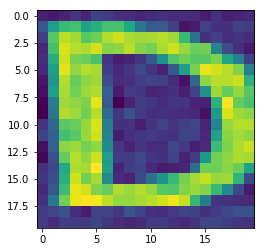

 
277
Was classified as an: E


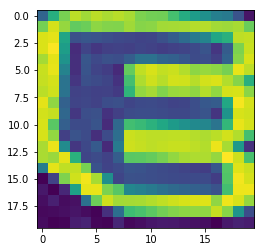

 
278
Was classified as an: E


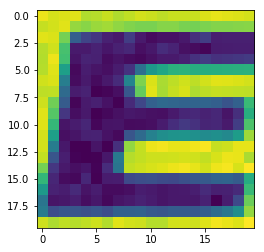

 
279
Was classified as an: F


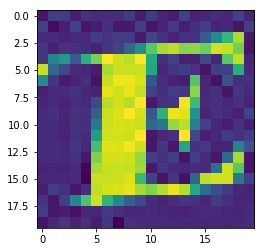

 
280
Was classified as an: E


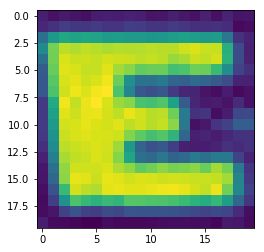

 
281
Was classified as an: E


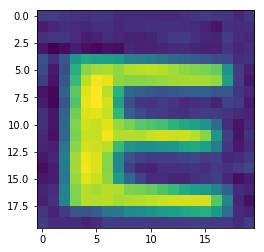

 
282
Was classified as an: E


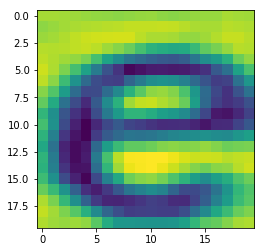

 
283
Was classified as an: E


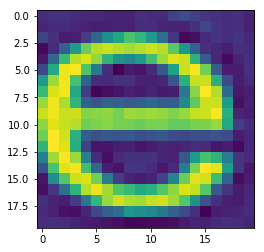

 
284
Was classified as an: E


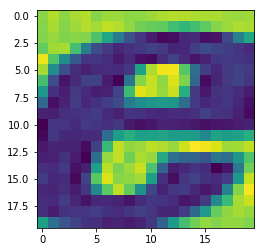

 
285
Was classified as an: E


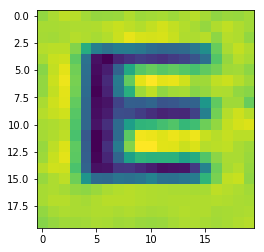

 
286
Was classified as an: E


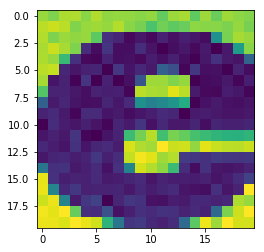

 
287
Was classified as an: E


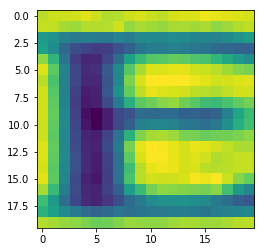

 
288
Was classified as an: T


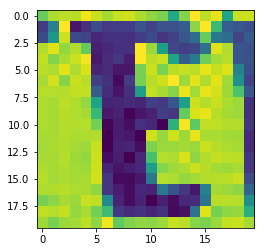

 
289
Was classified as an: E


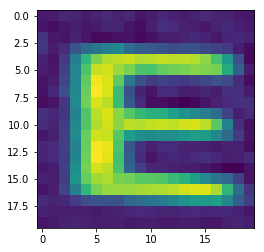

 
290
Was classified as an: E


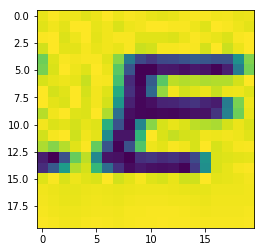

 
291
Was classified as an: E


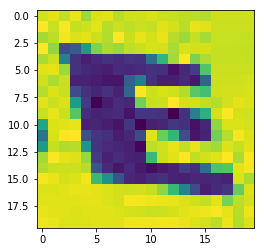

 
292
Was classified as an: A


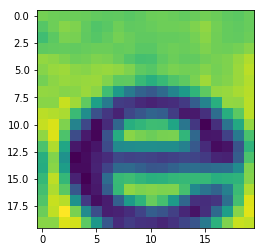

 
293
Was classified as an: E


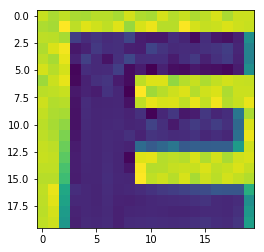

 
294
Was classified as an: E


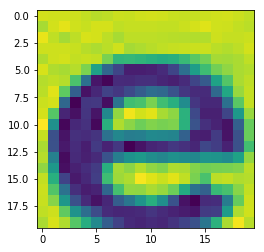

 
295
Was classified as an: E


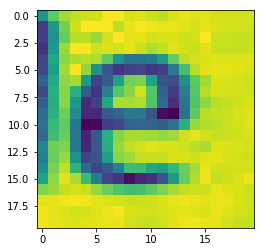

 
296
Was classified as an: E


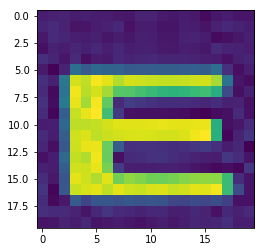

 
297
Was classified as an: E


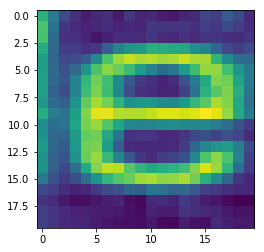

 
298
Was classified as an: E


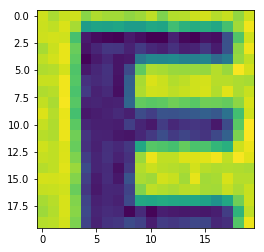

 
299
Was classified as an: E


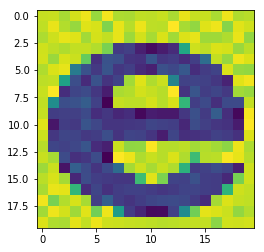

 
300
Was classified as an: E


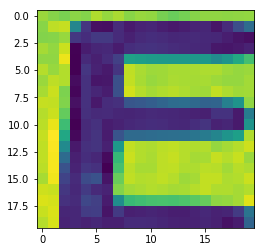

 
301
Was classified as an: E


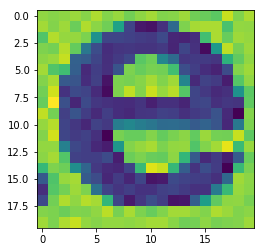

 
302
Was classified as an: I


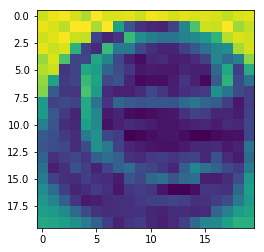

 
303
Was classified as an: E


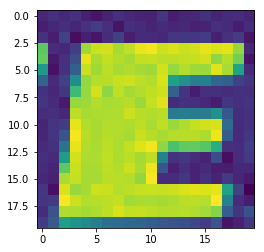

 
304
Was classified as an: E


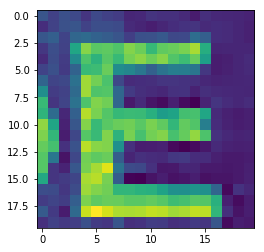

 
305
Was classified as an: E


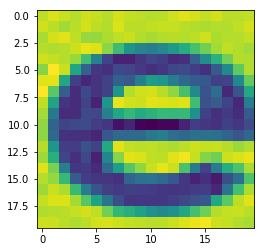

 
306
Was classified as an: E


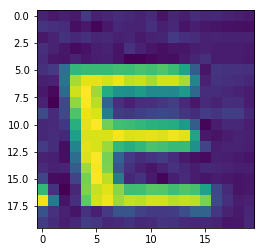

 
307
Was classified as an: E


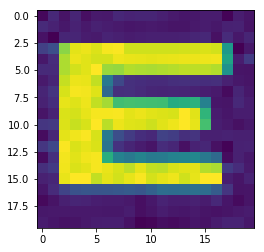

 
308
Was classified as an: E


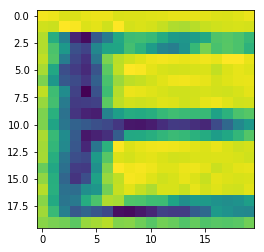

 
309
Was classified as an: E


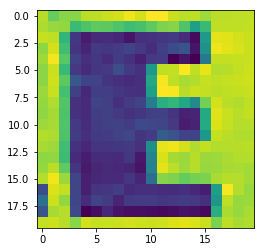

 
310
Was classified as an: E


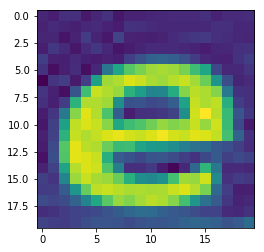

 
311
Was classified as an: E


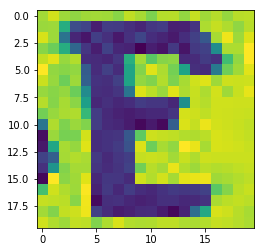

 
312
Was classified as an: E


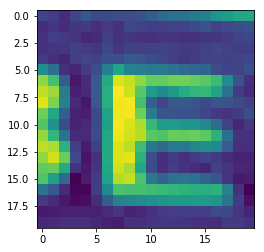

 
313
Was classified as an: R


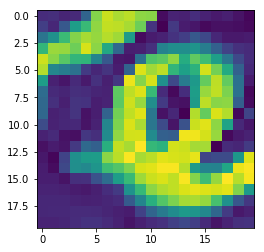

 
314
Was classified as an: E


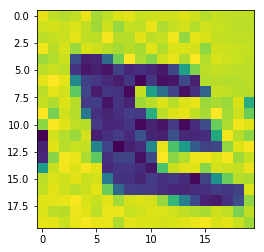

 
315
Was classified as an: E


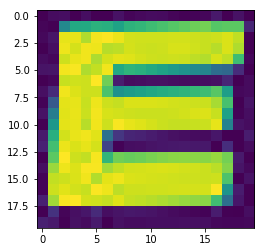

 
316
Was classified as an: E


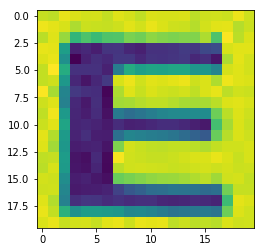

 
317
Was classified as an: E


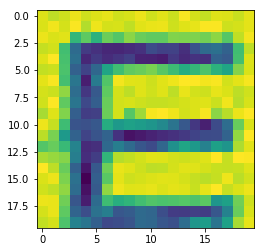

 
318
Was classified as an: E


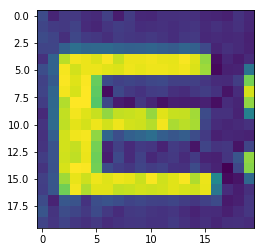

 
319
Was classified as an: E


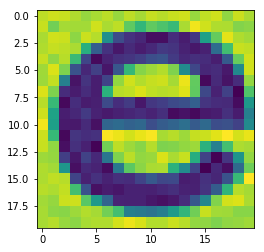

 
320
Was classified as an: E


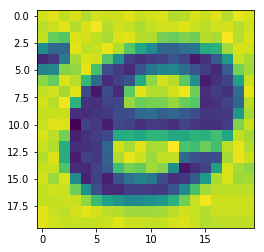

 
321
Was classified as an: E


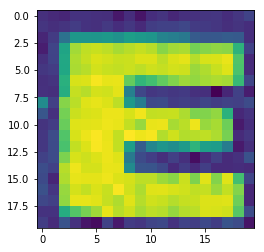

 
322
Was classified as an: E


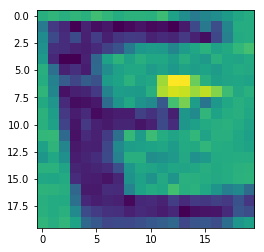

 
323
Was classified as an: E


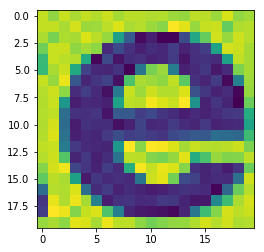

 
324
Was classified as an: R


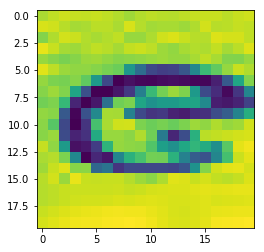

 
325
Was classified as an: E


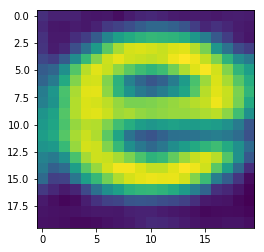

 
326
Was classified as an: E


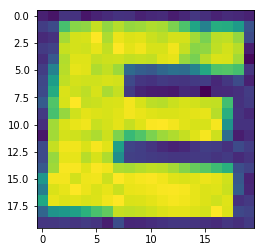

 
327
Was classified as an: E


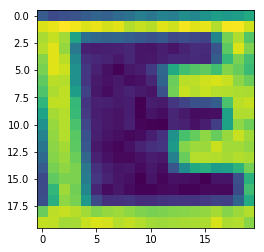

 
328
Was classified as an: E


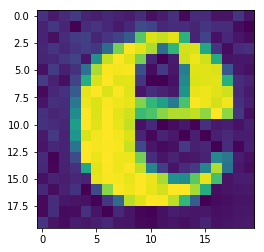

 
329
Was classified as an: E


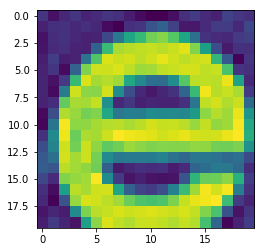

 
330
Was classified as an: E


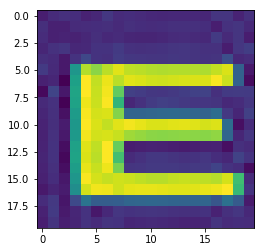

 
331
Was classified as an: E


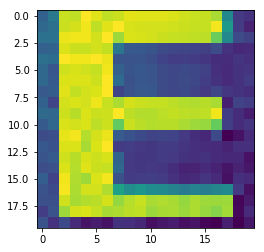

 
332
Was classified as an: E


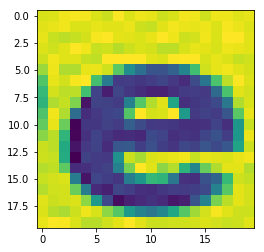

 
333
Was classified as an: E


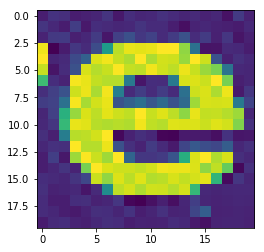

 
334
Was classified as an: E


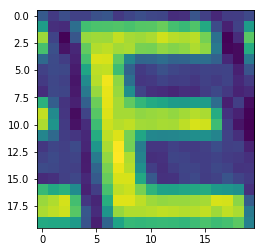

 
335
Was classified as an: E


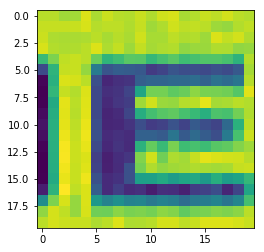

 
336
Was classified as an: E


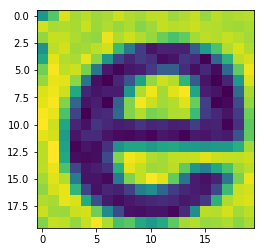

 
337
Was classified as an: R


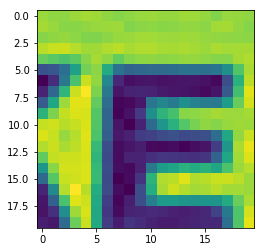

 
338
Was classified as an: E


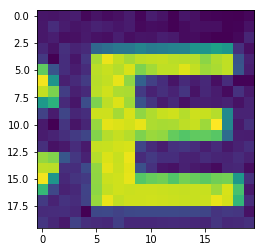

 
339
Was classified as an: E


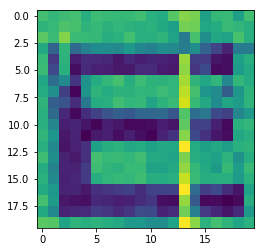

 
340
Was classified as an: E


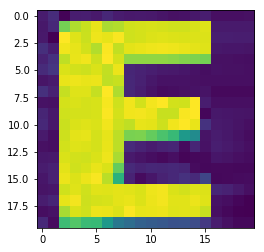

 
341
Was classified as an: E


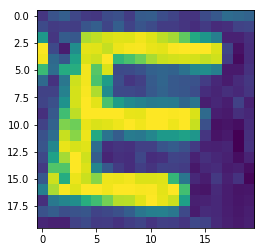

 
342
Was classified as an: E


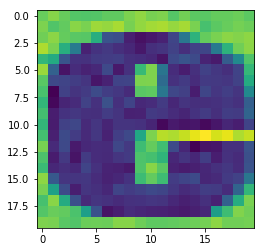

 
343
Was classified as an: E


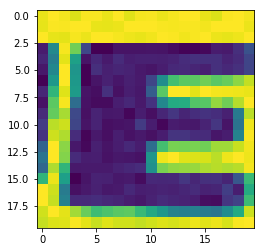

 
344
Was classified as an: E


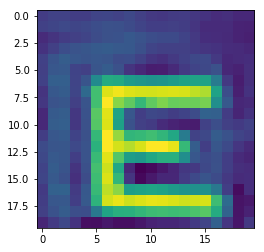

 
345
Was classified as an: E


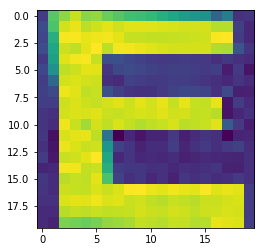

 
346
Was classified as an: R


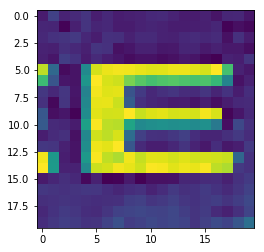

 
347
Was classified as an: R


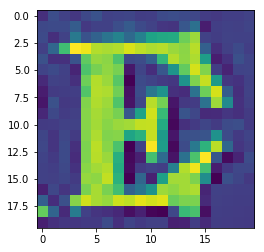

 
348
Was classified as an: E


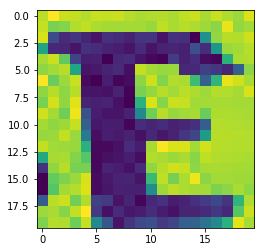

 
349
Was classified as an: E


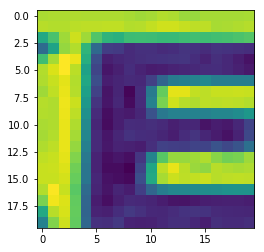

 
350
Was classified as an: E


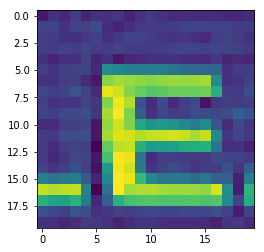

 
351
Was classified as an: E


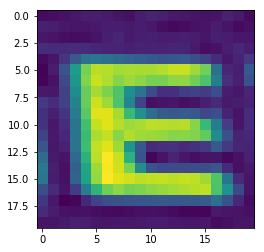

 
352
Was classified as an: E


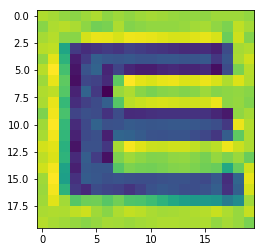

 
353
Was classified as an: R


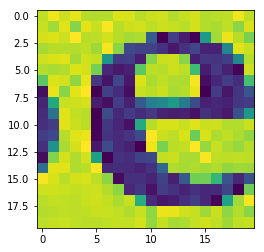

 
354
Was classified as an: E


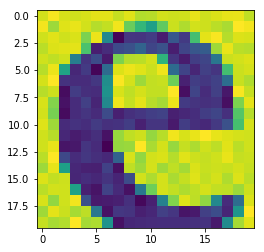

 
355
Was classified as an: E


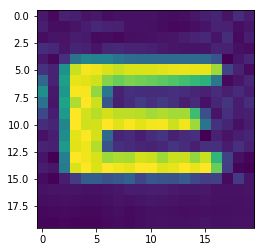

 
356
Was classified as an: R


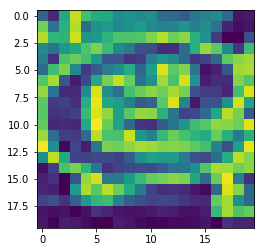

 
357
Was classified as an: E


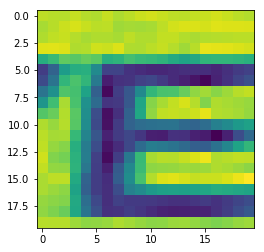

 
358
Was classified as an: T


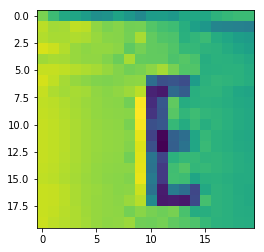

 
359
Was classified as an: E


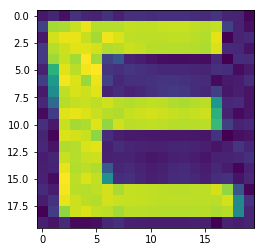

 
360
Was classified as an: E


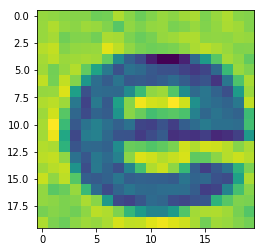

 
361
Was classified as an: E


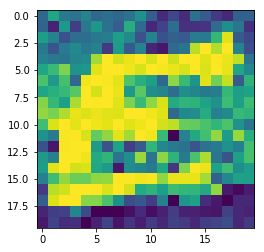

 
362
Was classified as an: E


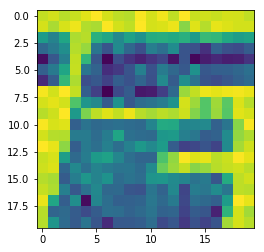

 
363
Was classified as an: E


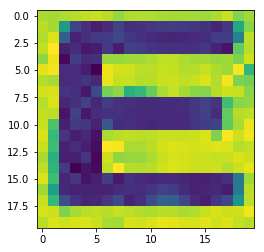

 
364
Was classified as an: E


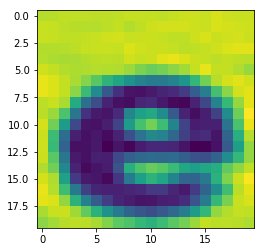

 
365
Was classified as an: E


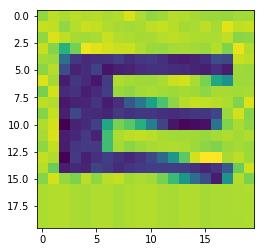

 
366
Was classified as an: E


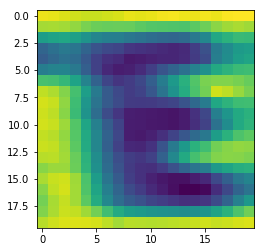

 
367
Was classified as an: R


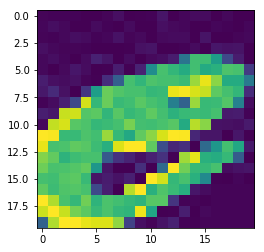

 
368
Was classified as an: E


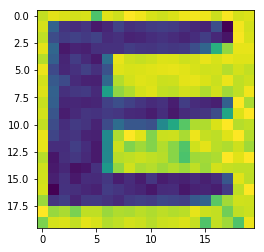

 
369
Was classified as an: E


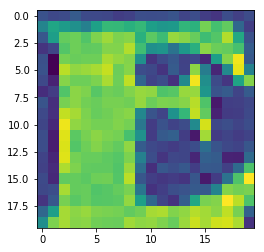

 
370
Was classified as an: E


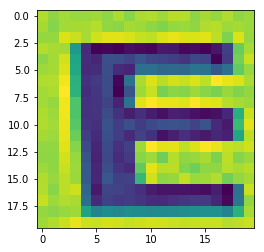

 
371
Was classified as an: E


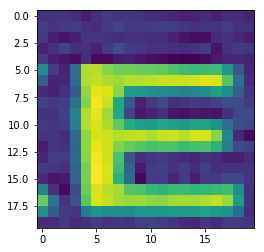

 
372
Was classified as an: E


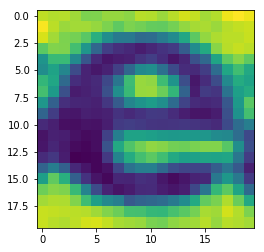

 
373
Was classified as an: E


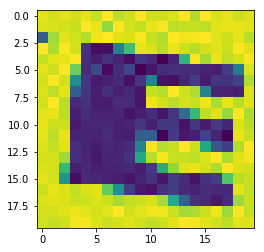

 
374
Was classified as an: E


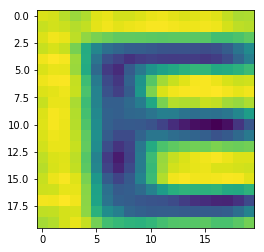

 
375
Was classified as an: E


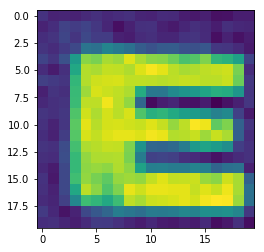

 
376
Was classified as an: E


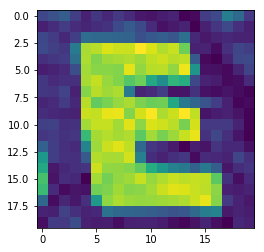

 
377
Was classified as an: E


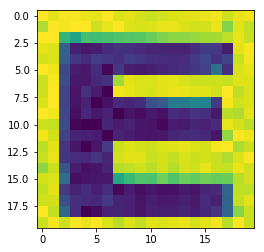

 
378
Was classified as an: E


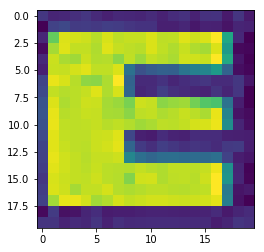

 
379
Was classified as an: E


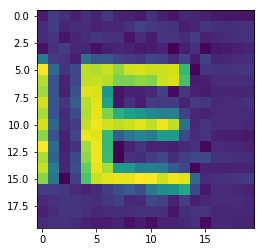

 
380
Was classified as an: E


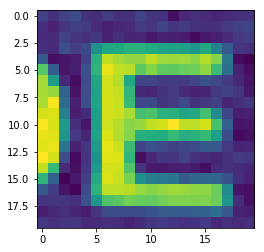

 
381
Was classified as an: E


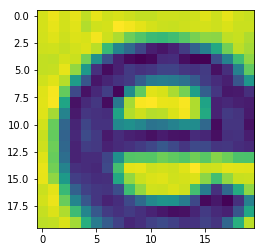

 
382
Was classified as an: E


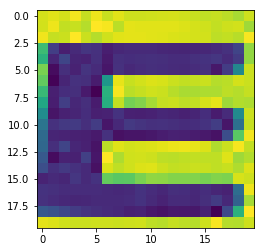

 
383
Was classified as an: E


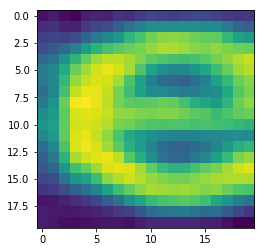

 
384
Was classified as an: E


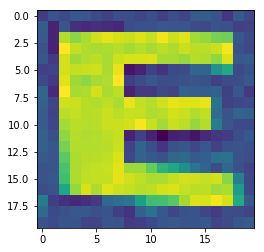

 
385
Was classified as an: E


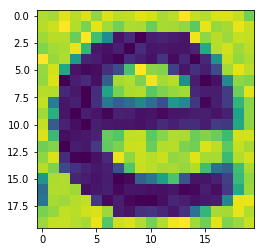

 
386
Was classified as an: E


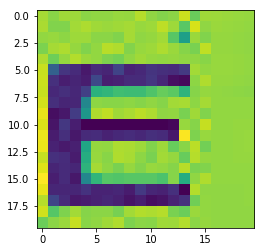

 
387
Was classified as an: E


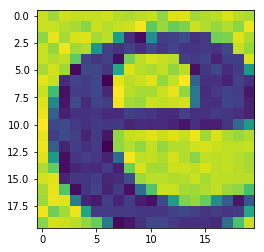

 
388
Was classified as an: E


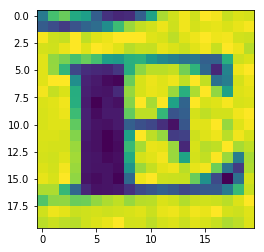

 
389
Was classified as an: E


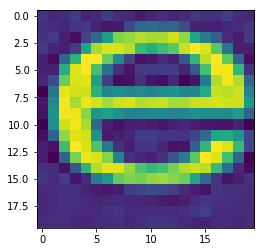

 
390
Was classified as an: E


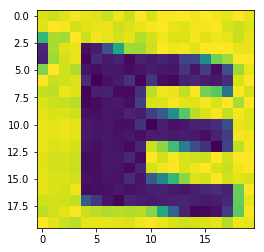

 
391
Was classified as an: E


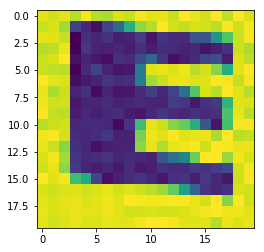

 
392
Was classified as an: E


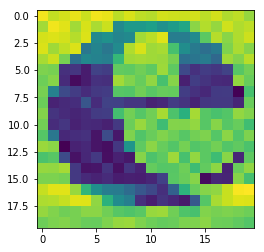

 
393
Was classified as an: E


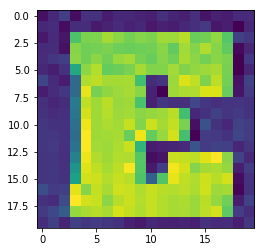

 
394
Was classified as an: E


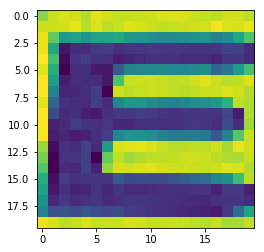

 
395
Was classified as an: E


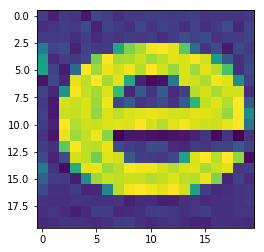

 
396
Was classified as an: E


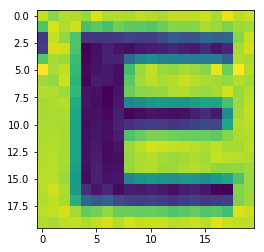

 
397
Was classified as an: E


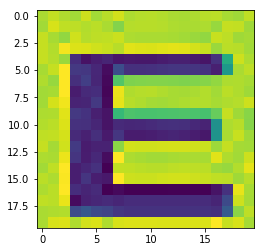

 
398
Was classified as an: E


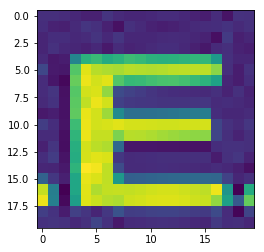

 
399
Was classified as an: E


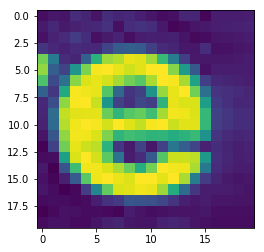

 
400
Was classified as an: E


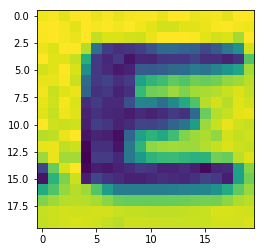

 
401
Was classified as an: D


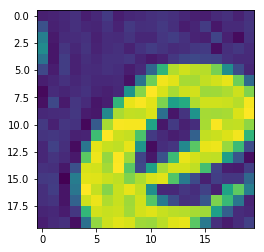

 
402
Was classified as an: R


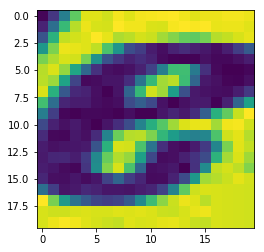

 
403
Was classified as an: E


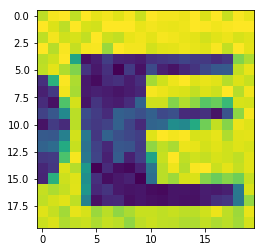

 
404
Was classified as an: G


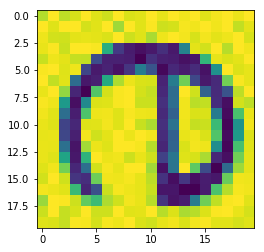

 
405
Was classified as an: E


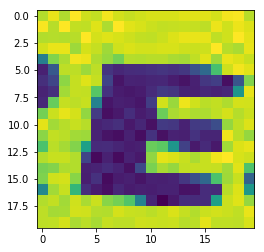

 
406
Was classified as an: E


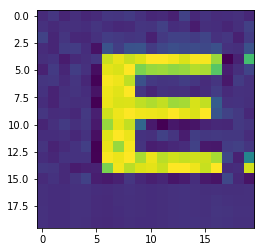

 
407
Was classified as an: A


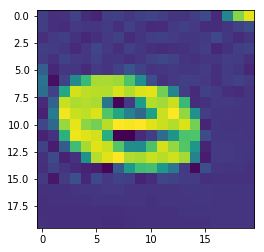

 
408
Was classified as an: E


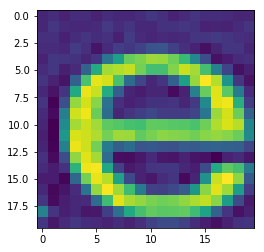

 
409
Was classified as an: E


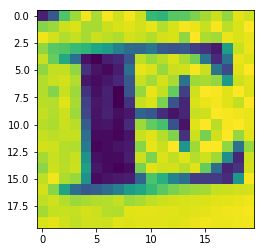

 
410
Was classified as an: E


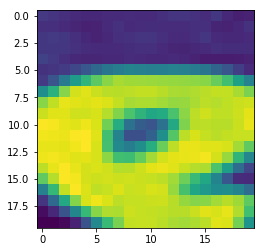

 
411
Was classified as an: E


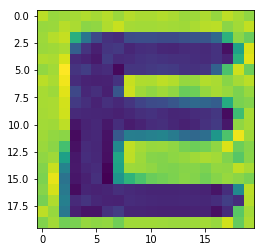

 
412
Was classified as an: F


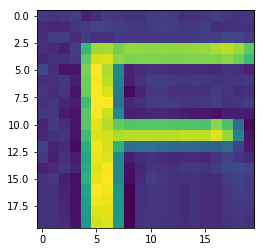

 
413
Was classified as an: F


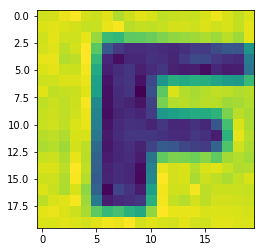

 
414
Was classified as an: F


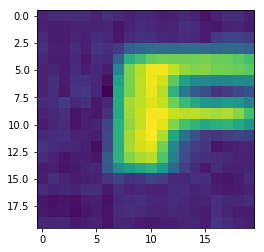

 
415
Was classified as an: F


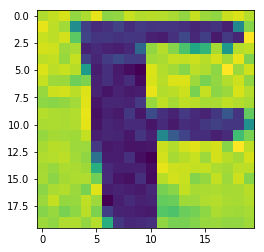

 
416
Was classified as an: F


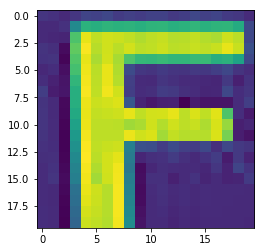

 
417
Was classified as an: F


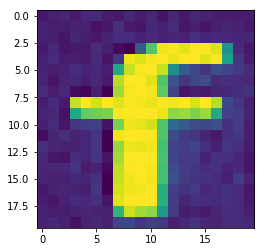

 
418
Was classified as an: R


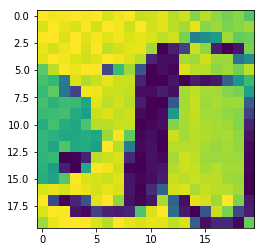

 
419
Was classified as an: F


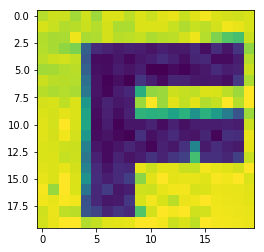

 
420
Was classified as an: R


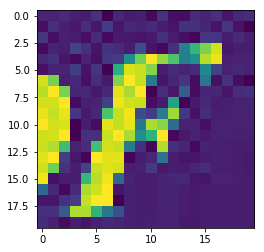

 
421
Was classified as an: R


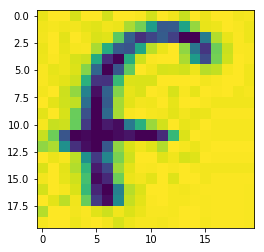

 
422
Was classified as an: F


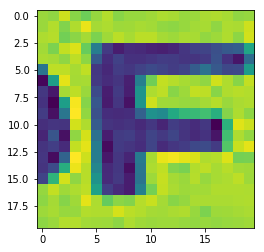

 
423
Was classified as an: T


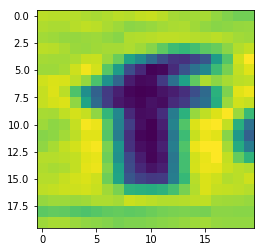

 
424
Was classified as an: F


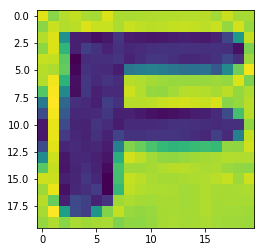

 
425
Was classified as an: F


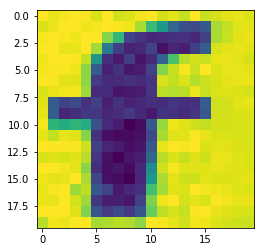

 
426
Was classified as an: I


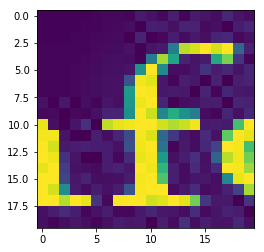

 
427
Was classified as an: F


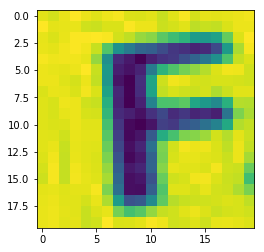

 
428
Was classified as an: F


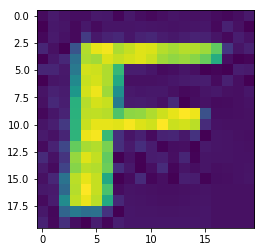

 
429
Was classified as an: T


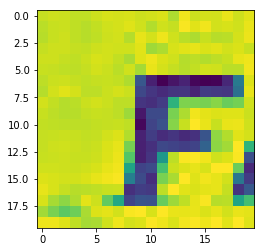

 
430
Was classified as an: E


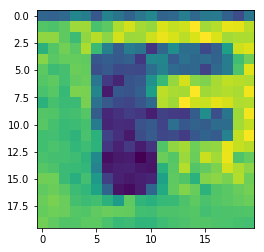

 
431
Was classified as an: R


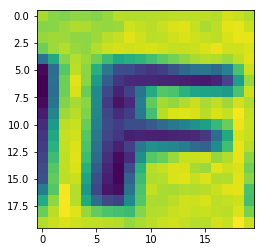

 
432
Was classified as an: R


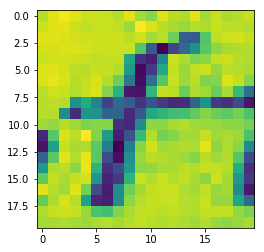

 
433
Was classified as an: F


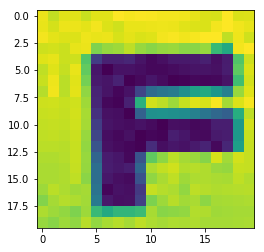

 
434
Was classified as an: R


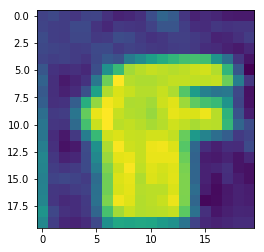

 
435
Was classified as an: P


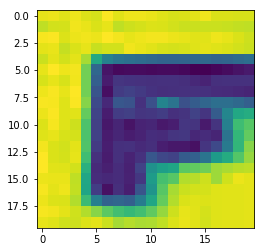

 
436
Was classified as an: O


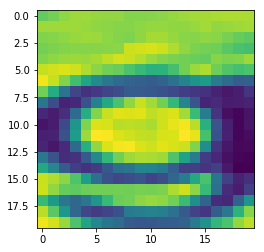

 
437
Was classified as an: R


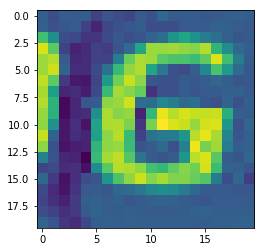

 
438
Was classified as an: G


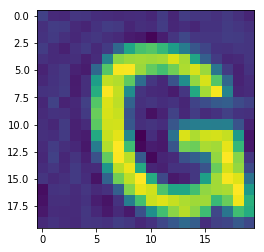

 
439
Was classified as an: G


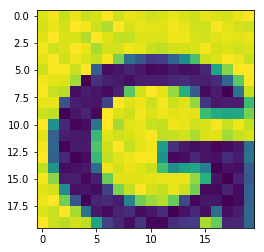

 
440
Was classified as an: G


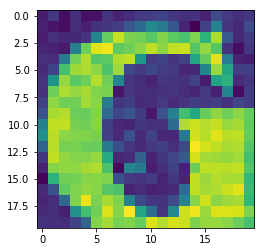

 
441
Was classified as an: G


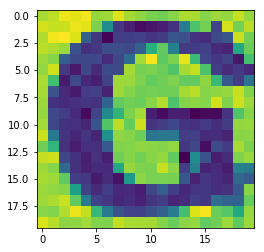

 
442
Was classified as an: G


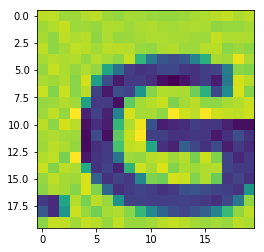

 
443
Was classified as an: S


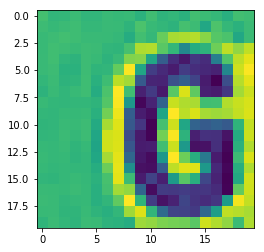

 
444
Was classified as an: R


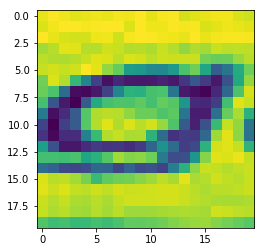

 
445
Was classified as an: O


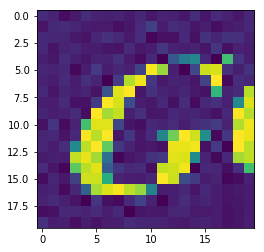

 
446
Was classified as an: G


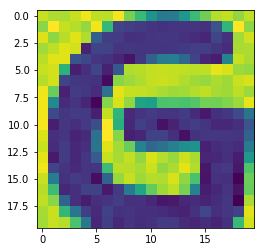

 
447
Was classified as an: G


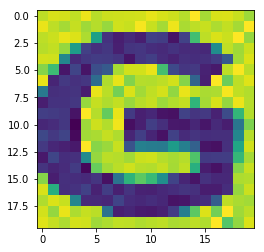

 
448
Was classified as an: G


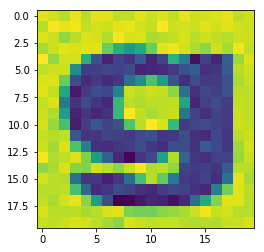

 
449
Was classified as an: R


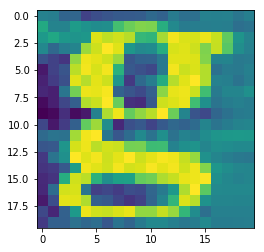

 
450
Was classified as an: O


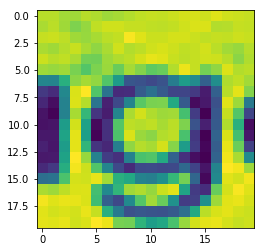

 
451
Was classified as an: G


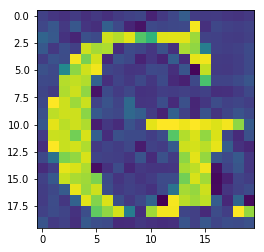

 
452
Was classified as an: G


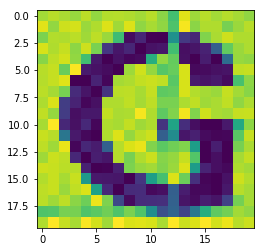

 
453
Was classified as an: G


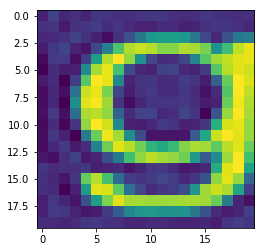

 
454
Was classified as an: G


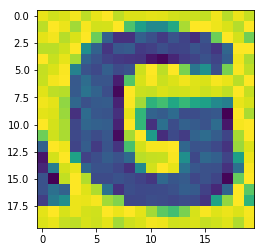

 
455
Was classified as an: G


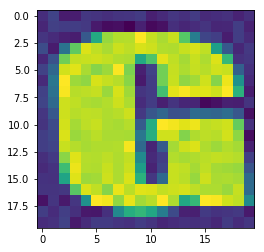

 
456
Was classified as an: G


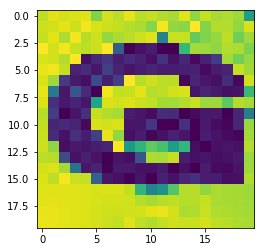

 
457
Was classified as an: C


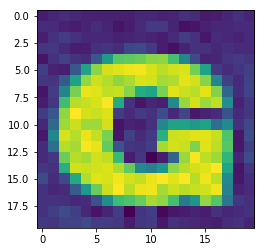

 
458
Was classified as an: G


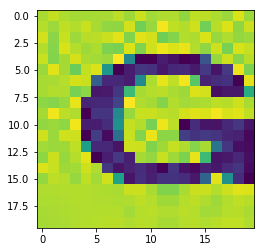

 
459
Was classified as an: O


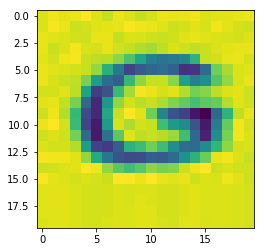

 
460
Was classified as an: R


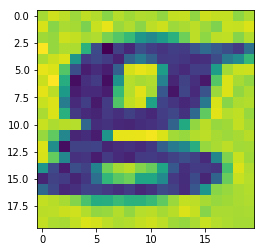

 
461
Was classified as an: O


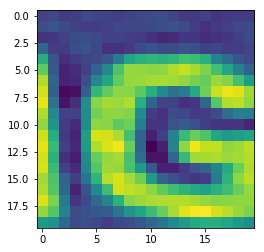

 
462
Was classified as an: G


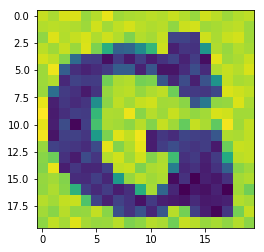

 
463
Was classified as an: O


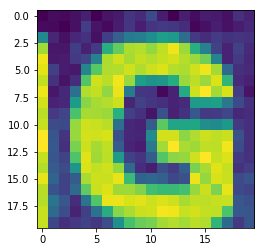

 
464
Was classified as an: C


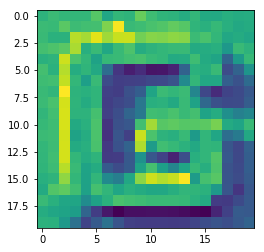

 
465
Was classified as an: E


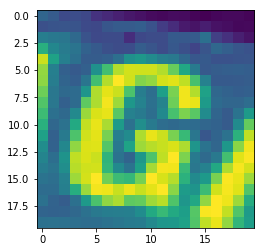

 
466
Was classified as an: G


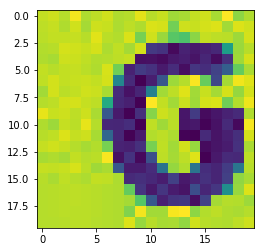

 
467
Was classified as an: G


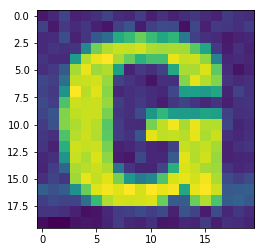

 
468
Was classified as an: G


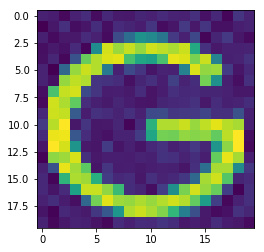

 
469
Was classified as an: G


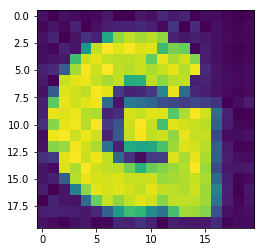

 
470
Was classified as an: G


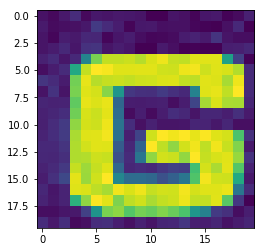

 
471
Was classified as an: G


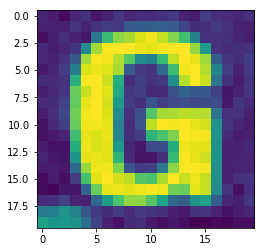

 
472
Was classified as an: H


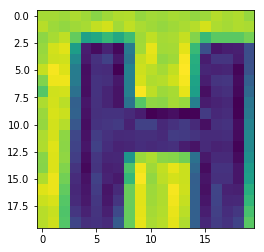

 
473
Was classified as an: H


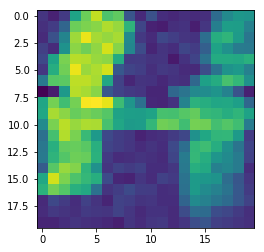

 
474
Was classified as an: H


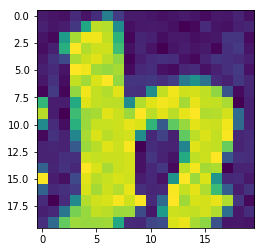

 
475
Was classified as an: H


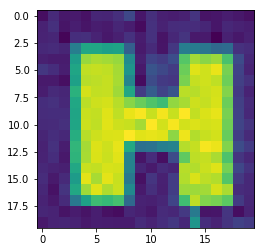

 
476
Was classified as an: H


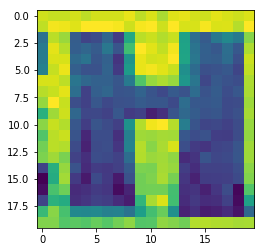

 
477
Was classified as an: H


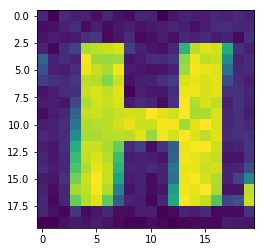

 
478
Was classified as an: H


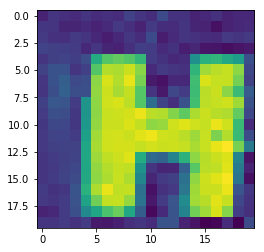

 
479
Was classified as an: H


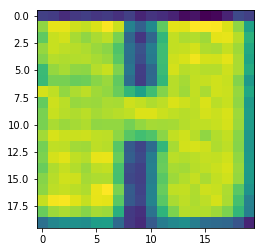

 
480
Was classified as an: H


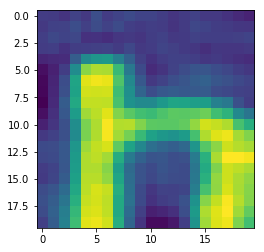

 
481
Was classified as an: R


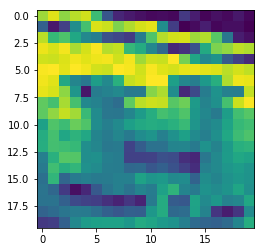

 
482
Was classified as an: H


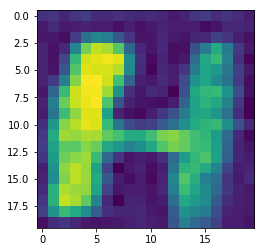

 
483
Was classified as an: H


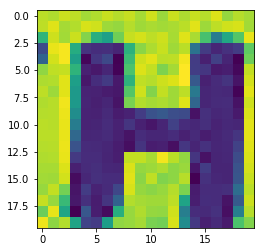

 
484
Was classified as an: H


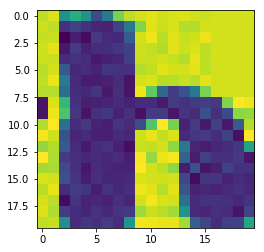

 
485
Was classified as an: H


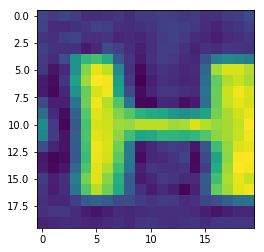

 
486
Was classified as an: H


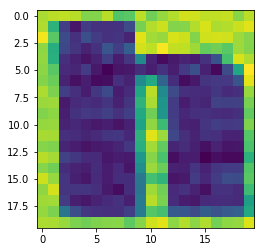

 
487
Was classified as an: H


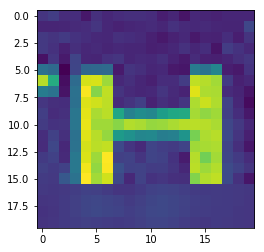

 
488
Was classified as an: H


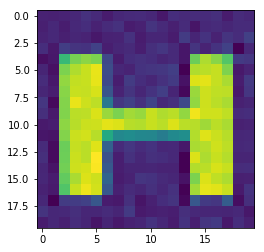

 
489
Was classified as an: N


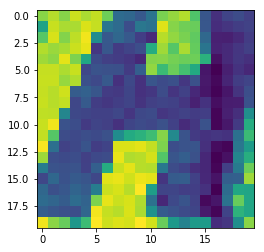

 
490
Was classified as an: H


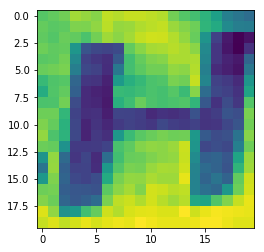

 
491
Was classified as an: H


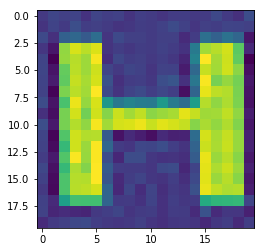

 
492
Was classified as an: H


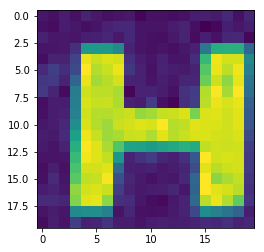

 
493
Was classified as an: H


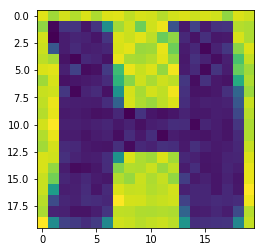

 
494
Was classified as an: R


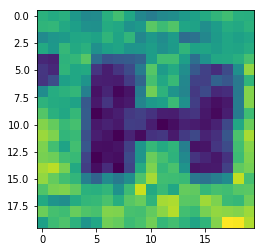

 
495
Was classified as an: H


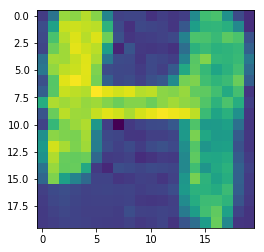

 
496
Was classified as an: H


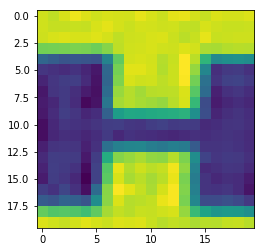

 
497
Was classified as an: H


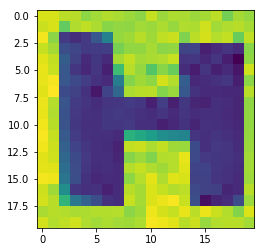

 
498
Was classified as an: H


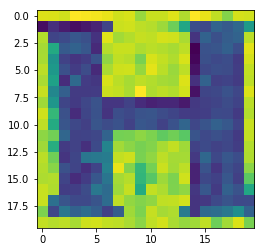

 
499
Was classified as an: H


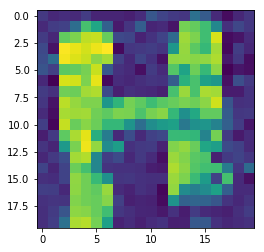

 
500
Was classified as an: N


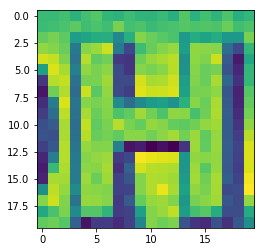

 
501
Was classified as an: H


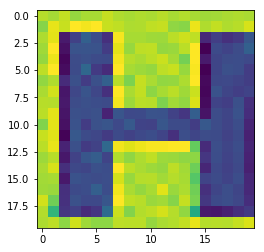

 
502
Was classified as an: H


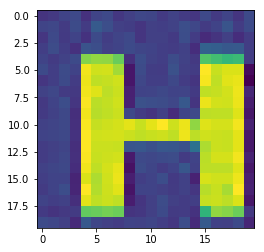

 
503
Was classified as an: H


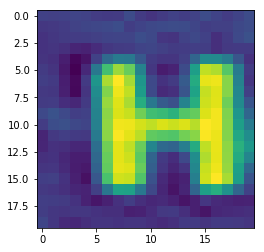

 
504
Was classified as an: H


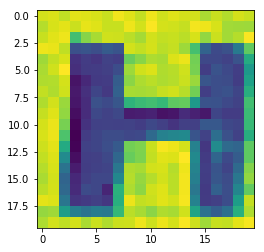

 
505
Was classified as an: H


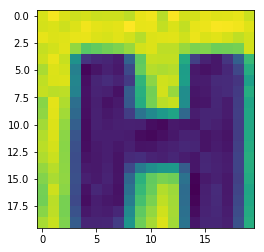

 
506
Was classified as an: H


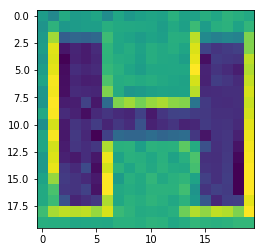

 
507
Was classified as an: H


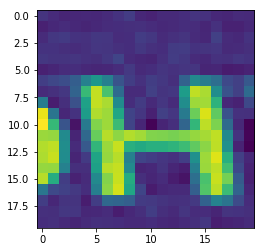

 
508
Was classified as an: H


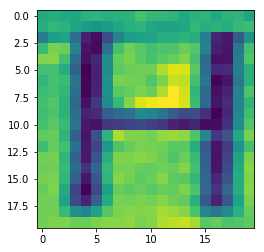

 
509
Was classified as an: H


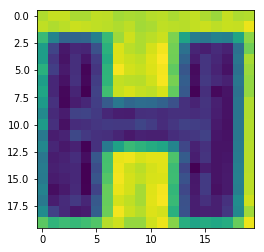

 
510
Was classified as an: H


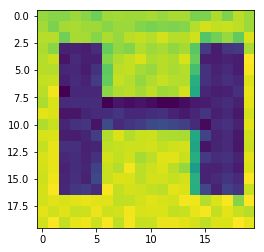

 
511
Was classified as an: R


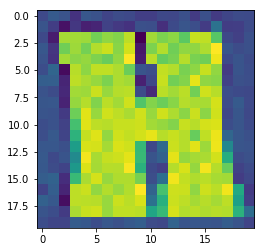

 
512
Was classified as an: H


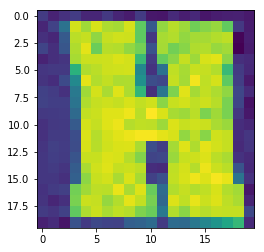

 
513
Was classified as an: H


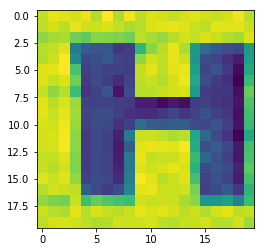

 
514
Was classified as an: H


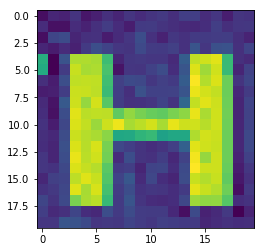

 
515
Was classified as an: H


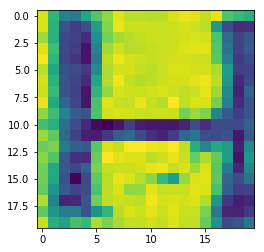

 
516
Was classified as an: H


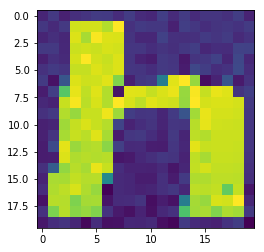

 
517
Was classified as an: H


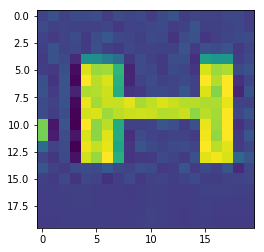

 
518
Was classified as an: H


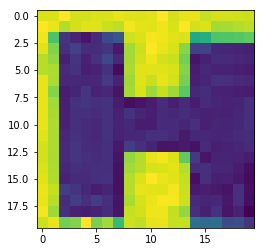

 
519
Was classified as an: H


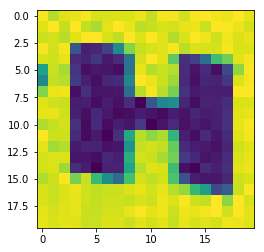

 
520
Was classified as an: H


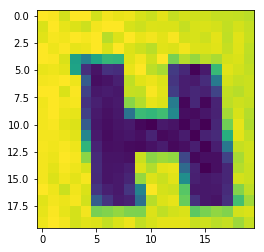

 
521
Was classified as an: T


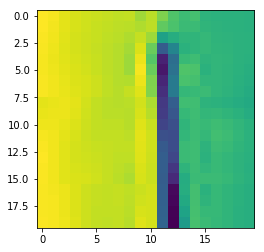

 
522
Was classified as an: I


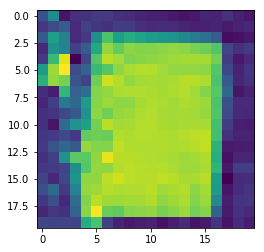

 
523
Was classified as an: I


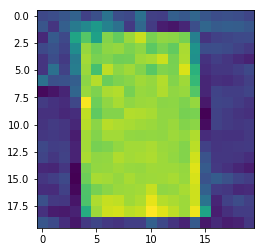

 
524
Was classified as an: I


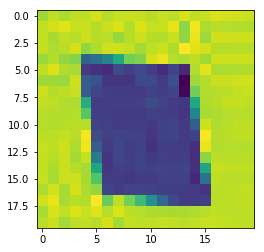

 
525
Was classified as an: I


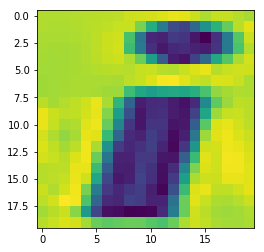

 
526
Was classified as an: I


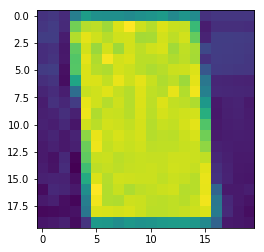

 
527
Was classified as an: I


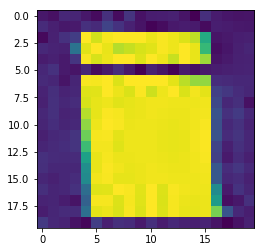

 
528
Was classified as an: I


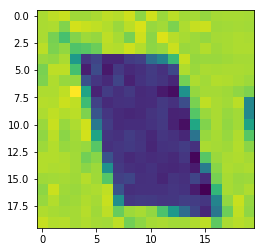

 
529
Was classified as an: I


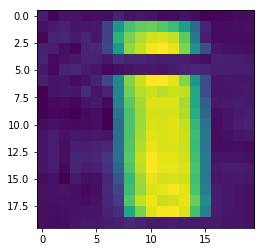

 
530
Was classified as an: L


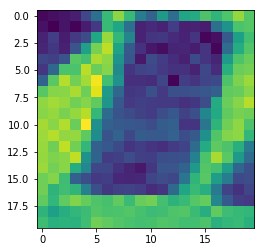

 
531
Was classified as an: I


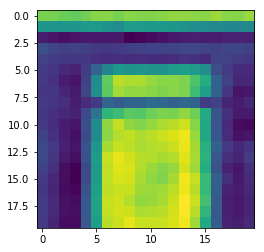

 
532
Was classified as an: I


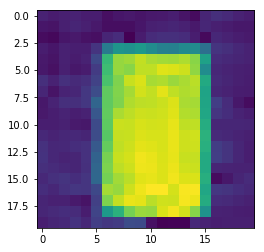

 
533
Was classified as an: I


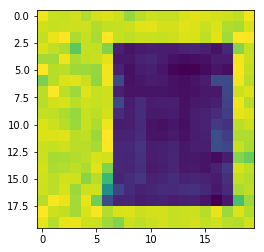

 
534
Was classified as an: I


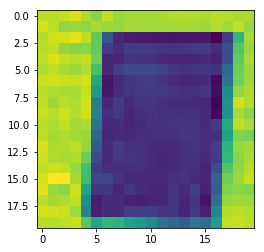

 
535
Was classified as an: I


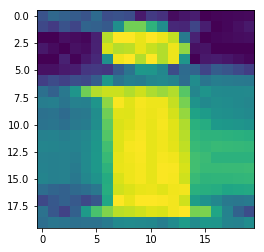

 
536
Was classified as an: I


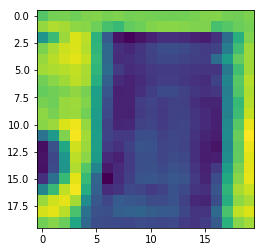

 
537
Was classified as an: I


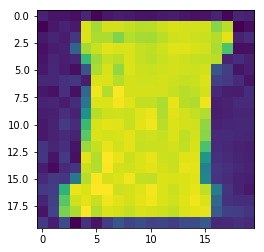

 
538
Was classified as an: I


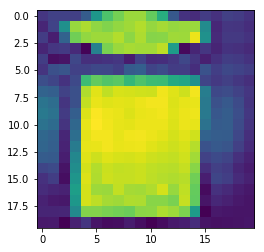

 
539
Was classified as an: I


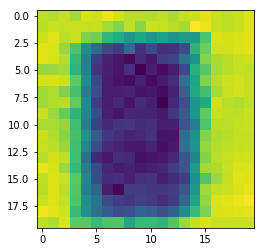

 
540
Was classified as an: I


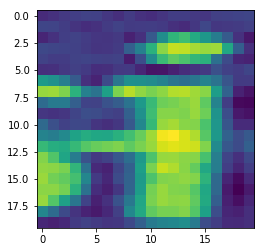

 
541
Was classified as an: I


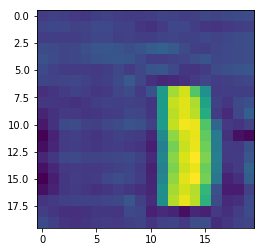

 
542
Was classified as an: I


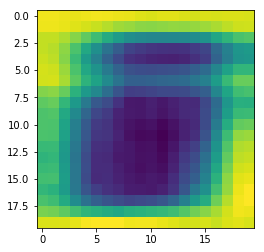

 
543
Was classified as an: I


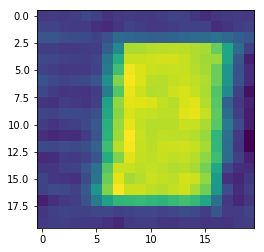

 
544
Was classified as an: I


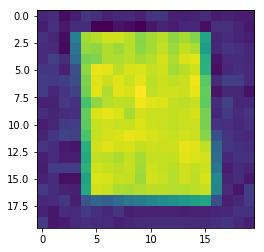

 
545
Was classified as an: I


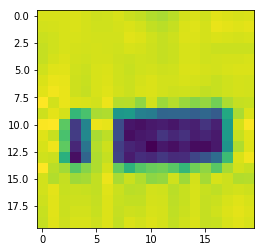

 
546
Was classified as an: I


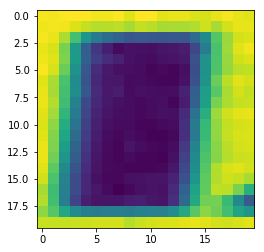

 
547
Was classified as an: I


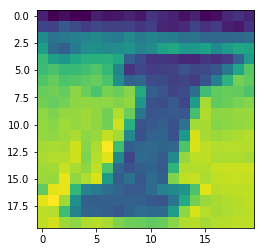

 
548
Was classified as an: I


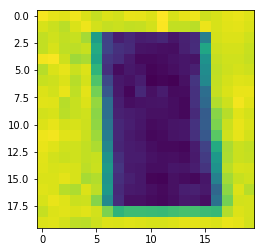

 
549
Was classified as an: I


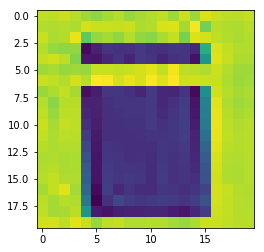

 
550
Was classified as an: I


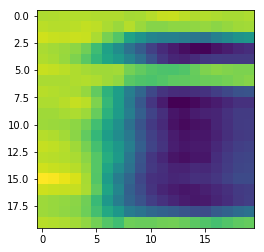

 
551
Was classified as an: I


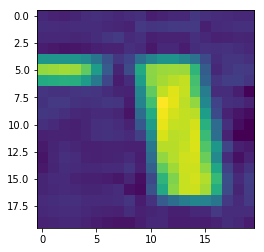

 
552
Was classified as an: I


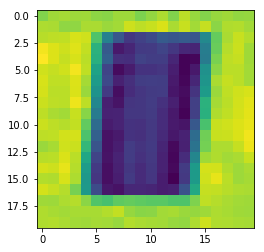

 
553
Was classified as an: I


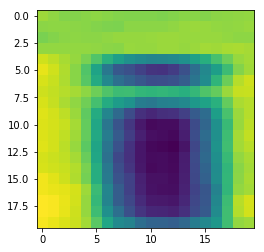

 
554
Was classified as an: I


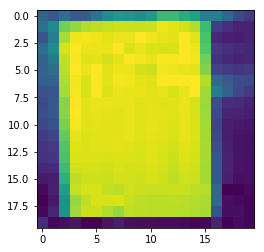

 
555
Was classified as an: I


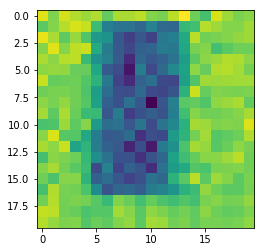

 
556
Was classified as an: L


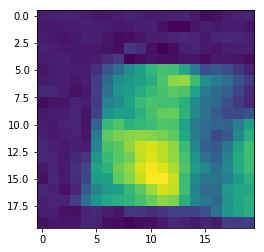

 
557
Was classified as an: I


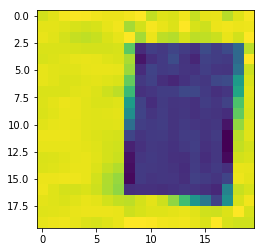

 
558
Was classified as an: W


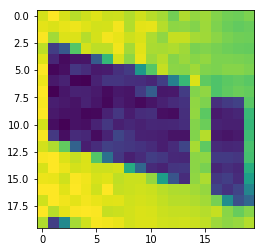

 
559
Was classified as an: I


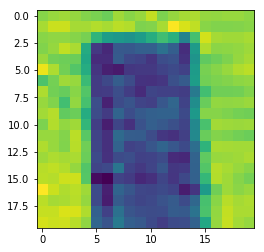

 
560
Was classified as an: I


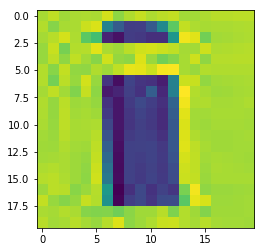

 
561
Was classified as an: I


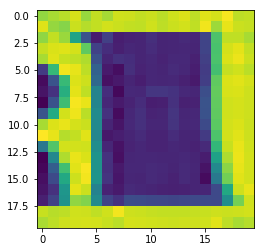

 
562
Was classified as an: I


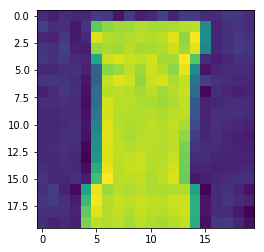

 
563
Was classified as an: I


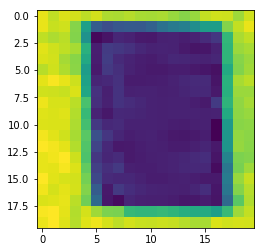

 
564
Was classified as an: I


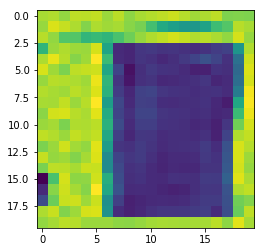

 
565
Was classified as an: I


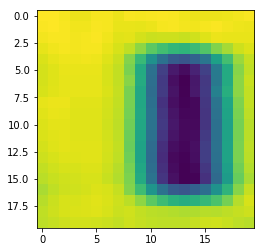

 
566
Was classified as an: I


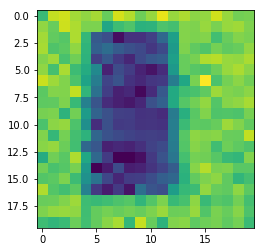

 
567
Was classified as an: L


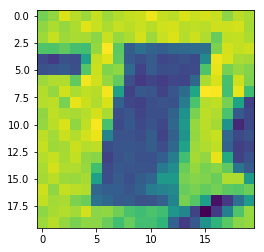

 
568
Was classified as an: I


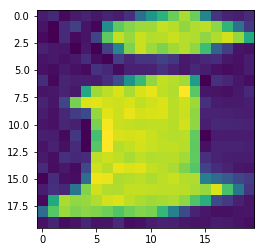

 
569
Was classified as an: L


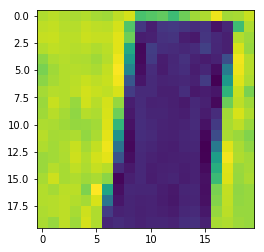

 
570
Was classified as an: I


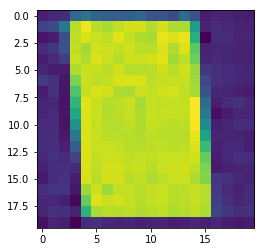

 
571
Was classified as an: I


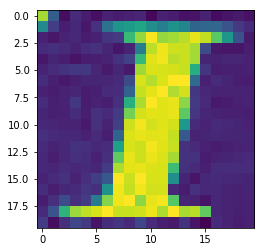

 
572
Was classified as an: I


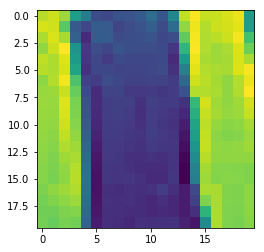

 
573
Was classified as an: I


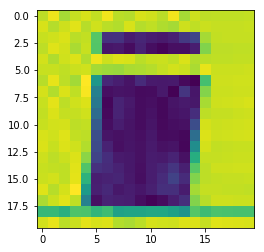

 
574
Was classified as an: I


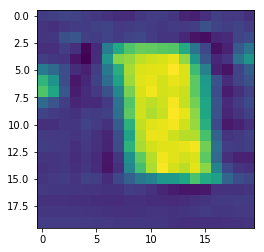

 
575
Was classified as an: I


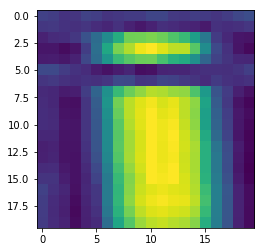

 
576
Was classified as an: I


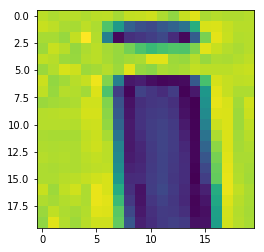

 
577
Was classified as an: I


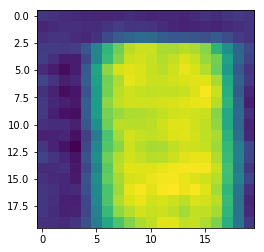

 
578
Was classified as an: I


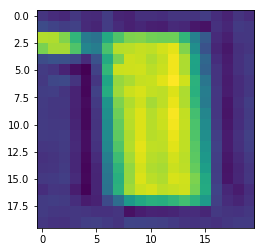

 
579
Was classified as an: I


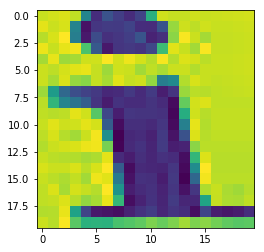

 
580
Was classified as an: I


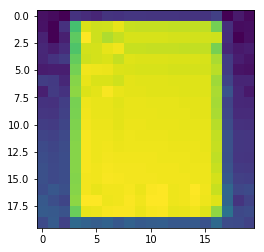

 
581
Was classified as an: I


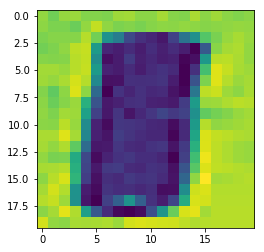

 
582
Was classified as an: I


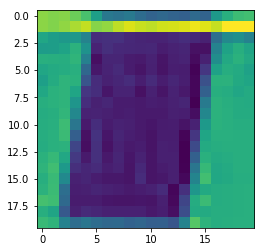

 
583
Was classified as an: I


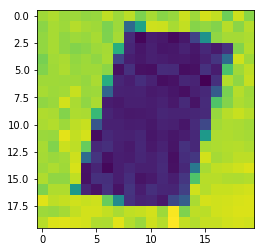

 
584
Was classified as an: I


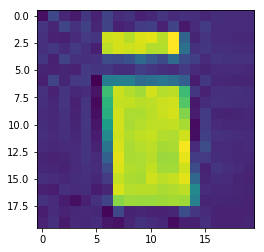

 
585
Was classified as an: I


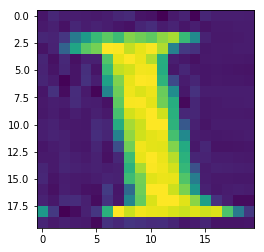

 
586
Was classified as an: I


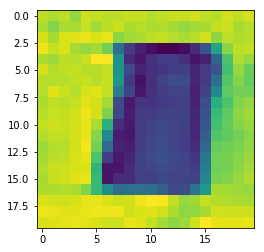

 
587
Was classified as an: I


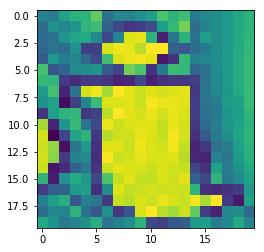

 
588
Was classified as an: I


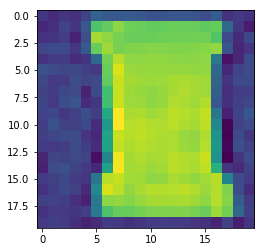

 
589
Was classified as an: T


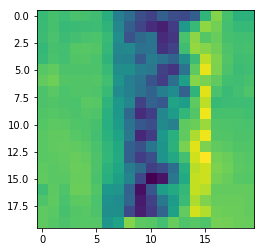

 
590
Was classified as an: I


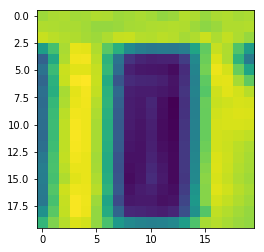

 
591
Was classified as an: I


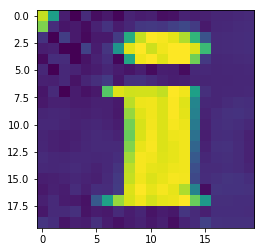

 
592
Was classified as an: I


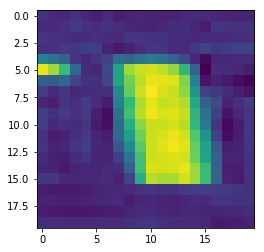

 
593
Was classified as an: I


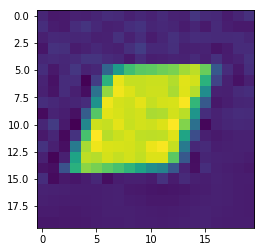

 
594
Was classified as an: I


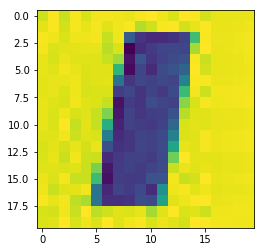

 
595
Was classified as an: U


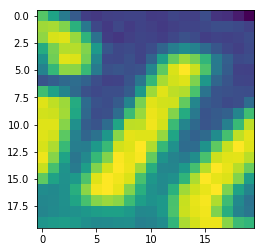

 
596
Was classified as an: I


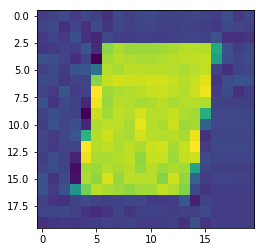

 
597
Was classified as an: I


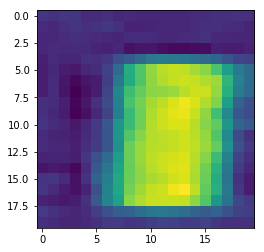

 
598
Was classified as an: I


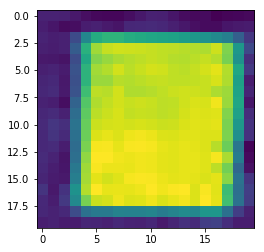

 
599
Was classified as an: I


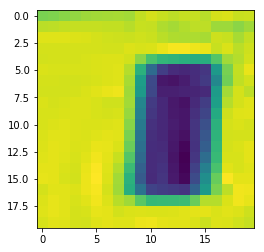

 
600
Was classified as an: I


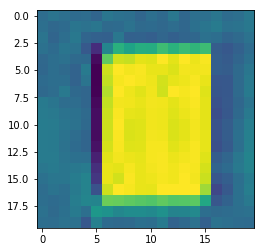

 
601
Was classified as an: A


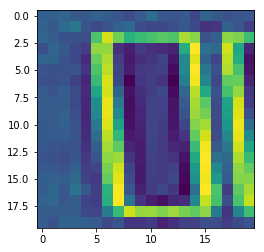

 
602
Was classified as an: I


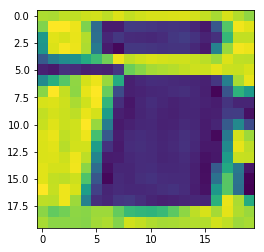

 
603
Was classified as an: I


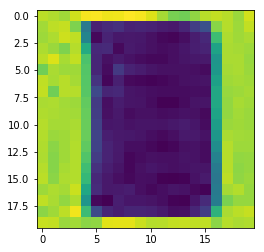

 
604
Was classified as an: I


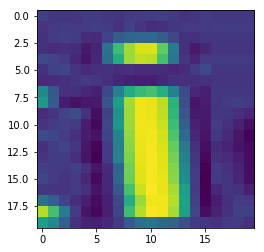

 
605
Was classified as an: I


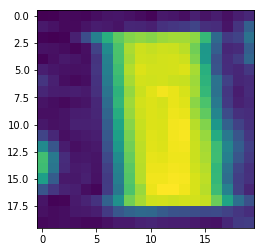

 
606
Was classified as an: T


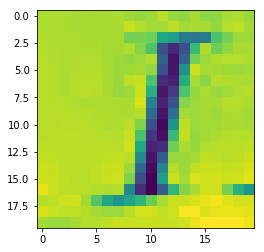

 
607
Was classified as an: J


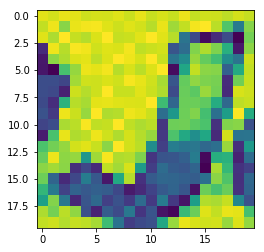

 
608
Was classified as an: J


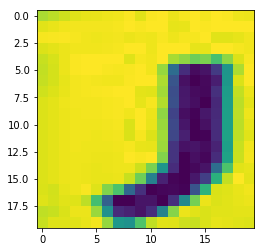

 
609
Was classified as an: Z


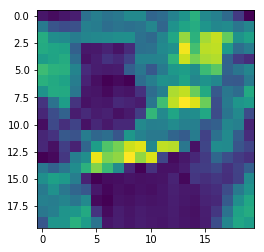

 
610
Was classified as an: I


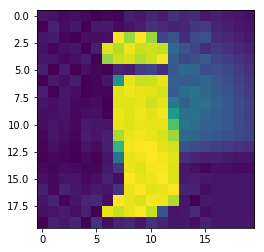

 
611
Was classified as an: J


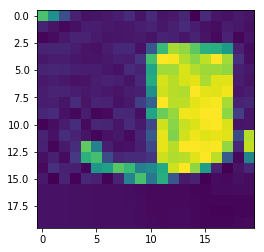

 
612
Was classified as an: S


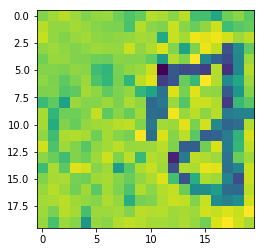

 
613
Was classified as an: A


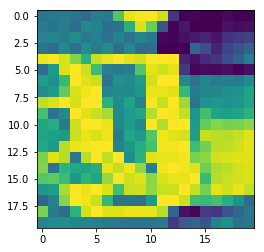

 
614
Was classified as an: D


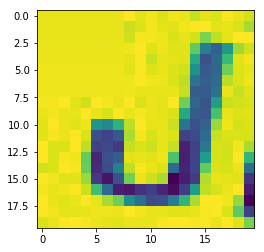

 
615
Was classified as an: I


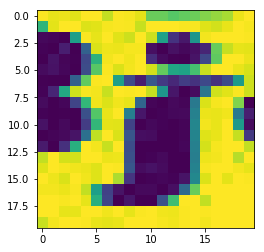

 
616
Was classified as an: A


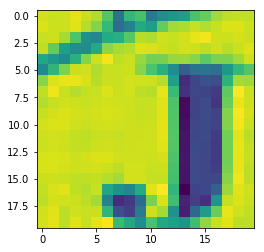

 
617
Was classified as an: J


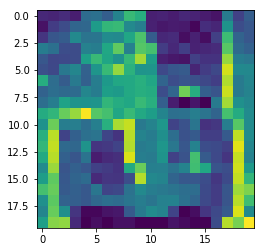

 
618
Was classified as an: A


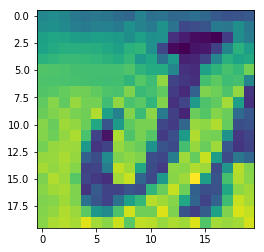

 
619
Was classified as an: L


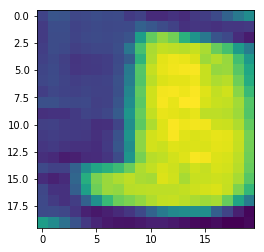

 
620
Was classified as an: A


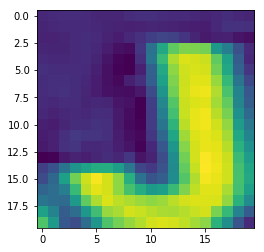

 
621
Was classified as an: I


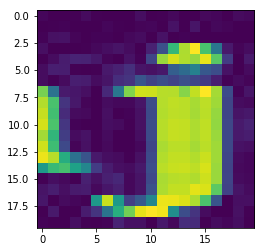

 
622
Was classified as an: U


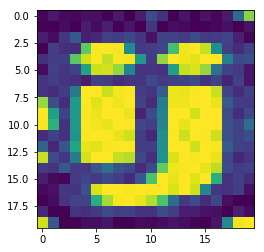

 
623
Was classified as an: J


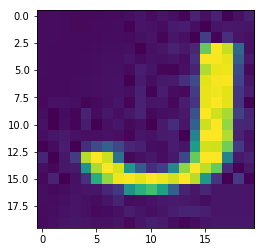

 
624
Was classified as an: R


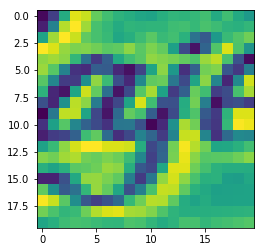

 
625
Was classified as an: J


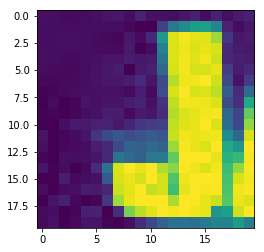

 
626
Was classified as an: V


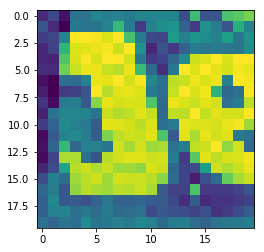

 
627
Was classified as an: J


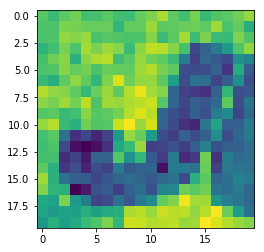

 
628
Was classified as an: D


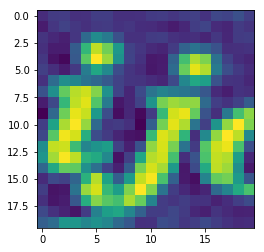

 
629
Was classified as an: N


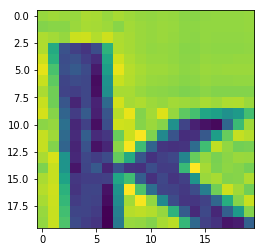

 
630
Was classified as an: R


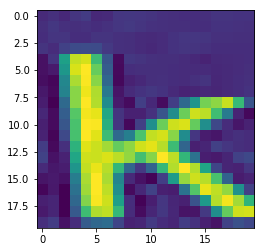

 
631
Was classified as an: K


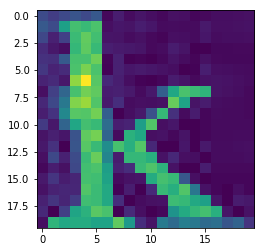

 
632
Was classified as an: K


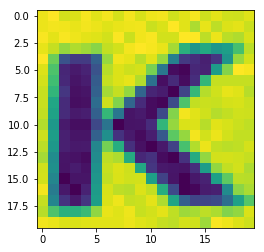

 
633
Was classified as an: K


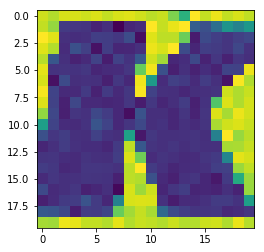

 
634
Was classified as an: X


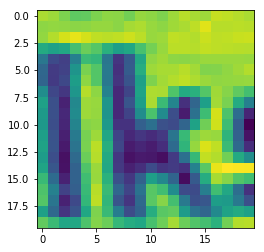

 
635
Was classified as an: K


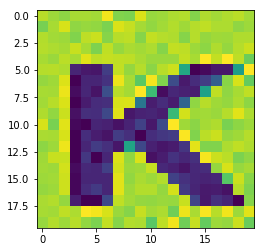

 
636
Was classified as an: K


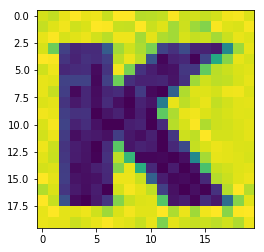

 
637
Was classified as an: K


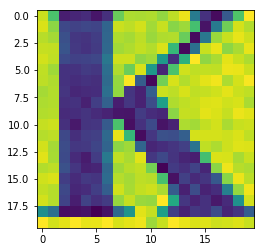

 
638
Was classified as an: A


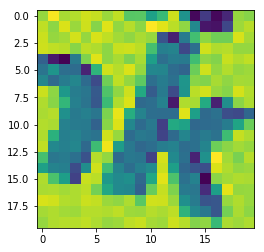

 
639
Was classified as an: R


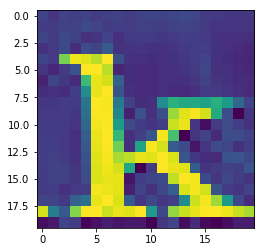

 
640
Was classified as an: Y


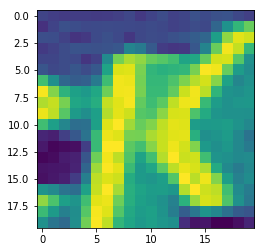

 
641
Was classified as an: K


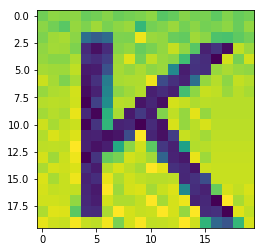

 
642
Was classified as an: R


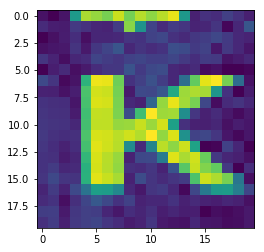

 
643
Was classified as an: F


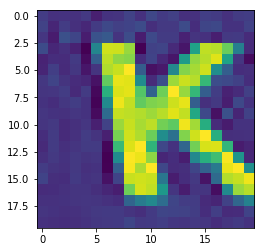

 
644
Was classified as an: R


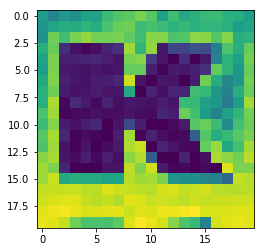

 
645
Was classified as an: K


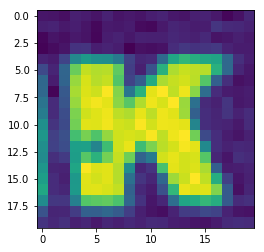

 
646
Was classified as an: L


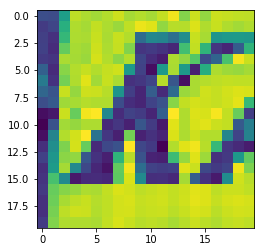

 
647
Was classified as an: K


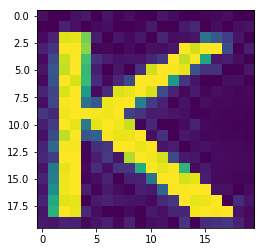

 
648
Was classified as an: K


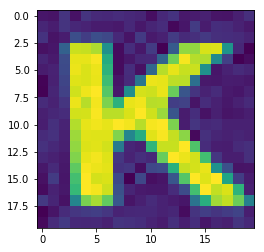

 
649
Was classified as an: K


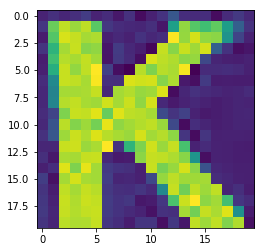

 
650
Was classified as an: K


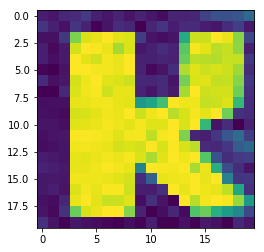

 
651
Was classified as an: K


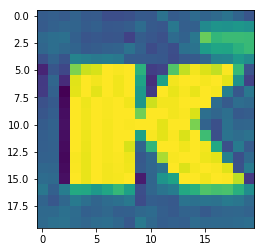

 
652
Was classified as an: R


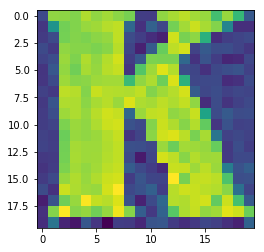

 
653
Was classified as an: K


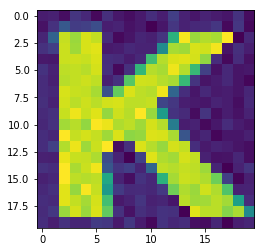

 
654
Was classified as an: T


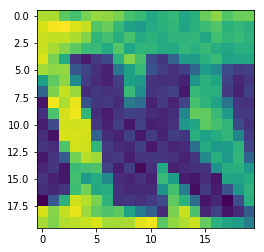

 
655
Was classified as an: L


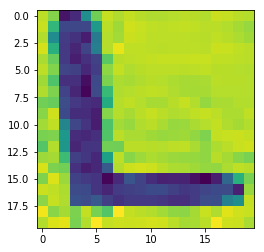

 
656
Was classified as an: L


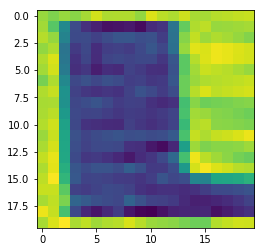

 
657
Was classified as an: L


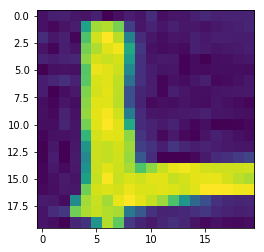

 
658
Was classified as an: L


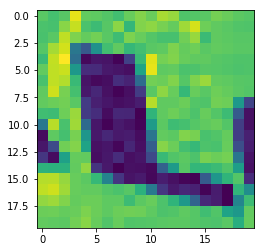

 
659
Was classified as an: L


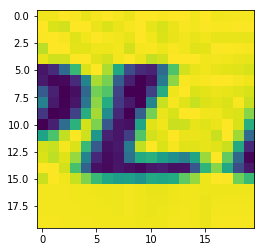

 
660
Was classified as an: L


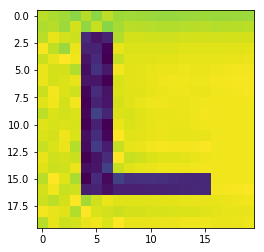

 
661
Was classified as an: L


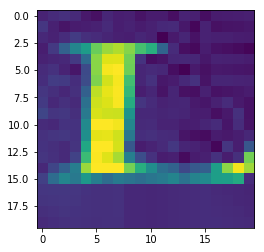

 
662
Was classified as an: L


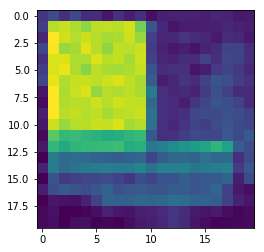

 
663
Was classified as an: L


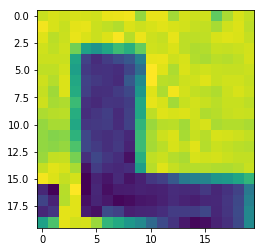

 
664
Was classified as an: L


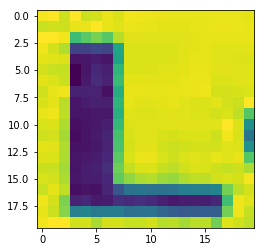

 
665
Was classified as an: L


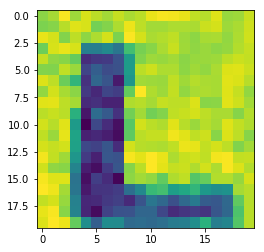

 
666
Was classified as an: L


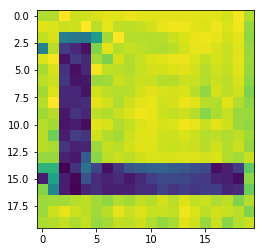

 
667
Was classified as an: L


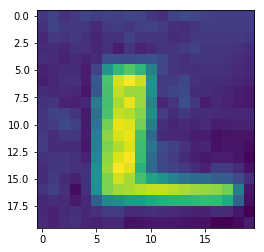

 
668
Was classified as an: L


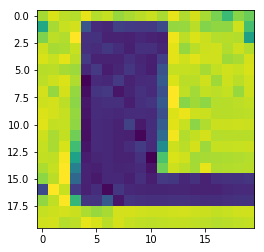

 
669
Was classified as an: I


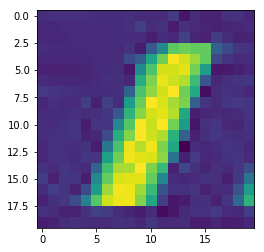

 
670
Was classified as an: L


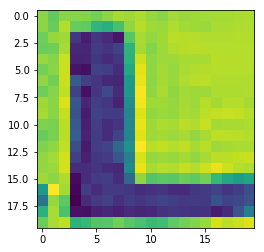

 
671
Was classified as an: L


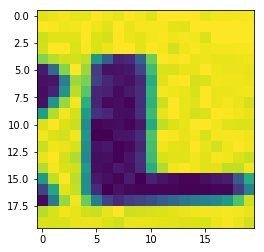

 
672
Was classified as an: I


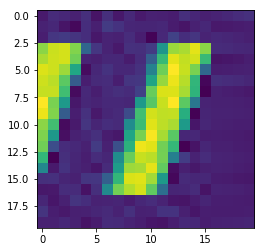

 
673
Was classified as an: L


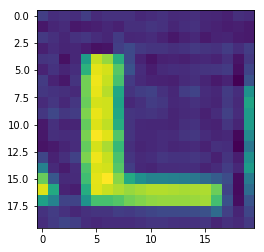

 
674
Was classified as an: L


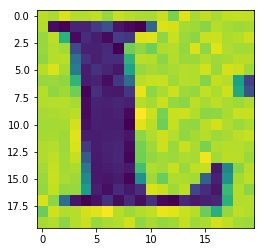

 
675
Was classified as an: L


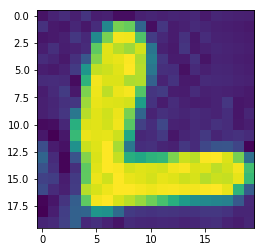

 
676
Was classified as an: L


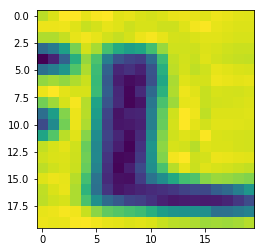

 
677
Was classified as an: L


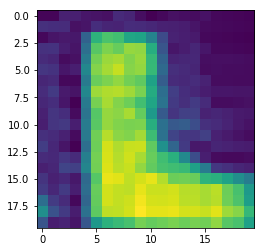

 
678
Was classified as an: A


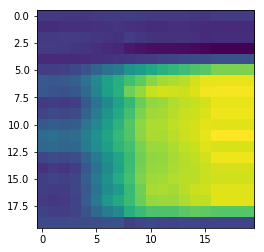

 
679
Was classified as an: L


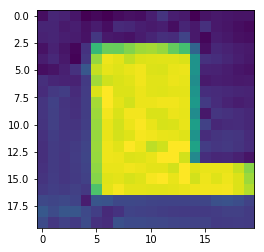

 
680
Was classified as an: L


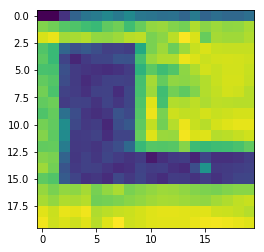

 
681
Was classified as an: I


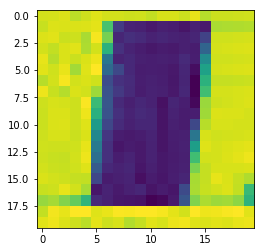

 
682
Was classified as an: L


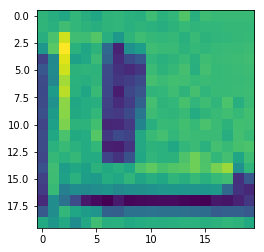

 
683
Was classified as an: R


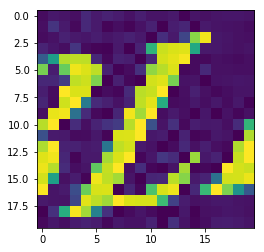

 
684
Was classified as an: L


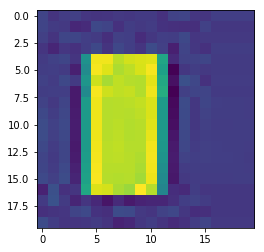

 
685
Was classified as an: L


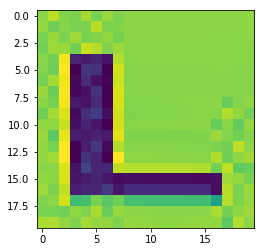

 
686
Was classified as an: L


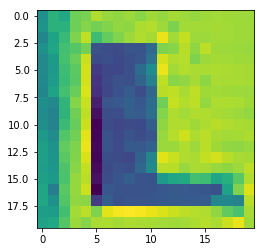

 
687
Was classified as an: L


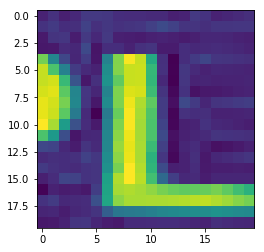

 
688
Was classified as an: L


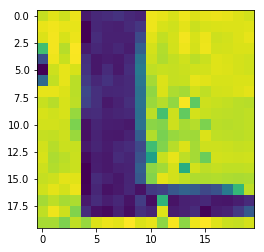

 
689
Was classified as an: L


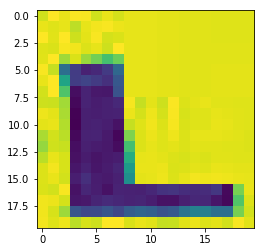

 
690
Was classified as an: I


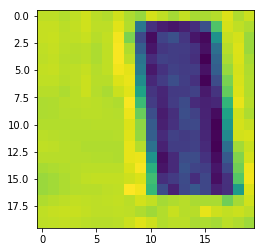

 
691
Was classified as an: L


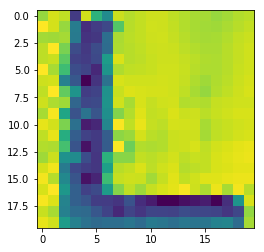

 
692
Was classified as an: I


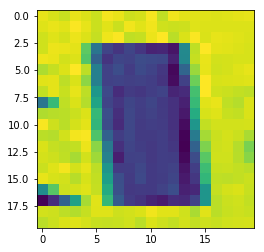

 
693
Was classified as an: I


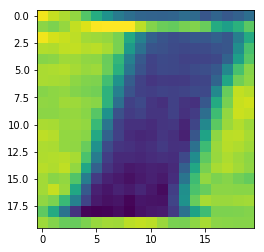

 
694
Was classified as an: C


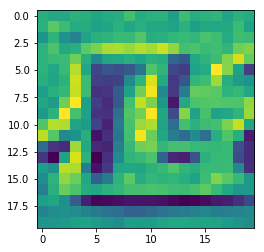

 
695
Was classified as an: L


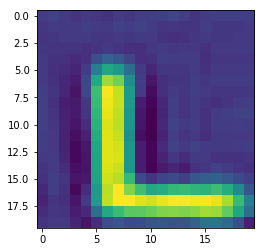

 
696
Was classified as an: L


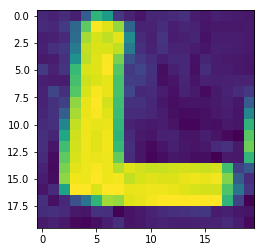

 
697
Was classified as an: L


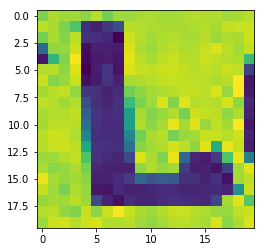

 
698
Was classified as an: L


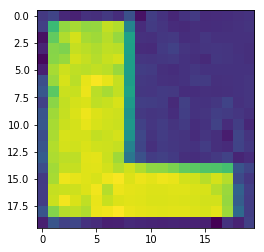

 
699
Was classified as an: L


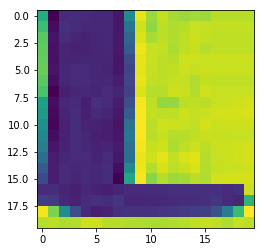

 
700
Was classified as an: L


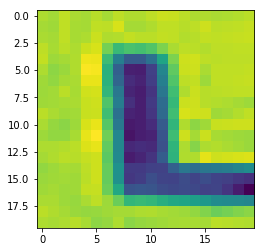

 
701
Was classified as an: L


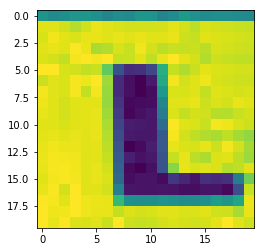

 
702
Was classified as an: L


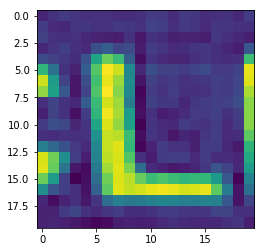

 
703
Was classified as an: L


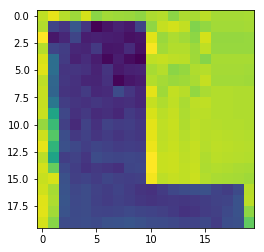

 
704
Was classified as an: I


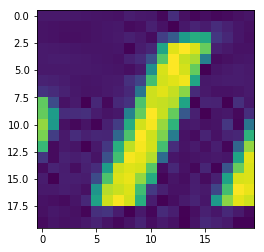

 
705
Was classified as an: L


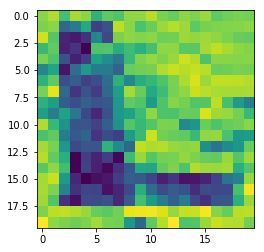

 
706
Was classified as an: L


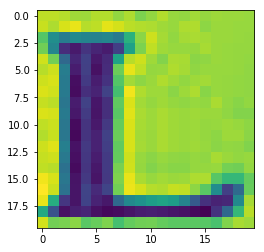

 
707
Was classified as an: L


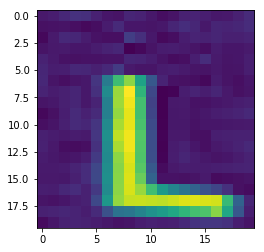

 
708
Was classified as an: L


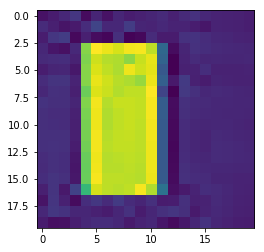

 
709
Was classified as an: L


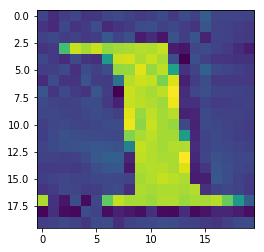

 
710
Was classified as an: M


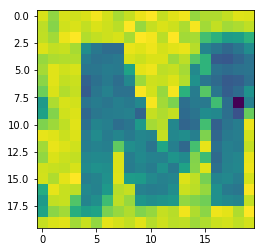

 
711
Was classified as an: H


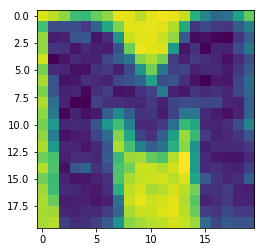

 
712
Was classified as an: N


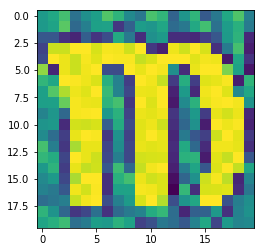

 
713
Was classified as an: M


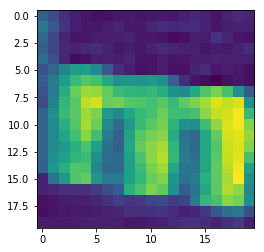

 
714
Was classified as an: M


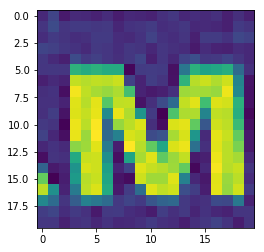

 
715
Was classified as an: M


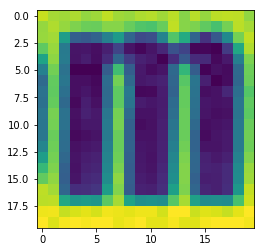

 
716
Was classified as an: M


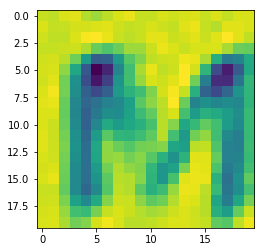

 
717
Was classified as an: M


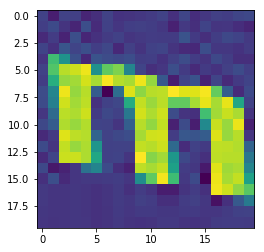

 
718
Was classified as an: M


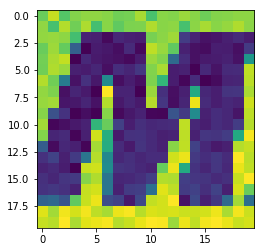

 
719
Was classified as an: M


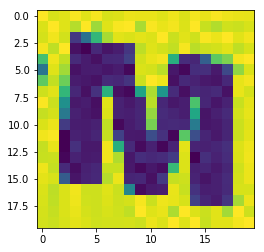

 
720
Was classified as an: H


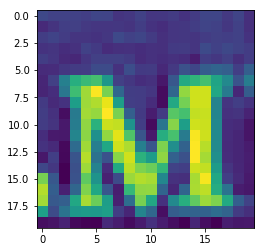

 
721
Was classified as an: M


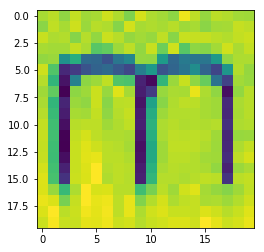

 
722
Was classified as an: M


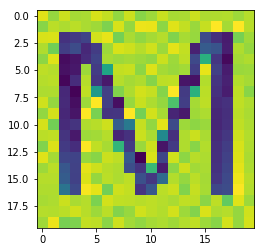

 
723
Was classified as an: M


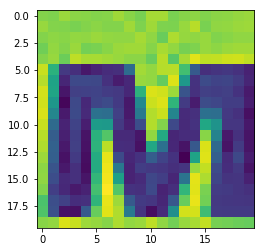

 
724
Was classified as an: M


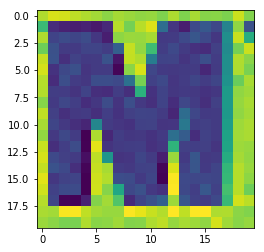

 
725
Was classified as an: M


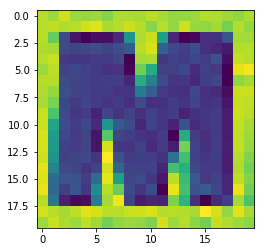

 
726
Was classified as an: M


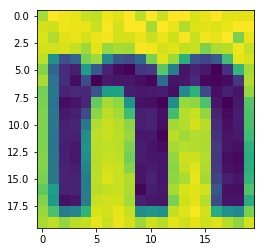

 
727
Was classified as an: N


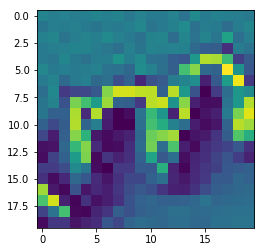

 
728
Was classified as an: M


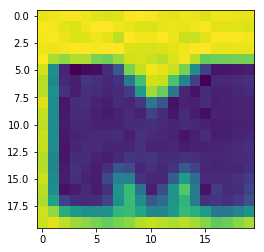

 
729
Was classified as an: M


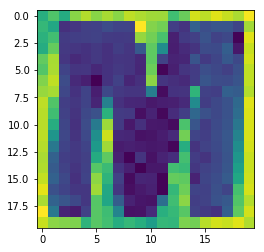

 
730
Was classified as an: M


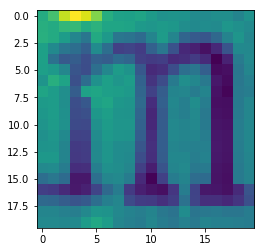

 
731
Was classified as an: M


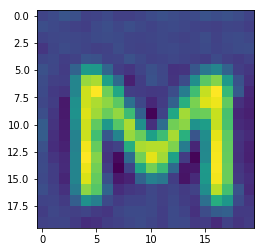

 
732
Was classified as an: M


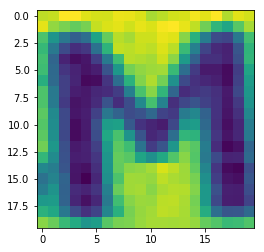

 
733
Was classified as an: M


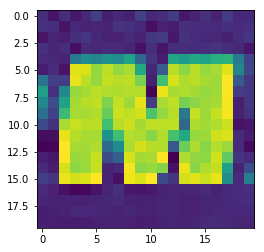

 
734
Was classified as an: M


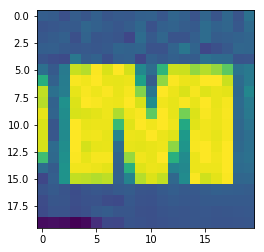

 
735
Was classified as an: H


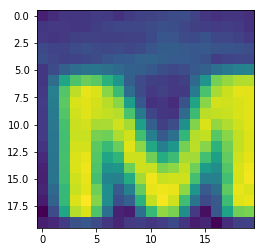

 
736
Was classified as an: M


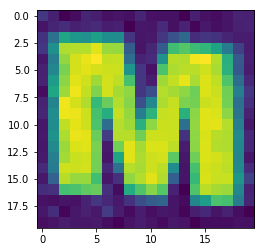

 
737
Was classified as an: M


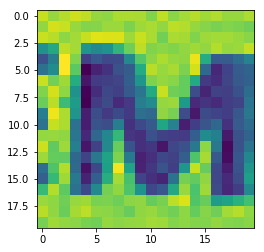

 
738
Was classified as an: M


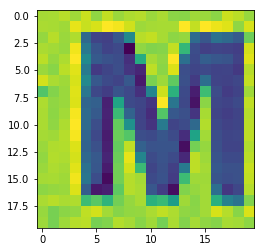

 
739
Was classified as an: A


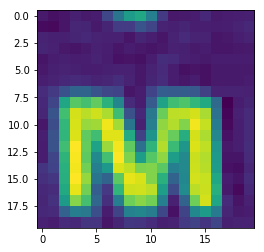

 
740
Was classified as an: M


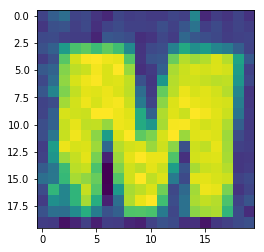

 
741
Was classified as an: A


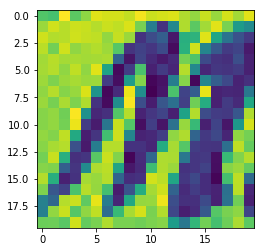

 
742
Was classified as an: M


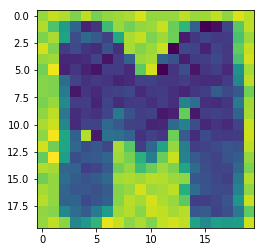

 
743
Was classified as an: M


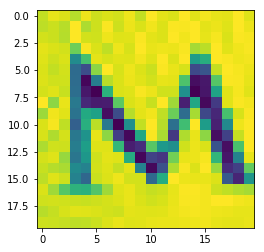

 
744
Was classified as an: M


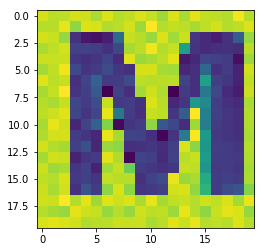

 
745
Was classified as an: M


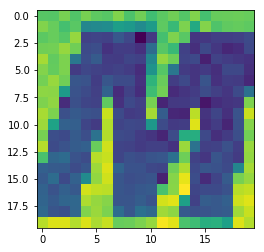

 
746
Was classified as an: M


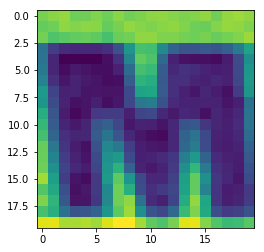

 
747
Was classified as an: M


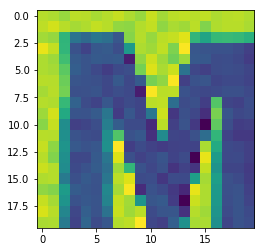

 
748
Was classified as an: N


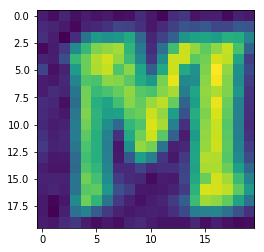

 
749
Was classified as an: N


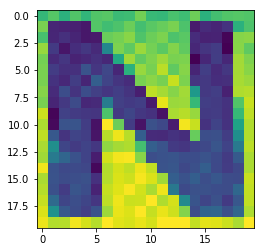

 
750
Was classified as an: N


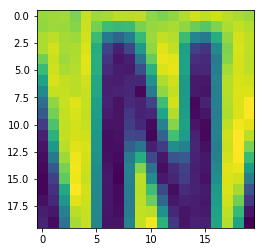

 
751
Was classified as an: N


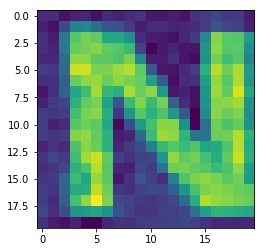

 
752
Was classified as an: N


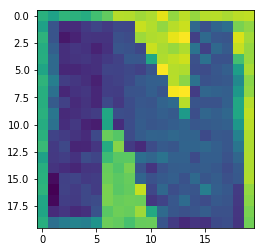

 
753
Was classified as an: N


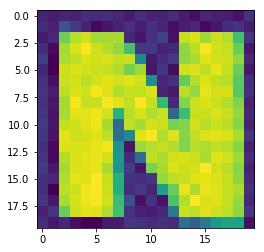

 
754
Was classified as an: N


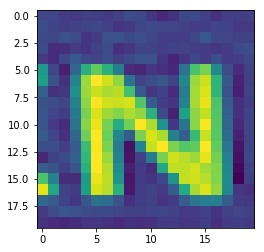

 
755
Was classified as an: N


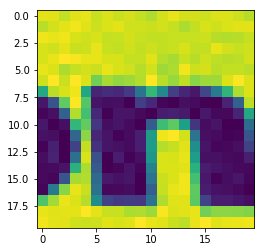

 
756
Was classified as an: N


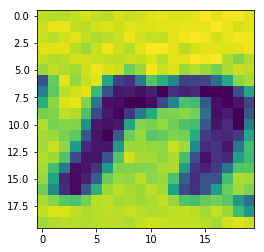

 
757
Was classified as an: N


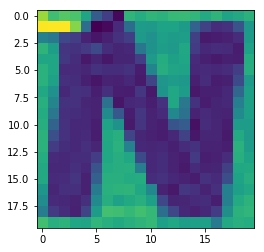

 
758
Was classified as an: N


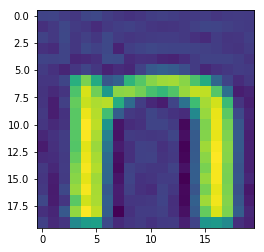

 
759
Was classified as an: N


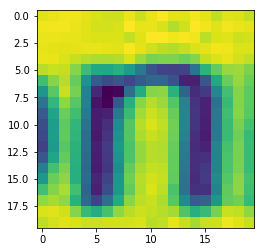

 
760
Was classified as an: N


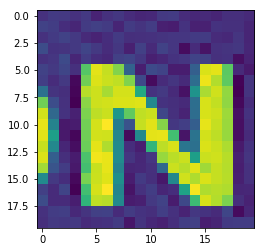

 
761
Was classified as an: N


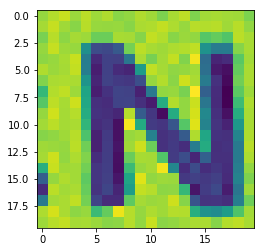

 
762
Was classified as an: R


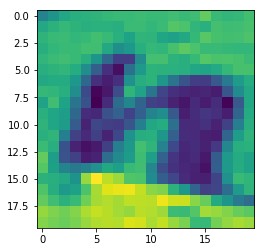

 
763
Was classified as an: R


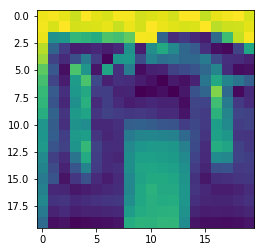

 
764
Was classified as an: N


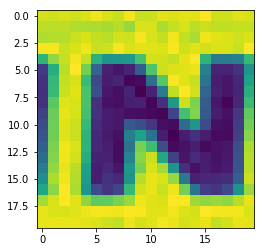

 
765
Was classified as an: N


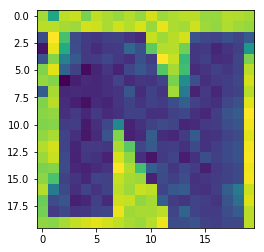

 
766
Was classified as an: N


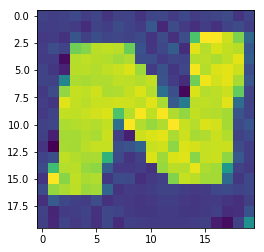

 
767
Was classified as an: N


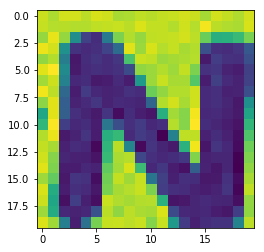

 
768
Was classified as an: N


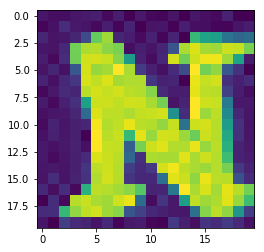

 
769
Was classified as an: N


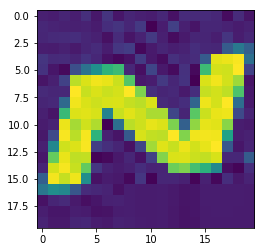

 
770
Was classified as an: N


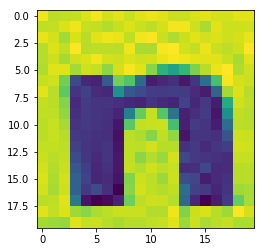

 
771
Was classified as an: N


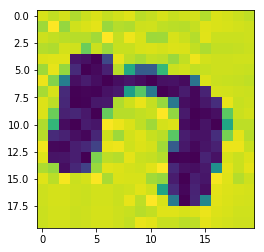

 
772
Was classified as an: N


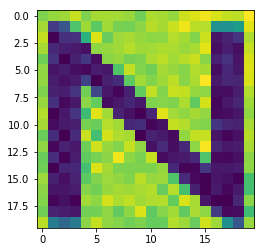

 
773
Was classified as an: N


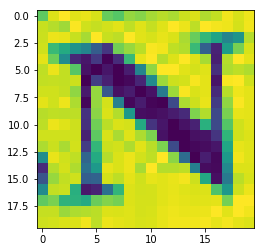

 
774
Was classified as an: H


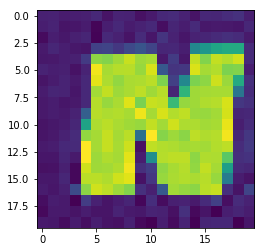

 
775
Was classified as an: N


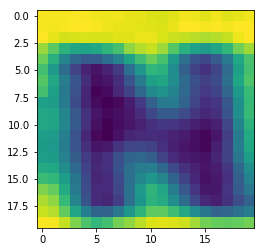

 
776
Was classified as an: N


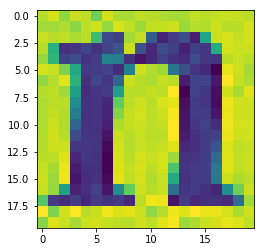

 
777
Was classified as an: A


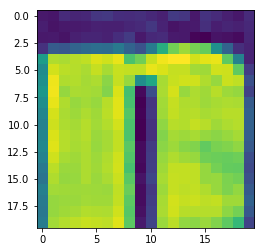

 
778
Was classified as an: N


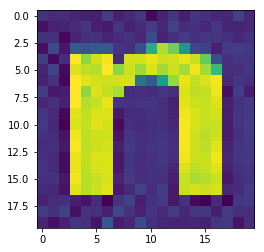

 
779
Was classified as an: N


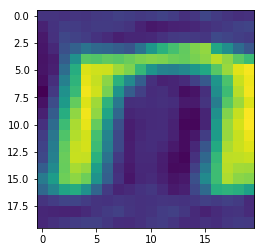

 
780
Was classified as an: N


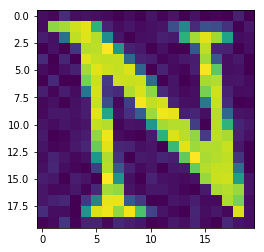

 
781
Was classified as an: N


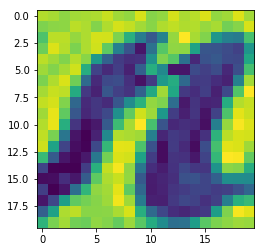

 
782
Was classified as an: N


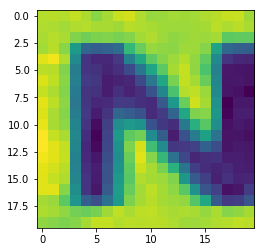

 
783
Was classified as an: N


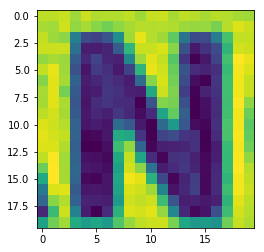

 
784
Was classified as an: N


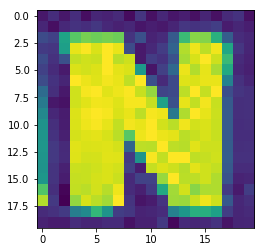

 
785
Was classified as an: N


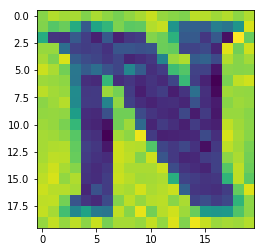

 
786
Was classified as an: N


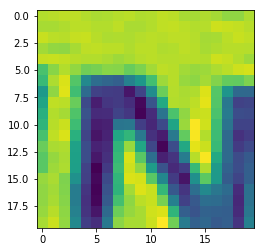

 
787
Was classified as an: N


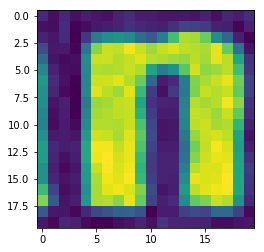

 
788
Was classified as an: N


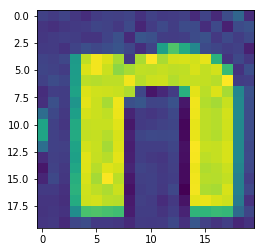

 
789
Was classified as an: N


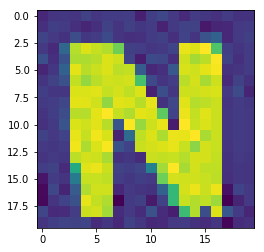

 
790
Was classified as an: N


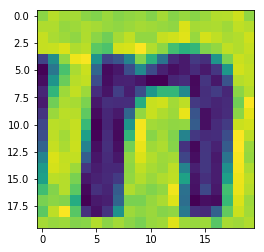

 
791
Was classified as an: N


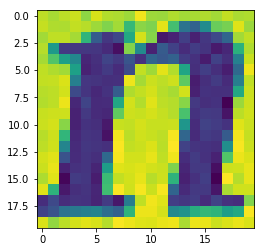

 
792
Was classified as an: N


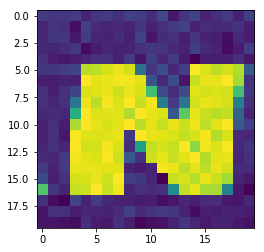

 
793
Was classified as an: N


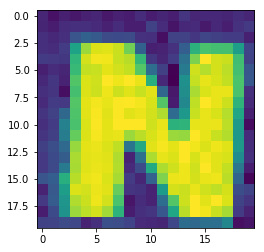

 
794
Was classified as an: N


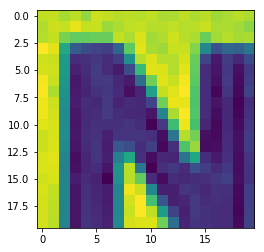

 
795
Was classified as an: N


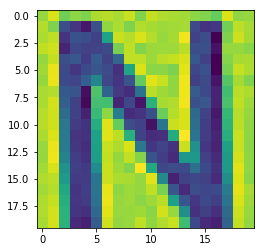

 
796
Was classified as an: R


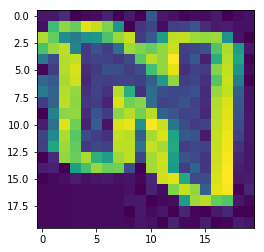

 
797
Was classified as an: N


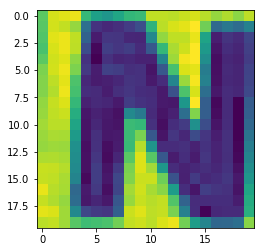

 
798
Was classified as an: N


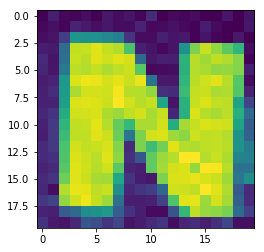

 
799
Was classified as an: N


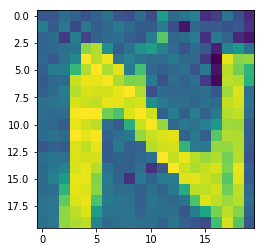

 
800
Was classified as an: N


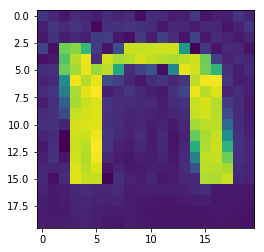

 
801
Was classified as an: N


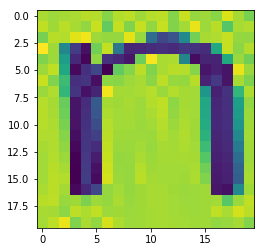

 
802
Was classified as an: N


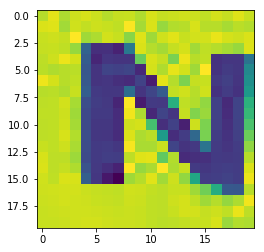

 
803
Was classified as an: N


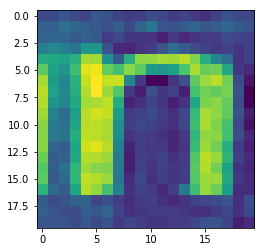

 
804
Was classified as an: N


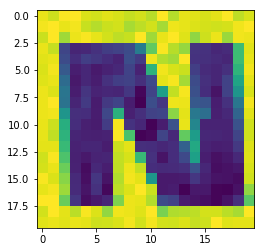

 
805
Was classified as an: N


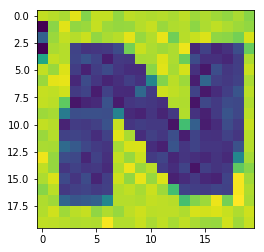

 
806
Was classified as an: N


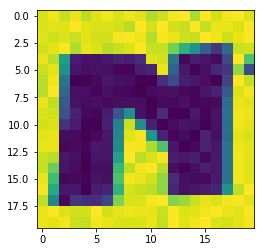

 
807
Was classified as an: N


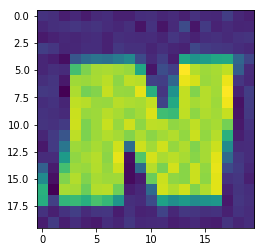

 
808
Was classified as an: N


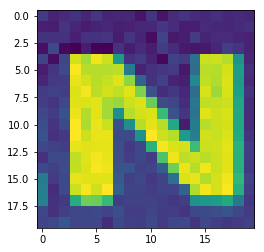

 
809
Was classified as an: N


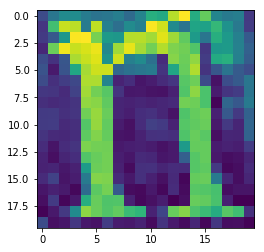

 
810
Was classified as an: N


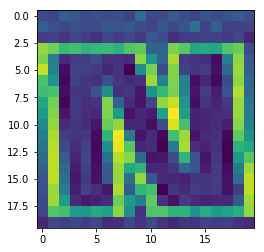

 
811
Was classified as an: N


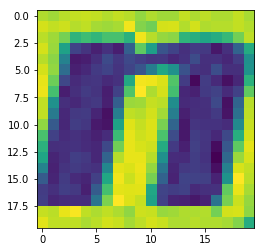

 
812
Was classified as an: N


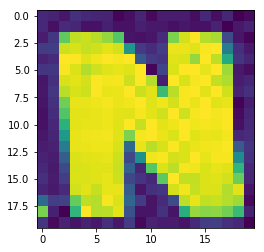

 
813
Was classified as an: N


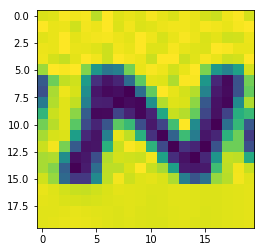

 
814
Was classified as an: N


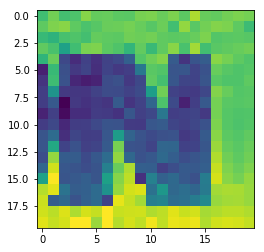

 
815
Was classified as an: N


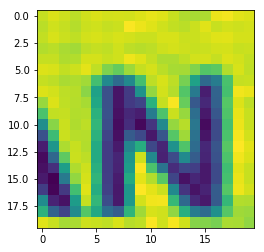

 
816
Was classified as an: N


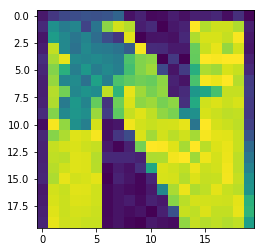

 
817
Was classified as an: N


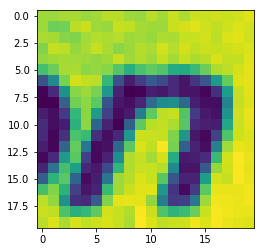

 
818
Was classified as an: H


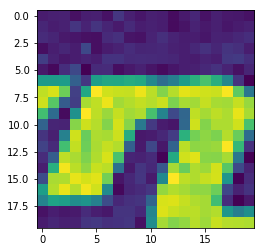

 
819
Was classified as an: N


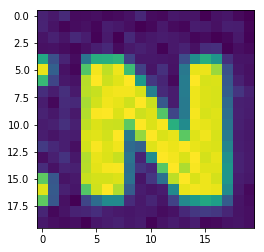

 
820
Was classified as an: N


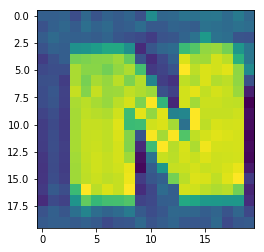

 
821
Was classified as an: N


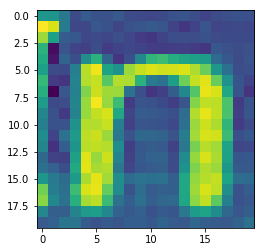

 
822
Was classified as an: N


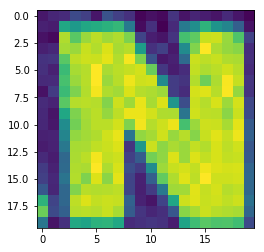

 
823
Was classified as an: N


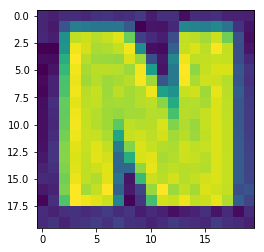

 
824
Was classified as an: N


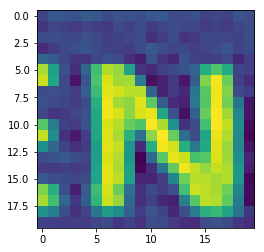

 
825
Was classified as an: N


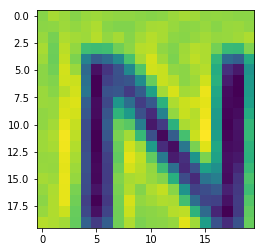

 
826
Was classified as an: N


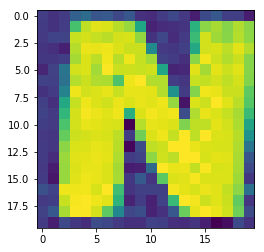

 
827
Was classified as an: N


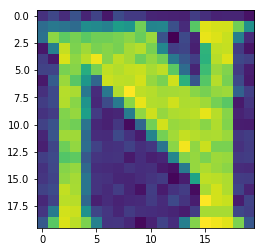

 
828
Was classified as an: N


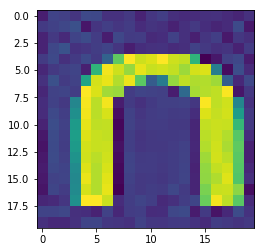

 
829
Was classified as an: N


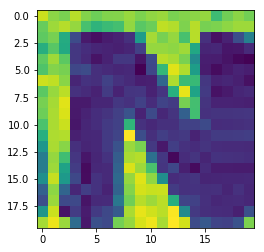

 
830
Was classified as an: N


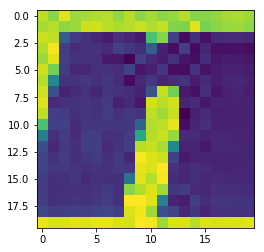

 
831
Was classified as an: N


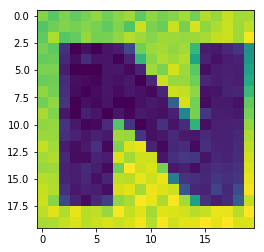

 
832
Was classified as an: N


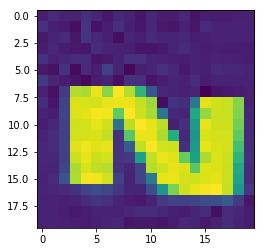

 
833
Was classified as an: N


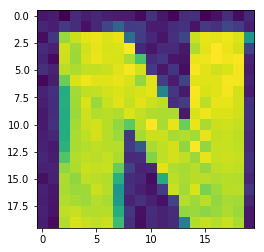

 
834
Was classified as an: N


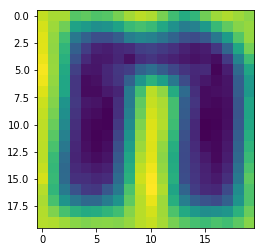

 
835
Was classified as an: N


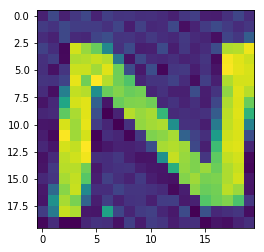

 
836
Was classified as an: N


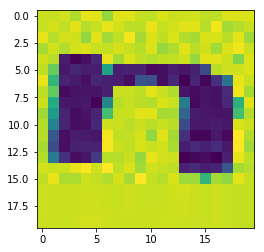

 
837
Was classified as an: N


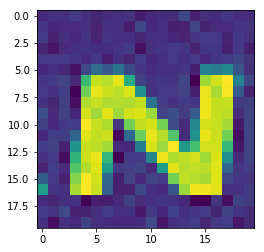

 
838
Was classified as an: N


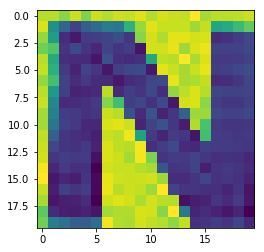

 
839
Was classified as an: N


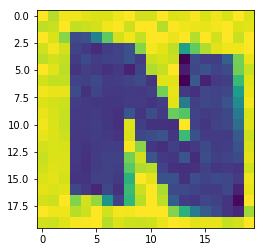

 
840
Was classified as an: N


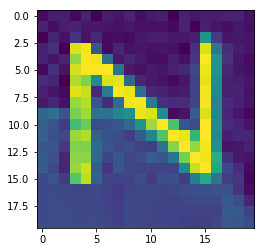

 
841
Was classified as an: N


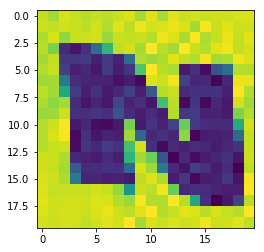

 
842
Was classified as an: N


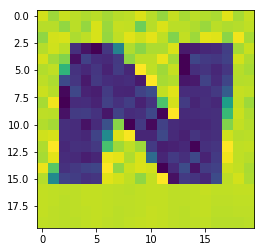

 
843
Was classified as an: N


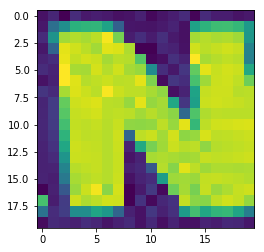

 
844
Was classified as an: N


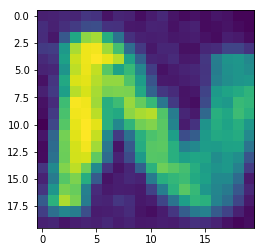

 
845
Was classified as an: N


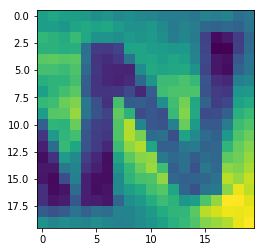

 
846
Was classified as an: N


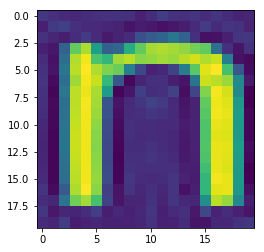

 
847
Was classified as an: N


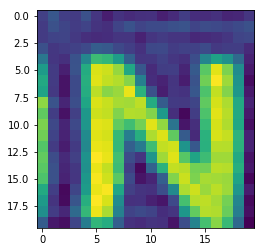

 
848
Was classified as an: N


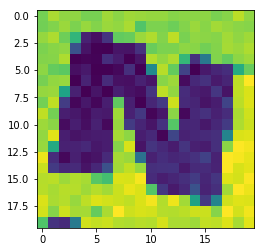

 
849
Was classified as an: O


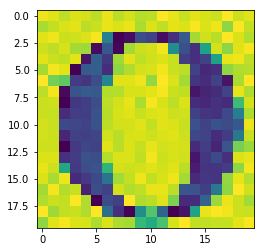

 
850
Was classified as an: O


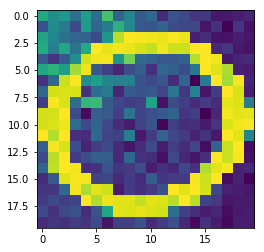

 
851
Was classified as an: O


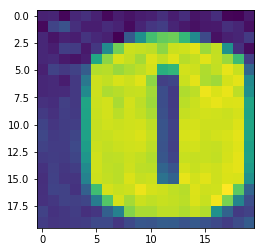

 
852
Was classified as an: O


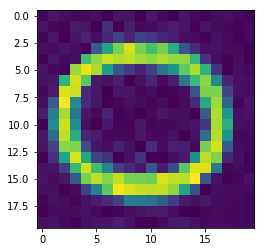

 
853
Was classified as an: O


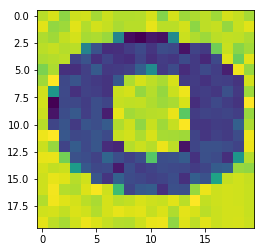

 
854
Was classified as an: O


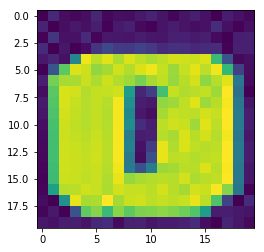

 
855
Was classified as an: O


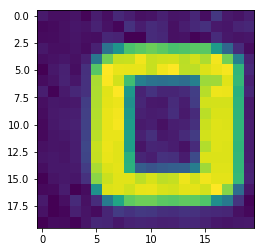

 
856
Was classified as an: O


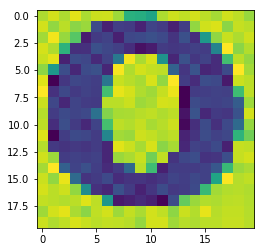

 
857
Was classified as an: O


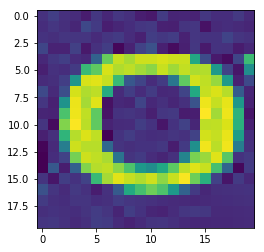

 
858
Was classified as an: N


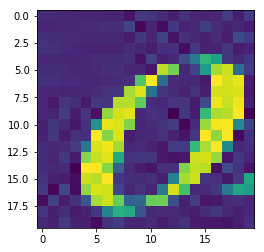

 
859
Was classified as an: O


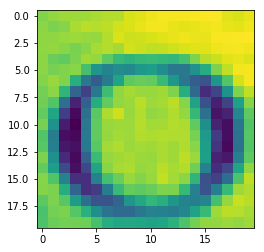

 
860
Was classified as an: D


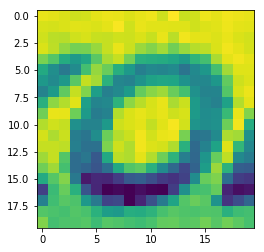

 
861
Was classified as an: O


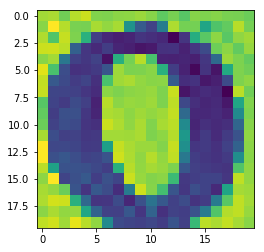

 
862
Was classified as an: O


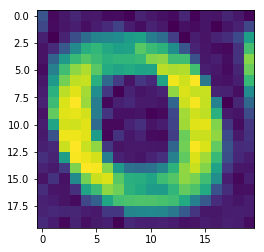

 
863
Was classified as an: R


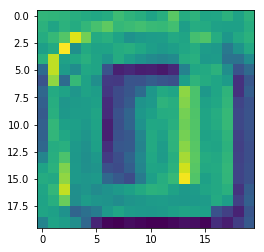

 
864
Was classified as an: O


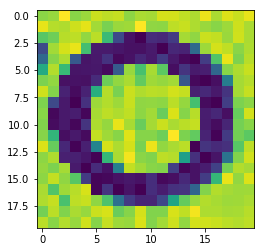

 
865
Was classified as an: O


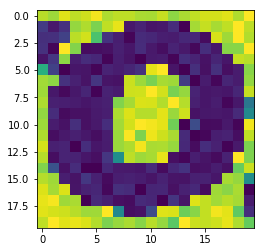

 
866
Was classified as an: O


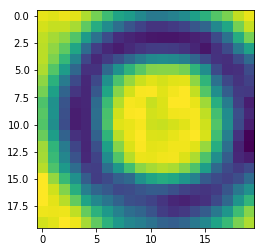

 
867
Was classified as an: O


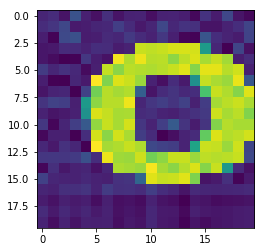

 
868
Was classified as an: O


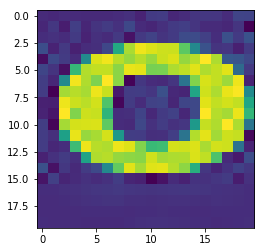

 
869
Was classified as an: O


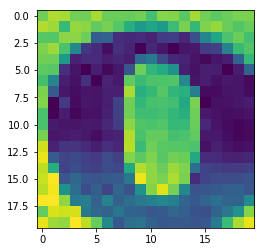

 
870
Was classified as an: O


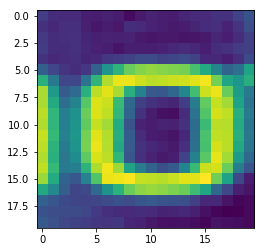

 
871
Was classified as an: O


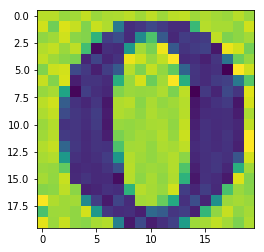

 
872
Was classified as an: O


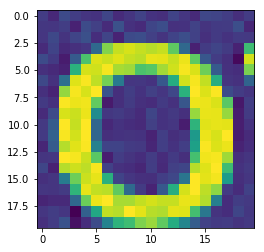

 
873
Was classified as an: O


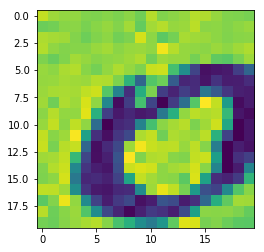

 
874
Was classified as an: O


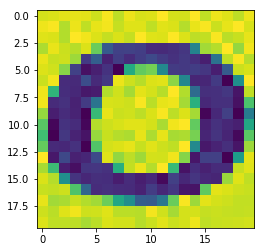

 
875
Was classified as an: O


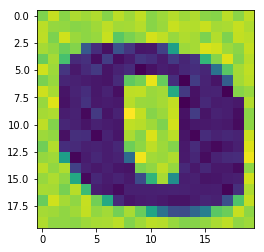

 
876
Was classified as an: O


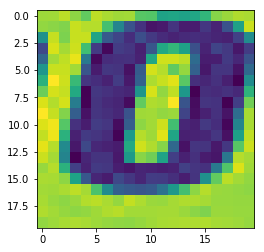

 
877
Was classified as an: O


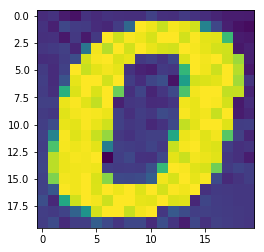

 
878
Was classified as an: O


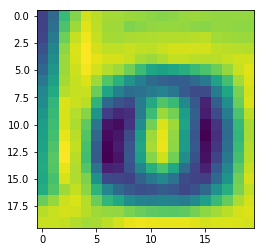

 
879
Was classified as an: O


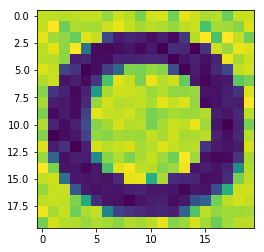

 
880
Was classified as an: O


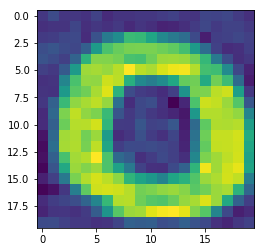

 
881
Was classified as an: O


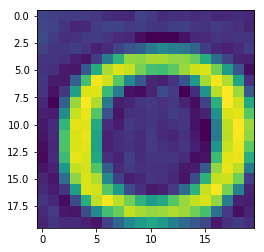

 
882
Was classified as an: O


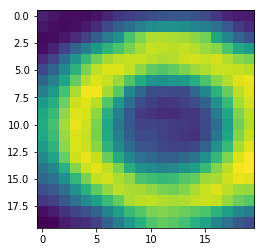

 
883
Was classified as an: O


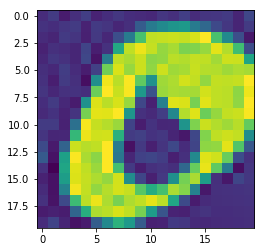

 
884
Was classified as an: O


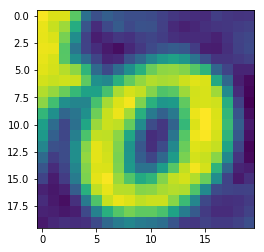

 
885
Was classified as an: O


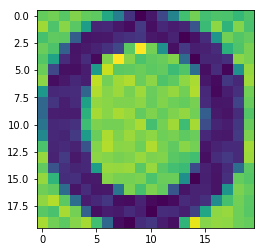

 
886
Was classified as an: O


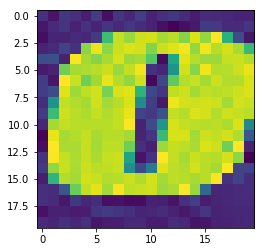

 
887
Was classified as an: C


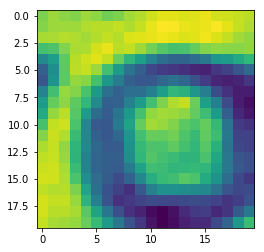

 
888
Was classified as an: O


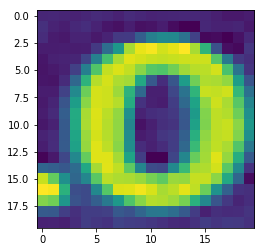

 
889
Was classified as an: O


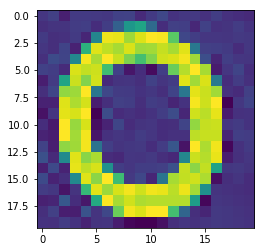

 
890
Was classified as an: O


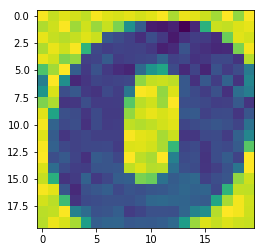

 
891
Was classified as an: O


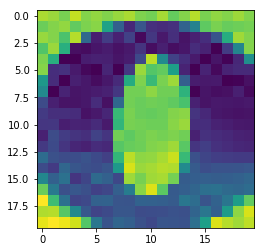

 
892
Was classified as an: O


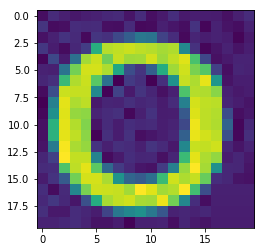

 
893
Was classified as an: O


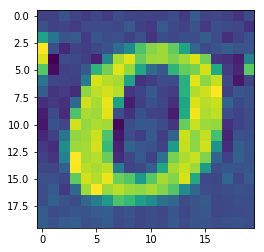

 
894
Was classified as an: O


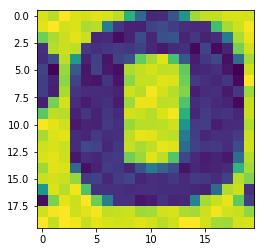

 
895
Was classified as an: O


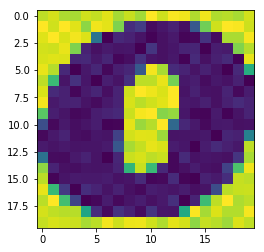

 
896
Was classified as an: O


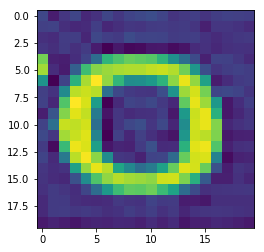

 
897
Was classified as an: O


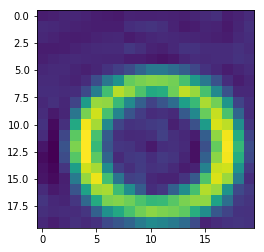

 
898
Was classified as an: O


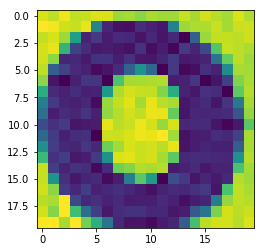

 
899
Was classified as an: O


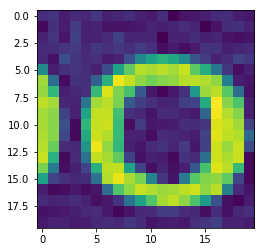

In [1327]:
# Ikke ta med
# Print classifications:

# kNN:
o = 1
res = []
plot = []
for j in range(900):
    o=o+1
    # print("Was classified as an: ", numberDict.get(y_merged_test_pred_rf[o][0]))
    #print(test_set_raw["Letter"][o])

    #print((test_set_raw.iloc[o,:]))
    
    a = ((test_set_raw.drop(labels='Letter', axis = 1)).loc[o].tolist())
    plot.append(np.reshape(a,(20,20)))
    
    
    # a = np.reshape(a, (20, 20))
    a = pd.DataFrame(data=a).T

    #print(a.values)
    #a
    #print(np.reshape(a,(20,20))
    
    # a = resize[:, :, 0]
    #a=np.reshape(window,20*20)
    #a = pd.DataFrame(data=window).T
    #a.append(window)
    #list1 = (window.values[0])
        
    
    
    
    #a = np.reshape(a,20,20)
    #a = np.asarray(a)
    
    #print(len(a))
    a=(model_tensor.predict(a.values))

    res.append(a)
    
    #print(a)
    
    
# Random Forest:
#a.values
# print(res)


# Printer den klassiserte dataen:
print("ll ")
i = 0
for r in res:
    print(i)
    num = (np.where(r[0] == (np.amax((r[0]))))[0][0])
    print("Was classified as an:",numberDict.get(num))
    plt.imshow(plot[i])
    plt.show()
    i+=1

    print(" ")


    


# Sliding window detection implementation with TensorFlow:

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


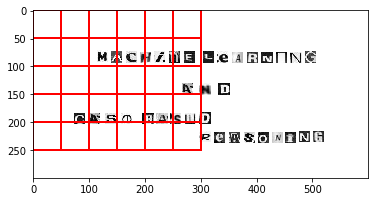

In [1313]:
## Sliding window detection:

import cv2
import matplotlib.pyplot as plt
import numpy as np


def OCR(imagepath):
    # read the image and define the stepSize and window size 
    image = cv2.imread(imagepath) # your image path
    tmp = image # for drawing a rectangle
    stepSize = 50
    (w_width, w_height) = (50,50) # window size
    class_letter = []
    number=[] # To keep track of which square in the grid that is classified
    i = 0 # counter for the number
    windows=[]
    for x in range(0, image.shape[1] - w_width , stepSize):
        for y in range(0, image.shape[0] - w_height, stepSize):
            window = image[x:x + w_width, y:y + w_height, :]
            resize = cv2.resize(window,(20,20),interpolation =cv2.INTER_AREA)
            window = np.asarray(resize)
            window = resize[:, :, 0]
            window=np.reshape(window,20*20)
            window = pd.DataFrame(data=window).T
            windows.append(window)
            list1 = (window.values[0])
            
            # Check if the window is "blank"
            if all(x == list1[0] for x in list1):
                print(" ", end="\r")
                # print("All elements in list are same.")
            else:
                # Classify window:
                prediction  = model_tensor_merged.predict(window.values)
                #class_letter.append(prediction)

                # knn
                class_letter.append(test_classifier_sliding(clf_n,window))
                number.append(i)

            # Plot the grid on top of the image:
            cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draw rectangle on image
            plt.imshow(np.array(tmp).astype('uint8'))
            i+=1
    # show all windows
    plt.show()
    return windows, number, class_letter
    
windows, number, class_letter = OCR("./detection-images/detection-2.jpg")
windows, number, class_letter = OCR("./detection-images/test_1.jpg")


In [1005]:
def test_classifier_sliding(clf, data):
    y = []
    for row in data.iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y

def test_classifier_sliding1(clf, data):
    y = []
    for row in data:
        y.append(clf.predict(([row[1].tolist()])))
    return y

In [1312]:
# Ikke ta med:
prev = 99
count =0
for c in class_letter:
    l = (c[0][0])
    if prev != l:
        print(l,numberDict.get(l),number[count])
        prev = l
        count+=1
        


8 I 0
4 E 1
5 F 2
9 J 3


### Printer den klassifiserte dataen fra hele systemet, number er hvilken rute den befinner seg i:

In [1306]:
# Prints the classified data and which square in the grid it belongs to:
print(" ")
i = 0
for c in class_letter:
    num = (np.where(c[0] == (np.amax((c[0]))))[0][0])
    print(numberDict.get(num),number[i])
    i+=1 

 
A 0
A 1
A 2
A 3
A 5
A 6
A 8


### Printing av windows fra sliding window detection:

teller:  0
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...    0    0    0    0   

   394  395  396  397  398  399  
0    9  132  252  255  255  255  

[1 rows x 400 columns]


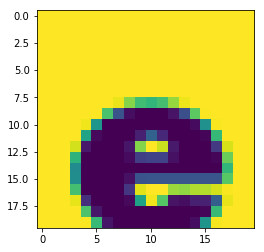

teller:  1
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...    0    0    0   40   

   394  395  396  397  398  399  
0  189  254  255  255  255  255  

[1 rows x 400 columns]


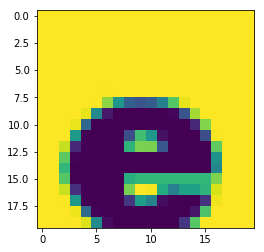

teller:  2
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


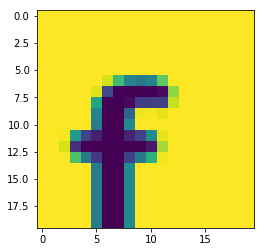

teller:  3
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  241  227  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


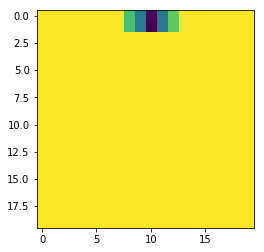

teller:  4
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


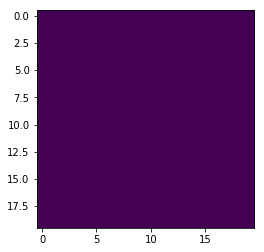

teller:  5
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  107    0    0  124  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


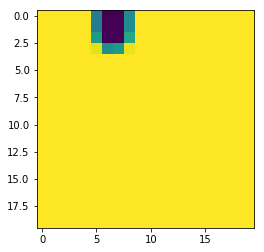

teller:  6
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  102  102  184  204   

   394  395  396  397  398  399  
0  180  245  255  255  255  255  

[1 rows x 400 columns]


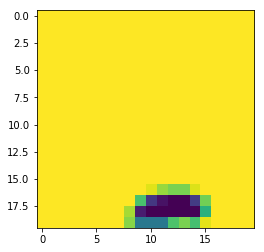

teller:  7
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


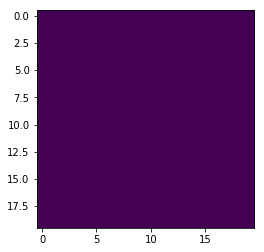

teller:  8
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  118    0    0   42  245  

[1 rows x 400 columns]


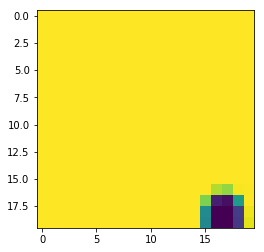

In [1307]:
teller = 0
for win in windows:
    print("teller: ", teller)
    
    print(win)
    w = (win).values.tolist()[0]
    w = np.reshape(w, (20, 20))
    plt.imshow(w)
    plt.show()
    # print(w)
    # print(w)
    teller += 1


True

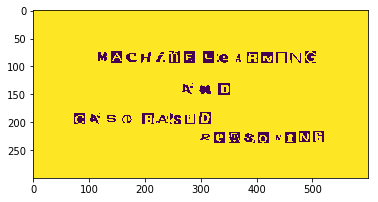

In [1085]:
### IKKE TA MED:


import cv2
img = cv2.imread("./detection-images/detection-2.jpg", 0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)

contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x + w, y + h), 255, 1)

cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
plt.imshow(img)
cv2.imwrite("output-2.png",img)